# Previsioni Fotovoltaiche con Temporal Fusion Transformer (TFT)

## Progetto di Deep Learning per Time Series Forecasting

Questo notebook implementa un sistema completo di forecasting per la produzione fotovoltaica utilizzando il modello Temporal Fusion Transformer (TFT). 

**Caratteristiche principali:**
- Forecasting a 24 ore della produzione fotovoltaica
- Cross-validation temporale per validazione robusta 
- Hyperparameter tuning automatico con Optuna
- Interpretabilità del modello con analisi delle attention weights
- MAPE mascherato per correggere il bias notturno

**Pipeline di esecuzione:**
1. Caricamento e preprocessamento dati PV + meteorologici
2. Feature engineering temporale e categoriale 
3. Hyperparameter tuning con validazione temporale
4. Training del modello finale con parametri ottimali
5. Evaluation completa con visualizzazioni
6. Analisi interpretabilità e feature importance

Il sistema supporta diverse modalità di esecuzione tramite flag configurabili, permettendo skip intelligente di fasi già completate per accelerare lo sviluppo iterativo.

## 1. Importazione delle Librerie

Importazione di tutte le librerie necessarie per il progetto di forecasting fotovoltaico con Temporal Fusion Transformer.

**Librerie principali utilizzate:**
- PyTorch Forecasting per il modello TFT
- Pandas per manipolazione dati  
- PyTorch Lightning per training distribuito
- Optuna per hyperparameter tuning
- Plotly per visualizzazioni interattive
- Scikit-learn per metriche di valutazione

In [1]:
# =============================================================================
# CONFIGURAZIONE MODALITÀ DI ESECUZIONE
# =============================================================================

# MODALITÀ OPERATIVE - CONFIGURA QUI PER CONTROLLO PIPELINE
RUN_TUNING_AND_CV = False   # False per saltare hyperparameter tuning + CV se già fatto
RUN_FINAL_TRAINING = False   # True per continuare con training finale

# CARTELLA DI RIFERIMENTO PER SKIP COMPLETO
# Quando entrambi flag sono False: usa questa cartella completamente
REFERENCE_RUN_FOLDER = "run_corretta"  # Cartella con risultati buoni

# PARAMETRI DI CONFIGURAZIONE PRINCIPALI  
CONFIG = {
    # Architettura TFT
    'MAX_ENCODER_LENGTH': 168,    # 1 settimana di contesto (ore)
    'MAX_PREDICTION_LENGTH': 24,  # Previsione 24 ore
    
    # Cross-Validation
    'N_FOLDS': 5,                 # Numero fold temporali
    'VAL_RATIO': 0.2,            # 20% per validation in ogni fold
    
    # Hyperparameter Tuning
    'N_TRIALS': 5,              # Numero trials Optuna (aumentare per risultati migliori)
    'OPTUNA_TIMEOUT_HOURS': 6,   # Timeout massimo per tuning
    
    # MAPE Masking (CRITICO - correzione ore notturne)
    'DAYLIGHT_START_HOUR': 6,    # Ora inizio considerazione MAPE (6:00)
    'DAYLIGHT_END_HOUR': 19,     # Ora fine considerazione MAPE (19:00) 
    'EPS_PV': 5.0,               # Soglia minima potenza kW per MAPE stabile
    
    # Training
    'MAX_EPOCHS_TUNING': 30,     # Epochs per ogni fold durante tuning
    'MAX_EPOCHS_FINAL': 150,     # Epochs per training finale
    'EARLY_STOPPING_PATIENCE': 15,
    
    # Riproducibilità
    'SEED': 42,
    
    # Device
    'ACCELERATOR': 'auto',       # 'auto', 'gpu', 'cpu'
}

print("=" * 70)
print("CONFIGURAZIONE PIPELINE PV FORECASTING")
print("=" * 70)
print(f"RUN_TUNING_AND_CV: {RUN_TUNING_AND_CV}")
print(f"RUN_FINAL_TRAINING: {RUN_FINAL_TRAINING}")

# Controllo modalità speciale
use_existing_results = not RUN_TUNING_AND_CV and not RUN_FINAL_TRAINING

if RUN_TUNING_AND_CV and not RUN_FINAL_TRAINING:
    print("ATTENZIONE: RUN_TUNING_AND_CV è True ma RUN_FINAL_TRAINING è False.")
    print("Questo non è uno scenario valido. Impostando RUN_FINAL_TRAINING a True.")
    RUN_FINAL_TRAINING = True

if use_existing_results:
    print(f"Modalità SKIP COMPLETO: Usando cartella di riferimento")
    print(f"Reference folder: {REFERENCE_RUN_FOLDER}")

print(f"\nEncoder Length: {CONFIG['MAX_ENCODER_LENGTH']} hours")
print(f"Prediction Length: {CONFIG['MAX_PREDICTION_LENGTH']} hours")
print(f"N Folds CV: {CONFIG['N_FOLDS']}")
print(f"Optuna Trials: {CONFIG['N_TRIALS']}")
print(f"\nMAPE Masking:")
print(f"   Daylight Hours: {CONFIG['DAYLIGHT_START_HOUR']}:00 - {CONFIG['DAYLIGHT_END_HOUR']}:00")
print(f"   EPS_PV Threshold: {CONFIG['EPS_PV']} kW")
print("=" * 70)

# =============================================================================
# CREAZIONE DIRECTORY RISULTATI CON TIMESTAMP O RIUSO CARTELLA ESISTENTE
# =============================================================================
import os
from pathlib import Path
from datetime import datetime
import json
import shutil

# Gestione diverse modalità
if use_existing_results:
    # Modalità skip completo: usa cartella esistente completamente
    reference_path = Path(f"results/{REFERENCE_RUN_FOLDER}")
    print(f"Controllo esistenza cartella: {reference_path}")
    print(f"Percorso assoluto: {reference_path.resolve()}")
    print(f"Directory corrente: {Path.cwd()}")
    
    if reference_path.exists():
        RESULTS_DIR = reference_path
        print(f"✅ Cartella trovata: {RESULTS_DIR}")
        
        # Carica configurazione dalla cartella esistente
        config_path = RESULTS_DIR / "config.json"
        if config_path.exists():
            with open(config_path, 'r') as f:
                existing_config = json.load(f)
            
            # Mantieni alcuni parametri dalla configurazione esistente
            for key in ['MAX_ENCODER_LENGTH', 'MAX_PREDICTION_LENGTH', 'N_FOLDS', 
                       'DAYLIGHT_START_HOUR', 'DAYLIGHT_END_HOUR', 'EPS_PV']:
                if key in existing_config:
                    CONFIG[key] = existing_config[key]
            
            timestamp = existing_config.get('TIMESTAMP', REFERENCE_RUN_FOLDER.split('_')[-1])
            print(f"Usando cartella esistente: {RESULTS_DIR}")
            print(f"Configurazione caricata dalla cartella esistente")
            print(f"Timestamp estratto: {timestamp}")
        else:
            timestamp = REFERENCE_RUN_FOLDER.split('_')[-1]
            print(f"Config non trovato, usando timestamp dalla cartella: {timestamp}")
    else:
        print(f"   ERRORE: Cartella di riferimento {reference_path} non trovata!")
        print(f"   Percorso assoluto cercato: {reference_path.resolve()}")
        print(f"   Directory corrente: {Path.cwd()}")
        # Lista i contenuti della directory results se esiste
        results_dir = Path("results")
        if results_dir.exists():
            print(f"   Contenuti directory results:")
            for item in results_dir.iterdir():
                print(f"     - {item.name}")
        print(f"Creando nuova cartella invece...")
        use_existing_results = False

if not use_existing_results:
    # Modalità standard: crea directory results con timestamp unico
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    RESULTS_DIR = Path(f"results/run_{timestamp}")
    RESULTS_DIR.mkdir(parents=True, exist_ok=True)
    print(f"Nuova cartella creata: {RESULTS_DIR}")

# Sub-directory per organizzazione
FIGURES_DIR = RESULTS_DIR / "figures"
MODELS_DIR = RESULTS_DIR / "models" 
FIGURES_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)

print(f"\nDirectory risultati: {RESULTS_DIR.absolute()}")
print(f"Figures: {FIGURES_DIR}")
print(f"Models: {MODELS_DIR}")

# Salva/aggiorna configurazione
CONFIG['RESULTS_DIR'] = str(RESULTS_DIR)
CONFIG['FIGURES_DIR'] = str(FIGURES_DIR)
CONFIG['MODELS_DIR'] = str(MODELS_DIR)
CONFIG['TIMESTAMP'] = timestamp
CONFIG['RUN_TUNING_AND_CV'] = RUN_TUNING_AND_CV
CONFIG['RUN_FINAL_TRAINING'] = RUN_FINAL_TRAINING
CONFIG['USE_EXISTING_RESULTS'] = use_existing_results
if use_existing_results:
    CONFIG['REFERENCE_RUN_FOLDER'] = REFERENCE_RUN_FOLDER

config_path = RESULTS_DIR / "config.json"
with open(config_path, 'w') as f:
    json.dump(CONFIG, f, indent=4)

if use_existing_results:
    print(f"Configurazione aggiornata: {config_path}")
    print(f"Modalità RIUSO CARTELLA ESISTENTE attiva")
else:
    print(f"Configurazione salvata: {config_path}")

print(f"\nSetup completato - Run ID: {timestamp}")
if use_existing_results:
    print(f"Modalità: SKIP COMPLETO usando cartella esistente")
    print(f"Tutti i file necessari saranno caricati da: {RESULTS_DIR}")
else:
    print(f"Modalità: Standard (nuova esecuzione completa)")

CONFIGURAZIONE PIPELINE PV FORECASTING
RUN_TUNING_AND_CV: False
RUN_FINAL_TRAINING: False
Modalità SKIP COMPLETO: Usando cartella di riferimento
Reference folder: run_corretta

Encoder Length: 168 hours
Prediction Length: 24 hours
N Folds CV: 5
Optuna Trials: 5

MAPE Masking:
   Daylight Hours: 6:00 - 19:00
   EPS_PV Threshold: 5.0 kW
Usando cartella esistente: results\run_corretta
Configurazione caricata dalla cartella esistente

Directory risultati: c:\Users\loren\Desktop\DL_project\src\results\run_corretta
Figures: results\run_corretta\figures
Models: results\run_corretta\models
Configurazione aggiornata: results\run_corretta\config.json
Modalità RIUSO CARTELLA ESISTENTE attiva

Setup completato - Run ID: 20260111_194622
Modalità: SKIP COMPLETO usando cartella esistente
Tutti i file necessari saranno caricati da: results\run_corretta


## 2. Configurazione Environment e Import Librerie

Importazione di tutte le librerie necessarie per il progetto e configurazione dell'environment di esecuzione.

**Operazioni eseguite:**
- Import delle librerie PyTorch, Lightning, PyTorch Forecasting
- Verifica disponibilità GPU/CUDA
- Configurazione del device di calcolo
- Impostazione seed per riproducibilità
- Visualizzazione versioni librerie per troubleshooting

In [2]:
# Data manipulation e processing
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import warnings
import pickle
import json
import os
import shutil
from pathlib import Path
import gc
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')

# PyTorch ecosystem
import torch
import torch.nn as nn

# Fix PyTorch 2.6 - gestione weights_only per compatibilità checkpoint loading
if not hasattr(torch, '_original_load_patched'):
    # Salva riferimento originale solo se non già fatto
    torch._original_load = torch.load
    
    def safe_torch_load(*args, **kwargs):
        # Forza weights_only=False per evitare errori in PyTorch 2.6
        kwargs.setdefault('weights_only', False)
        return torch._original_load(*args, **kwargs)
    
    torch.load = safe_torch_load
    torch._original_load_patched = True
    print("PyTorch 2.6 fix applicato: torch.load ora usa weights_only=False automaticamente")
else:
    print("PyTorch fix già applicato in precedenza")

# PyTorch Lightning - Handle different import styles
try:
    # New style (lightning 2.0+)
    from lightning.pytorch import Trainer, seed_everything
    from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
    from lightning.pytorch.loggers import TensorBoardLogger
    import lightning.pytorch as pl
    print("✓ Using Lightning 2.x imports")
except (ImportError, AttributeError):
    # Fallback to old style
    try:
        from pytorch_lightning import Trainer, seed_everything
        from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
        from pytorch_lightning.loggers import TensorBoardLogger
        import pytorch_lightning as pl
        print("✓ Using PyTorch Lightning 1.x imports")
    except ImportError as e:
        print(f"Lightning import error: {e}")
        raise

# PyTorch Forecasting
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, QuantileLoss
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, RMSE, SMAPE

# Scikit-learn metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Hyperparameter Optimization
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

# Random seed setup for reproducibility
seed_everything(CONFIG['SEED'])
np.random.seed(CONFIG['SEED'])
torch.manual_seed(CONFIG['SEED'])

print(f"\n{'='*70}")
print("PACKAGE VERSIONS & DEVICE INFO")
print(f"{'='*70}")
print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {pl.__version__}")
print(f"Optuna version: {optuna.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

# GPU/CUDA verification  
print(f"\nDEVICE CONFIGURATION:")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU count: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    
    # Test GPU functionality
    test_tensor = torch.randn(3, 3).cuda()
    print(f"GPU test successful: tensor on {test_tensor.device}")
    del test_tensor
    
    device = 'cuda'
else:

    print("GPU not available - using CPU")
    print("\nImport e setup completati!")

    device = 'cpu'

print(f"{'='*70}")

print(f"Selected device: {device}")
print(f"Seed set to: {CONFIG['SEED']}")
print(f"{'='*70}")

print("\\n Import e setup completati!")

PyTorch 2.6 fix applicato: torch.load ora usa weights_only=False automaticamente
✓ Using Lightning 2.x imports


Seed set to 42



PACKAGE VERSIONS & DEVICE INFO
PyTorch version: 2.7.1+cu118
PyTorch Lightning version: 2.6.0
Optuna version: 4.6.0
NumPy version: 2.3.3
Pandas version: 2.3.3

DEVICE CONFIGURATION:
CUDA available: True
CUDA version: 11.8
GPU count: 1
Current GPU: 0
GPU name: NVIDIA GeForce RTX 4070 Laptop GPU
GPU test successful: tensor on cuda:0
Selected device: cuda
Seed set to: 42
\n Import e setup completati!


## 3. Caricamento e Merging dei Dataset

Caricamento dei dataset di produzione fotovoltaica e dati meteorologici con merge temporale.

**Operazioni eseguite:**
- Ricerca automatica dei file CSV nei dataset PV e meteorologici
- Caricamento e parsing dei timestamp
- Merge temporale dei due dataset
- Creazione del dataset unificato con target (power_kw) e features meteorologiche
- Gestione automatica di diverse convenzioni di naming dei file

In [3]:
def find_csv_files():
    """
    Cerca automaticamente i file CSV dei dataset PV e Weather
    Gestisce multiple directory e naming conventions
    """
    print("Ricerca automatica file CSV...")
    
    # Possibili directory dove cercare
    search_dirs = [
        Path("../data/raw"),
        Path("../data"), 
        Path("./data"),
        Path("."),
        Path(".."),
    ]
    
    found_files = {}
    
    # Patterns per identificare i file
    pv_patterns = ["*pv_dataset*.csv", "*PV*.csv", "*power*.csv"]
    wx_patterns = ["*wx_dataset*.csv", "*weather*.csv", "*meteo*.csv"] 
    
    for search_dir in search_dirs:
        if not search_dir.exists():
            continue
            
        print(f"Cercando in: {search_dir.absolute()}")
        
        # Cerca file PV
        pv_files = []
        for pattern in pv_patterns:
            pv_files.extend(list(search_dir.glob(pattern)))
        
        # Cerca file Weather
        wx_files = []
        for pattern in wx_patterns:
            wx_files.extend(list(search_dir.glob(pattern)))
            
        if pv_files:
            found_files['pv_files'] = sorted(pv_files)
            print(f"PV files: {[f.name for f in pv_files]}")
            
        if wx_files:
            found_files['wx_files'] = sorted(wx_files) 
            print(f"Weather files: {[f.name for f in wx_files]}")
            
        # Se trovati entrambi i tipi, stop search
        if 'pv_files' in found_files and 'wx_files' in found_files:
            break
            
    return found_files

def load_and_merge_datasets(found_files):
    """
    Carica e unisce i dataset PV e Weather
    """
    print(f"\n{'='*60}")
    print("CARICAMENTO E MERGE DATASETS")
    print(f"{'='*60}")
    
    # Carica dataset PV
    pv_data_list = []
    for pv_file in found_files['pv_files']:
        print(f"Caricando: {pv_file.name}")
        df = pd.read_csv(pv_file)
        print(f"   Shape: {df.shape}, Colonne: {list(df.columns)}")
        pv_data_list.append(df)
    
    # Concatena dataset PV
    pv_data = pd.concat(pv_data_list, ignore_index=True)
    print(f"\nDataset PV concatenato: {pv_data.shape}")
    
    # Identifica colonne datetime e target
    datetime_candidates = [col for col in pv_data.columns if any(x in col.lower() for x in ['date', 'time', 'dt', 'timestamp'])]
    
    if not datetime_candidates:
        # Se non trovato, usa prima colonna che sembra temporale
        datetime_candidates = [pv_data.columns[0]]
        
    datetime_col = datetime_candidates[0] 
    
    # Target è la prima colonna numerica che non è datetime
    numeric_cols = pv_data.select_dtypes(include=[np.number]).columns.tolist()
    target_col = numeric_cols[0] if numeric_cols else pv_data.columns[1]
    
    print(f"Colonna datetime: '{datetime_col}'")
    print(f"Colonna target: '{target_col}'")
    
    # Rinomina colonne PV
    pv_data = pv_data.rename(columns={datetime_col: 'datetime', target_col: 'power_kw'})
    
    # Carica dataset Weather
    wx_data_list = []
    for wx_file in found_files['wx_files']:
        print(f"Caricando: {wx_file.name}")
        df = pd.read_csv(wx_file)
        print(f"   Shape: {df.shape}")
        wx_data_list.append(df)
    
    # Concatena dataset Weather  
    wx_data = pd.concat(wx_data_list, ignore_index=True)
    print(f"Dataset Weather concatenato: {wx_data.shape}")
    
    # Identifica colonna datetime in weather
    wx_datetime_candidates = [col for col in wx_data.columns if any(x in col.lower() for x in ['date', 'time', 'dt', 'timestamp'])]
    if wx_datetime_candidates:
        wx_data = wx_data.rename(columns={wx_datetime_candidates[0]: 'datetime'})
    
    # Converti datetime con gestione formati misti
    try:
        pv_data['datetime'] = pd.to_datetime(pv_data['datetime'], format='mixed', utc=True).dt.tz_localize(None)
        wx_data['datetime'] = pd.to_datetime(wx_data['datetime'], format='mixed', utc=True).dt.tz_localize(None)
    except:
        # Fallback con inferenza automatica  
        pv_data['datetime'] = pd.to_datetime(pv_data['datetime']).dt.tz_localize(None) if pv_data['datetime'].dtype == 'object' else pv_data['datetime']
        wx_data['datetime'] = pd.to_datetime(wx_data['datetime']).dt.tz_localize(None) if wx_data['datetime'].dtype == 'object' else wx_data['datetime']
    
    # Rimuovi duplicati temporali
    pv_data = pv_data.drop_duplicates(subset=['datetime']).sort_values('datetime').reset_index(drop=True)
    wx_data = wx_data.drop_duplicates(subset=['datetime']).sort_values('datetime').reset_index(drop=True)
    
    print(f"\\n Range PV: {pv_data['datetime'].min()} → {pv_data['datetime'].max()}")
    print(f"Range Weather: {wx_data['datetime'].min()} → {wx_data['datetime'].max()}")
    
    # Merge interno (inner join)
    merged_data = pd.merge(pv_data, wx_data, on='datetime', how='inner')
    merged_data = merged_data.sort_values('datetime').reset_index(drop=True)
    
    print(f"\n Dataset mergato: {merged_data.shape}")
    print(f"Periodo finale: {merged_data['datetime'].min()} → {merged_data['datetime'].max()}")
    
    return merged_data

# Esegui caricamento dati
found_files = find_csv_files()

if 'pv_files' not in found_files or 'wx_files' not in found_files:
    print("File mancanti! Assicurati di avere:")
    print("  - File PV: pv_dataset*.csv nella directory data/")
    print("  - File Weather: wx_dataset*.csv nella directory data/") 
    raise FileNotFoundError("Dataset files not found")

# Carica e unisci i dati
data = load_and_merge_datasets(found_files)

print(f"\\nColonne disponibili:")
for i, col in enumerate(data.columns):
    print(f"  {i+1:2d}. {col}")

print(f"\\nPrime righe del dataset unificato:")
print(data.head())

print(f"\\nData loading completato - Dataset shape: {data.shape}")

Ricerca automatica file CSV...
Cercando in: c:\Users\loren\Desktop\DL_project\src\..\data\raw
PV files: ['pv_dataset - 07-10--06-11.csv', 'pv_dataset - 07-11--06-12.csv', 'pv_dataset - 07-10--06-11.csv', 'pv_dataset - 07-11--06-12.csv']
Weather files: ['wx_dataset - 07-10--06-11.csv', 'wx_dataset - 07-11--06-12.csv']

CARICAMENTO E MERGE DATASETS
Caricando: pv_dataset - 07-10--06-11.csv
   Shape: (8760, 2), Colonne: ['Max kWp', '82.41']
Caricando: pv_dataset - 07-10--06-11.csv
   Shape: (8760, 2), Colonne: ['Max kWp', '82.41']
Caricando: pv_dataset - 07-11--06-12.csv
   Shape: (8784, 2), Colonne: ['Max kWp', '82.41']
Caricando: pv_dataset - 07-11--06-12.csv
   Shape: (8784, 2), Colonne: ['Max kWp', '82.41']

Dataset PV concatenato: (35088, 2)
Colonna datetime: 'Max kWp'
Colonna target: '82.41'
Caricando: wx_dataset - 07-10--06-11.csv
   Shape: (8760, 15)
Caricando: wx_dataset - 07-11--06-12.csv
   Shape: (8784, 15)
Dataset Weather concatenato: (17544, 15)
\n Range PV: 2010-07-01 00:00:

## 4. Analisi Dati e Gestione Valori Mancanti

Analisi esplorativa del dataset unificato e implementazione di strategie per gestire i valori mancanti.

**Operazioni eseguite:**
- Analisi della struttura e completezza del dataset
- Identificazione e quantificazione dei valori mancanti per colonna
- Implementazione di strategie di filling robuste:
  - Interpolazione lineare per serie continue
  - Forward fill per preservare ultima osservazione valida
- Validazione del dataset pulito senza valori mancanti

Avvio analisi dataset...
ANALISI DATASET
Informazioni generali:
  Shape: (17317, 16)
  Periodo: 2010-07-01 00:00 → 2012-06-30 13:00
  Durata: 730 giorni

Tipi colonne:
  Numeriche: 14 - ['power_kw', 'lat', 'lon', 'temp', 'dew_point', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'clouds_all', 'Dhi', 'Dni', 'Ghi']
  Datetime: 1 - ['datetime']
  Object: 1 - ['weather_description']

Analisi target (power_kw):
  Min: 0.00 kW
  Max: 68.92 kW
  Mean: 12.53 kW
  Median: 0.04 kW
  Std: 18.55 kW
  Zero count: 8515
  Negative count: 0

GESTIONE VALORI MANCANTI
Valori mancanti trovati:
         Missing_Count  Missing_Percentage
rain_1h          13658           78.870474
rain_1h: NaN → 0 (nessuna pioggia)

Risultato finale:
  Dataset originale: 17317 righe
  Dataset pulito: 17317 righe
  Valori mancanti residui: 0
Tutti i valori mancanti gestiti con successo!

Creazione preview serie temporale...


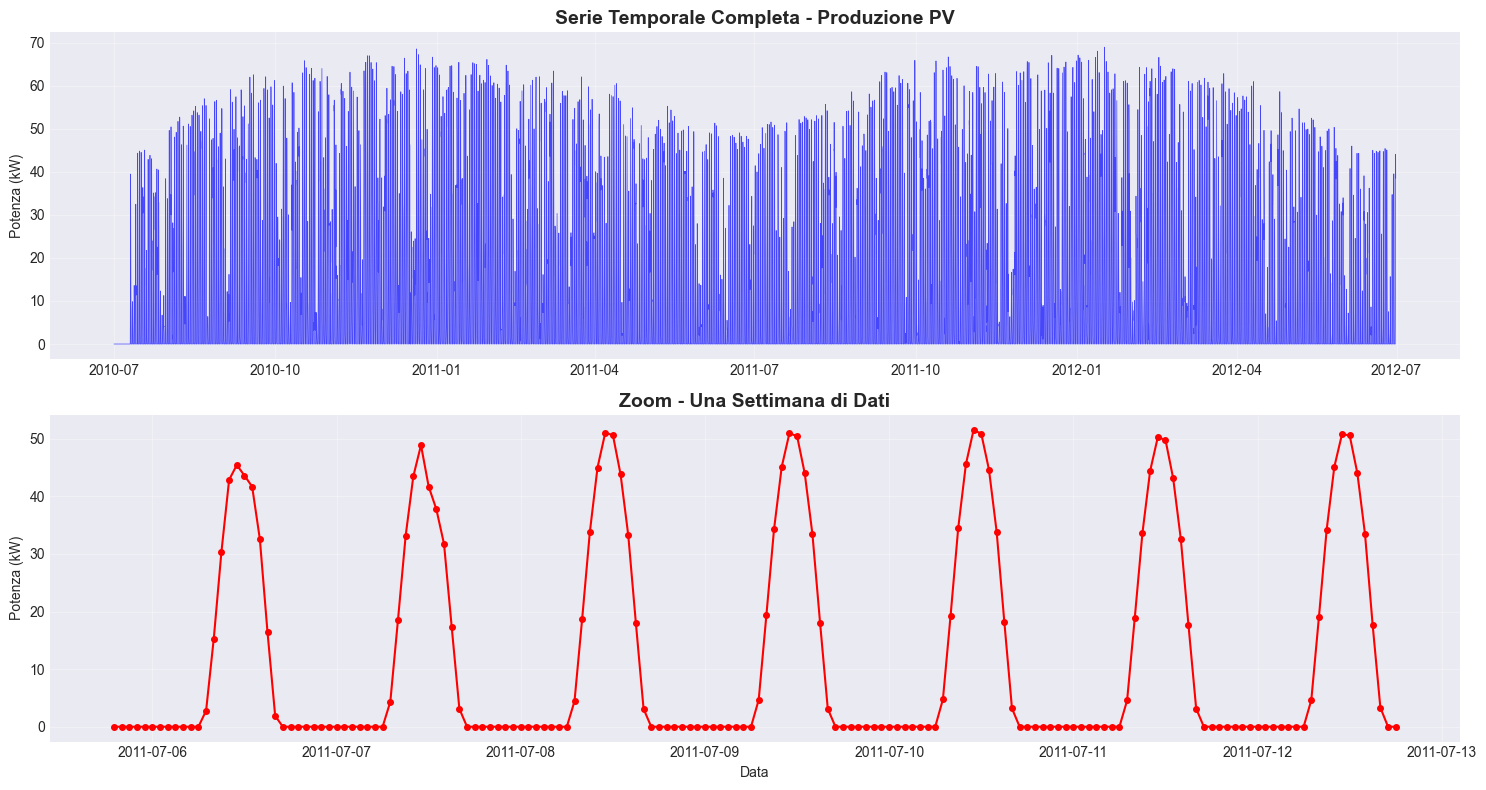

Figura salvata: results\run_corretta\figures\01_data_overview.png

Data Analysis completata - Dataset pulito: (17317, 16)


In [4]:
def analyze_dataset(data):
    """
    Analisi completa del dataset con statistiche e quality checks
    """
    print(f"{'='*70}")
    print("ANALISI DATASET")
    print(f"{'='*70}")
    
    print(f"Informazioni generali:")
    print(f"  Shape: {data.shape}")
    print(f"  Periodo: {data['datetime'].min().strftime('%Y-%m-%d %H:%M')} → {data['datetime'].max().strftime('%Y-%m-%d %H:%M')}")
    print(f"  Durata: {(data['datetime'].max() - data['datetime'].min()).days} giorni")
    
    # Identificazione tipi di colonne
    numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    datetime_cols = data.select_dtypes(include=['datetime64']).columns.tolist()
    object_cols = data.select_dtypes(include=['object']).columns.tolist()
    
    print(f"\nTipi colonne:")
    print(f"  Numeriche: {len(numeric_cols)} - {numeric_cols}")
    print(f"  Datetime: {len(datetime_cols)} - {datetime_cols}")
    print(f"  Object: {len(object_cols)} - {object_cols}")
    
    # Analisi target (power_kw)
    if 'power_kw' in data.columns:
        power_stats = {
            'min': data['power_kw'].min(),
            'max': data['power_kw'].max(),
            'mean': data['power_kw'].mean(),
            'median': data['power_kw'].median(),
            'std': data['power_kw'].std(),
            'zero_count': (data['power_kw'] == 0).sum(),
            'negative_count': (data['power_kw'] < 0).sum()
        }
        
        print(f"\nAnalisi target (power_kw):")
        for key, value in power_stats.items():
            if key in ['min', 'max', 'mean', 'median', 'std']:
                print(f"  {key.capitalize()}: {value:.2f} kW")
            else:
                print(f"  {key.replace('_', ' ').capitalize()}: {value}")
    
    return {
        'numeric_cols': numeric_cols,
        'datetime_cols': datetime_cols, 
        'object_cols': object_cols,
        'power_stats': power_stats if 'power_kw' in data.columns else None
    }

def handle_missing_values(data):
    """
    Gestione robusta dei valori mancanti con strategie multiple
    """
    print(f"\n{'='*70}")
    print("GESTIONE VALORI MANCANTI")
    print(f"{'='*70}")
    
    # Controllo valori mancanti
    missing_summary = data.isnull().sum()
    missing_pct = (missing_summary / len(data)) * 100
    
    missing_df = pd.DataFrame({
        'Missing_Count': missing_summary,
        'Missing_Percentage': missing_pct
    })[missing_summary > 0].sort_values('Missing_Count', ascending=False)
    
    if len(missing_df) == 0:
        print("Nessun valore mancante trovato!")
        return data.copy()
    
    print("Valori mancanti trovati:")
    print(missing_df)
    
    data_cleaned = data.copy()
    
    # Strategia 1: rain_1h (NaN significa 0 - nessuna pioggia)
    if 'rain_1h' in data_cleaned.columns and data_cleaned['rain_1h'].isnull().any():
        data_cleaned['rain_1h'] = data_cleaned['rain_1h'].fillna(0)
        print("rain_1h: NaN → 0 (nessuna pioggia)")
    
    # Strategia 2: Interpolazione lineare per serie temporali
    numeric_cols = data_cleaned.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        missing_before = data_cleaned[col].isnull().sum()
        if missing_before > 0:
            # Interpolazione lineare limitata (max 3 valori consecutivi)
            data_cleaned[col] = data_cleaned[col].interpolate(
                method='linear', 
                limit=3,  # Max 3 valori consecutivi
                limit_direction='both'
            )
            
            # Forward/backward fill per eventuali gap rimanenti  
            data_cleaned[col] = data_cleaned[col].fillna(method='ffill', limit=2)
            data_cleaned[col] = data_cleaned[col].fillna(method='bfill', limit=2)
            
            missing_after = data_cleaned[col].isnull().sum()
            if missing_after < missing_before:
                print(f"{col}: {missing_before} → {missing_after} missing values")
    
    # Strategia 3: Rimozione righe con troppi NaN rimanenti
    rows_before = len(data_cleaned)
    data_cleaned = data_cleaned.dropna()
    rows_after = len(data_cleaned)
    
    if rows_before != rows_after:
        print(f"Rimosse {rows_before - rows_after} righe con NaN residui")
    
    # Verifica finale
    final_missing = data_cleaned.isnull().sum().sum()
    print(f"\nRisultato finale:")
    print(f"  Dataset originale: {len(data)} righe")
    print(f"  Dataset pulito: {len(data_cleaned)} righe")
    print(f"  Valori mancanti residui: {final_missing}")
    
    if final_missing == 0:
        print("Tutti i valori mancanti gestiti con successo!")
    else:
        print("Alcuni valori mancanti potrebbero rimanere")
    
    return data_cleaned

# Esegui analisi dataset
print("Avvio analisi dataset...")
dataset_info = analyze_dataset(data)

# Gestisci valori mancanti
data_clean = handle_missing_values(data)

# Visualizzazione rapida della serie temporale target
if 'power_kw' in data_clean.columns:
    print("\nCreazione preview serie temporale...")
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
    
    # Serie completa
    ax1.plot(data_clean['datetime'], data_clean['power_kw'], linewidth=0.5, alpha=0.7, color='blue')
    ax1.set_title('Serie Temporale Completa - Produzione PV', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Potenza (kW)')
    ax1.grid(True, alpha=0.3)
    
    # Zoom su una settimana (sample)
    sample_start = len(data_clean) // 2
    sample_end = min(sample_start + 168, len(data_clean))  # 1 settimana o fino alla fine
    
    sample_data = data_clean.iloc[sample_start:sample_end]
    ax2.plot(sample_data['datetime'], sample_data['power_kw'], 
             marker='o', markersize=4, linewidth=1.5, color='red')
    ax2.set_title('Zoom - Una Settimana di Dati', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Data')
    ax2.set_ylabel('Potenza (kW)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Salva figura
    fig_path = FIGURES_DIR / "01_data_overview.png"
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Figura salvata: {fig_path}")

print(f"\nData Analysis completata - Dataset pulito: {data_clean.shape}")

# Aggiorna la variabile principale
data = data_clean

## 5. Feature Engineering

Creazione di feature temporali e trasformazione dei dati per ottimizzare le performance del modello TFT.

**Feature temporali create:**
- Encoding ciclico di ora, giorno settimana, mese (sin/cos)
- Feature temporali discrete per catturare pattern stagionali
- Normalizzazione variabili meteorologiche con scaling fisico appropriato

**Output:** Dataset con tutte le feature necessarie per il training del modello TFT

In [5]:
def create_temporal_features(data):
    """
    Crea features temporali ciclici per catturare seasonalità
    """
    print(f"{'='*70}")
    print("CREAZIONE FEATURES TEMPORALI CICLICI")
    print(f"{'='*70}")
    
    data_fe = data.copy()
    
    # Estrai componenti temporali
    data_fe['hour'] = data_fe['datetime'].dt.hour
    data_fe['day_of_year'] = data_fe['datetime'].dt.dayofyear
    data_fe['month'] = data_fe['datetime'].dt.month
    data_fe['day_of_week'] = data_fe['datetime'].dt.dayofweek
    
    # Encoding ciclici (sin/cos) per preservare continuità
    
    # 1. Hour (0-23, periodo 24)
    data_fe['hour_sin'] = np.sin(2 * np.pi * data_fe['hour'] / 24)
    data_fe['hour_cos'] = np.cos(2 * np.pi * data_fe['hour'] / 24)
    
    # 2. Day of year (1-365, periodo 365)
    data_fe['day_sin'] = np.sin(2 * np.pi * (data_fe['day_of_year'] - 1) / 365)
    data_fe['day_cos'] = np.cos(2 * np.pi * (data_fe['day_of_year'] - 1) / 365)
    
    # 3. Month (1-12, periodo 12)
    data_fe['month_sin'] = np.sin(2 * np.pi * (data_fe['month'] - 1) / 12)
    data_fe['month_cos'] = np.cos(2 * np.pi * (data_fe['month'] - 1) / 12)
    
    # 4. Day of week (0-6, periodo 7)
    data_fe['dow_sin'] = np.sin(2 * np.pi * data_fe['day_of_week'] / 7)
    data_fe['dow_cos'] = np.cos(2 * np.pi * data_fe['day_of_week'] / 7)
    
    # 5. Wind direction (se disponibile)
    if any(col for col in data_fe.columns if 'wind' in col.lower() and 'deg' in col.lower()):
        wind_deg_cols = [col for col in data_fe.columns if 'wind' in col.lower() and 'deg' in col.lower()]
        wind_deg_col = wind_deg_cols[0]
        
        data_fe['wind_sin'] = np.sin(2 * np.pi * data_fe[wind_deg_col] / 360)
        data_fe['wind_cos'] = np.cos(2 * np.pi * data_fe[wind_deg_col] / 360)
        print(f"Wind direction encoding: {wind_deg_col} → wind_sin/cos")
    
    temporal_features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 
                        'month_sin', 'month_cos', 'dow_sin', 'dow_cos']
    
    if 'wind_sin' in data_fe.columns:
        temporal_features.extend(['wind_sin', 'wind_cos'])
    
    print(f"Features temporali creati: {len(temporal_features)}")
    print(f"  {temporal_features}")
    
    return data_fe

def apply_physics_based_scaling(data):
    """
    Applica scaling basato su principi fisici per features meteo
    """
    print(f"\n{'='*70}")
    print("PHYSICS-BASED SCALING")
    print(f"{'='*70}")
    
    data_scaled = data.copy()
    scaling_info = {}
    
    # 1. Irradiance scaling (normalizza per costante solare)
    SOLAR_CONSTANT = 1361  # W/m²
    irradiance_cols = ['Ghi', 'Dni', 'Dhi', 'ghi', 'dni', 'dhi']
    
    for col in data_scaled.columns:
        if any(irr in col for irr in irradiance_cols):
            if data_scaled[col].max() > 10:  # Verifica che sia in W/m² (non già normalizzato)
                original_range = [data_scaled[col].min(), data_scaled[col].max()]
                data_scaled[col] = data_scaled[col] / SOLAR_CONSTANT
                scaling_info[col] = f"Normalizzato per costante solare ({SOLAR_CONSTANT} W/m²)"
                print(f"{col}: {original_range[0]:.0f}-{original_range[1]:.0f} W/m² → {data_scaled[col].min():.3f}-{data_scaled[col].max():.3f}")
    
    # 2. Temperature scaling (K → °C se necessario)
    temp_cols = ['temp', 'temperature', 'dew_point']
    for col in data_scaled.columns:
        if any(temp in col.lower() for temp in temp_cols):
            if data_scaled[col].min() > 200:  # Probabilmente in Kelvin
                data_scaled[col] = data_scaled[col] - 273.15
                scaling_info[col] = "Convertito da Kelvin a Celsius"
                print(f"{col}: Kelvin → Celsius")
    
    # 3. Percentage scaling (0-100 → 0-1)
    percentage_cols = ['humidity', 'clouds_all', 'clouds']
    for col in data_scaled.columns:
        if any(pct in col.lower() for pct in percentage_cols):
            if data_scaled[col].max() > 1.5:  # Probabilmente in percentuale
                original_range = [data_scaled[col].min(), data_scaled[col].max()]
                data_scaled[col] = data_scaled[col] / 100.0
                scaling_info[col] = "Convertito da % (0-100) a frazione (0-1)"
                print(f"{col}: {original_range[0]:.1f}-{original_range[1]:.1f}% → {data_scaled[col].min():.3f}-{data_scaled[col].max():.3f}")
    
    # 4. Log transformation per variabili skewed
    skewed_cols = ['rain_1h', 'wind_speed']
    for col in data_scaled.columns:
        if any(skewed in col.lower() for skewed in skewed_cols):
            # Verifica skewness
            from scipy.stats import skew
            col_skew = skew(data_scaled[col].dropna())
            if abs(col_skew) > 1.0:  # Significativamente skewed
                original_range = [data_scaled[col].min(), data_scaled[col].max()]
                data_scaled[col] = np.log1p(data_scaled[col])  # log(1 + x)
                scaling_info[col] = f"Log1p transform (skewness: {col_skew:.2f})"
                print(f"{col}: log1p transform (skewness {col_skew:.2f})")
    
    print(f"\nScaling applicato a {len(scaling_info)} colonne")
    
    return data_scaled, scaling_info

def prepare_tft_features(data):
    """
    Prepara le features per TimeSeriesDataSet e TFT
    """
    print(f"\n{'='*70}")
    print("PREPARAZIONE FEATURES TFT")
    print(f"{'='*70}")
    
    data_tft = data.copy()
    
    # Aggiungi metadata richiesti da PyTorch Forecasting
    
    # 1. Group ID (necessario per GroupNormalizer)
    data_tft['group_id'] = 'PV_System_1'
    
    # 2. Time index (indice temporale incrementale)
    data_tft = data_tft.sort_values('datetime').reset_index(drop=True)
    data_tft['time_idx'] = range(len(data_tft))
    
    # Converti time_idx a int per compatibilità
    data_tft['time_idx'] = data_tft['time_idx'].astype(int)
    
    # 3. Identificazione categoriche e numeriche per TFT
    
    # Static categoricals (non cambiano nel tempo)
    static_categoricals = ['group_id']
    
    # Time-varying known reals (note nel futuro)
    time_varying_known_reals = [
        'time_idx',      # Richiesto da PyTorch Forecasting
        'hour_sin', 'hour_cos',     # Ora del giorno  
        'day_sin', 'day_cos',       # Giorno dell'anno
        'month_sin', 'month_cos',   # Mese
        'dow_sin', 'dow_cos',       # Giorno settimana
    ]
    
    # Aggiungi wind direction se presente
    if 'wind_sin' in data_tft.columns:
        time_varying_known_reals.extend(['wind_sin', 'wind_cos'])
    
    # Time-varying unknown reals (incerte nel futuro)
    time_varying_unknown_reals = ['power_kw']  # Target
    
    # Aggiungi tutte le features meteo disponibili
    weather_features = []
    for col in data_tft.columns:
        if col not in ['datetime', 'group_id', 'time_idx', 'power_kw'] + time_varying_known_reals:
            if data_tft[col].dtype in ['float64', 'float32', 'int64', 'int32']:
                weather_features.append(col)
    
    time_varying_unknown_reals.extend(weather_features)
    
    # 4. Ottimizzazione dtypes per performance
    for col in time_varying_known_reals + time_varying_unknown_reals:
        if col in data_tft.columns and col != 'time_idx':
            data_tft[col] = data_tft[col].astype(np.float32)
    
    # Summary features
    feature_summary = {
        'static_categoricals': static_categoricals,
        'time_varying_known_reals': time_varying_known_reals,
        'time_varying_unknown_reals': time_varying_unknown_reals,
        'total_features': len(time_varying_known_reals) + len(time_varying_unknown_reals) - 1  # -1 per time_idx
    }
    
    print(f"Features configurate per TFT:")
    print(f"  Static categoricals: {len(static_categoricals)}")
    print(f"  Known reals: {len(time_varying_known_reals)}")
    print(f"  Unknown reals: {len(time_varying_unknown_reals)}")
    print(f"  Total features: {feature_summary['total_features']}")
    
    print(f"\nTime-varying known reals: {time_varying_known_reals[:5]}...")
    print(f"Time-varying unknown reals: {time_varying_unknown_reals[:5]}...")
    
    return data_tft, feature_summary

# Esecuzione Feature Engineering
print("Avvio Feature Engineering...")

# Step 1: Features temporali
print("\n 1. Creazione features temporali...")
data = create_temporal_features(data)

# Step 2: Physics-based scaling  
print("\n 2. Applicazione scaling fisico...")
data, scaling_info = apply_physics_based_scaling(data)

# Step 3: Preparazione per TFT
print("\n 3. Preparazione features TFT...")
data, feature_summary = prepare_tft_features(data)

# Salva feature summary
feature_summary_path = RESULTS_DIR / "feature_summary.json"
with open(feature_summary_path, 'w') as f:
    json.dump(feature_summary, f, indent=4)

scaling_info_path = RESULTS_DIR / "scaling_info.json"  
with open(scaling_info_path, 'w') as f:
    json.dump(scaling_info, f, indent=4)

print(f"\nFeature summary salvato: {feature_summary_path}")
print(f"Scaling info salvato: {scaling_info_path}")

print(f"\nDataset finale dopo Feature Engineering:")
print(f"  Shape: {data.shape}")
print(f"  Periodo: {data['datetime'].min().strftime('%Y-%m-%d %H:%M')} → {data['datetime'].max().strftime('%Y-%m-%d %H:%M')}")
print(f"  Features totali: {feature_summary['total_features']}")

print(f"\nFeature Engineering completato!")

# Store nelle variabili globali per le fasi successive
STATIC_CATEGORICALS = feature_summary['static_categoricals'] 
TIME_VARYING_KNOWN_REALS = feature_summary['time_varying_known_reals']
TIME_VARYING_UNKNOWN_REALS = feature_summary['time_varying_unknown_reals']

Avvio Feature Engineering...

 1. Creazione features temporali...
CREAZIONE FEATURES TEMPORALI CICLICI
Wind direction encoding: wind_deg → wind_sin/cos
Features temporali creati: 10
  ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'wind_sin', 'wind_cos']

 2. Applicazione scaling fisico...

PHYSICS-BASED SCALING
Dhi: 0-596 W/m² → 0.000-0.438
Dni: 0-1048 W/m² → 0.000-0.770
Ghi: 0-1109 W/m² → 0.000-0.815
temp: Kelvin → Celsius
dew_point: Kelvin → Celsius
humidity: 17.0-100.0% → 0.170-1.000
clouds_all: 0.0-100.0% → 0.000-1.000
rain_1h: log1p transform (skewness 5.84)

Scaling applicato a 8 colonne

 3. Preparazione features TFT...

PREPARAZIONE FEATURES TFT
Features configurate per TFT:
  Static categoricals: 1
  Known reals: 11
  Unknown reals: 18
  Total features: 28

Time-varying known reals: ['time_idx', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']...
Time-varying unknown reals: ['power_kw', 'lat', 'lon', 'temp', 'dew_point']...

Featur

## 6. Definizione Metriche MAPE Mascherato

Implementazione della metrica MAPE mascherato per correggere il bias nelle ore notturne.

**Problema del MAPE notturno:**
Durante le ore notturne la produzione fotovoltaica è praticamente zero (assenza di irraggiamento solare). Il calcolo del MAPE tradizionale (|y_true - y_pred| / y_true) comporta divisioni per valori prossimi allo zero, causando esplosioni numeriche che rendono la metrica non interpretabile.

**Soluzione adottata:**
- **Maschera temporale**: Consideriamo solo le ore diurne (6:00-19:00)  
- **Soglia di potenza**: Includiamo solo osservazioni con potenza > 5.0 kW
- **MAPE mascherato**: Calcolato solo sulle osservazioni che soddisfano entrambe le condizioni

Questa strategia fornisce una metrica MAPE robusta e interpretabile focalizzata sulle ore di effettiva produzione fotovoltaica.

In [6]:
def create_temporal_cv_splits(data, n_folds=5, val_ratio=0.2):
    """
    Crea split temporali per cross-validation senza data leakage
    """
    print(f"{'='*70}")
    print("TEMPORAL CROSS-VALIDATION SPLITS")
    print(f"{'='*70}")
    
    data_sorted = data.sort_values('time_idx').reset_index(drop=True)
    total_samples = len(data_sorted)
    val_size = int(total_samples * val_ratio)
    
    print(f"Dataset info:")
    print(f"  Total samples: {total_samples}")
    print(f"  Validation size per fold: {val_size} ({val_ratio*100:.1f}%)")
    print(f"  Min encoder length: {CONFIG['MAX_ENCODER_LENGTH']}")
    print(f"  Min prediction length: {CONFIG['MAX_PREDICTION_LENGTH']}")
    
    folds = []
    
    # Calcola dimensioni progressive del training set
    min_train_size = int(total_samples * 0.4)  # Min 40% per training
    max_train_size = total_samples - val_size   # Max possibile
    
    for fold_idx in range(n_folds):
        # Training size cresce progressivamente  
        progress = fold_idx / (n_folds - 1) if n_folds > 1 else 0
        train_size = int(min_train_size + progress * (max_train_size - min_train_size))
        
        # Calcola cutoff indices
        train_cutoff_idx = train_size - 1
        val_start_idx = train_cutoff_idx + 1  
        val_end_idx = min(val_start_idx + val_size - 1, total_samples - 1)
        
        # Verifica che ci siano abbastanza samples
        if train_cutoff_idx < CONFIG['MAX_ENCODER_LENGTH'] + CONFIG['MAX_PREDICTION_LENGTH']:
            print(f"Fold {fold_idx + 1}: Training set troppo piccolo, skipping")
            continue
            
        if val_end_idx - val_start_idx + 1 < CONFIG['MAX_PREDICTION_LENGTH'] * 3:
            print(f"Fold {fold_idx + 1}: Validation set troppo piccolo, skipping") 
            continue
        
        # Crea split
        train_data = data_sorted.iloc[:train_cutoff_idx + 1].copy()
        val_data = data_sorted.iloc[val_start_idx:val_end_idx + 1].copy()
        
        # Aggiusta time_idx per essere consecutivo in ogni split
        train_data['time_idx'] = range(len(train_data))
        val_data['time_idx'] = range(len(train_data), len(train_data) + len(val_data))
        
        folds.append({
            'fold_idx': fold_idx,
            'train_data': train_data,
            'val_data': val_data,
            'train_samples': len(train_data),
            'val_samples': len(val_data),
            'train_range': (train_data['datetime'].min(), train_data['datetime'].max()),
            'val_range': (val_data['datetime'].min(), val_data['datetime'].max())
        })
        
        print(f"Fold {fold_idx + 1}:")
        print(f"   Train: {len(train_data)} samples ({len(train_data)/total_samples*100:.1f}%)")
        print(f"   Val: {len(val_data)} samples ({len(val_data)/total_samples*100:.1f}%)")
        print(f"   Period: {train_data['datetime'].min().strftime('%Y-%m-%d')} → {val_data['datetime'].max().strftime('%Y-%m-%d')}")
    
    print(f"\\n Creati {len(folds)} fold validi per temporal CV")
    return folds

def build_timeseries_dataset(train_data, val_data=None, predict_mode=False):
    """
    Costruisce TimeSeriesDataSet con GroupNormalizer per evitare data leakage
    """
    # Training dataset
    training_dataset = TimeSeriesDataSet(
        train_data,
        time_idx='time_idx',
        target='power_kw', 
        group_ids=STATIC_CATEGORICALS,
        min_encoder_length=CONFIG['MAX_ENCODER_LENGTH'],
        max_encoder_length=CONFIG['MAX_ENCODER_LENGTH'],
        min_prediction_length=CONFIG['MAX_PREDICTION_LENGTH'],
        max_prediction_length=CONFIG['MAX_PREDICTION_LENGTH'],
        
        # Feature configuration
        static_categoricals=STATIC_CATEGORICALS,
        time_varying_known_reals=TIME_VARYING_KNOWN_REALS,
        time_varying_unknown_reals=TIME_VARYING_UNKNOWN_REALS,
        
        # GroupNormalizer per evitare data leakage 
        # Calcola mean/std SOLO sui dati di training
        target_normalizer=GroupNormalizer(
            groups=STATIC_CATEGORICALS,
            transformation='softplus',  # Ottimo per dati di potenza (sempre positivi)
            center=True                 # z-score normalization
        ),
        
        # Aggiungi features automatiche
        add_relative_time_idx=True,
        add_target_scales=True, 
        add_encoder_length=True,
    )
    
    if val_data is not None and not predict_mode:
        # Validation dataset (per training)
        combined_data = pd.concat([train_data, val_data]).sort_values('time_idx')
        validation_dataset = TimeSeriesDataSet.from_dataset(
            training_dataset,
            combined_data,
            predict=False,
            stop_randomization=True
        )
        return training_dataset, validation_dataset
        
    elif val_data is not None and predict_mode:
        # Prediction dataset (per inference) 
        combined_data = pd.concat([train_data, val_data]).sort_values('time_idx')
        prediction_dataset = TimeSeriesDataSet.from_dataset(
            training_dataset,
            combined_data, 
            predict=True,
            stop_randomization=True
        )
        return training_dataset, prediction_dataset
    
    return training_dataset

# Crea temporal CV splits
print("Creazione temporal cross-validation splits...")
cv_folds = create_temporal_cv_splits(data, n_folds=CONFIG['N_FOLDS'], val_ratio=CONFIG['VAL_RATIO'])

# Test build dataset sul primo fold
if cv_folds:
    print(f"\nTest TimeSeriesDataSet sul primo fold...")
    
    first_fold = cv_folds[0]
    train_dataset, val_dataset = build_timeseries_dataset(
        first_fold['train_data'], 
        first_fold['val_data']
    )
    
    print(f"TimeSeriesDataSet build successful:")
    print(f"  Training sequences: {len(train_dataset)}")
    print(f"  Validation sequences: {len(val_dataset)}")
    print(f"  Encoder length: {train_dataset.max_encoder_length}")
    print(f"  Prediction length: {train_dataset.max_prediction_length}")
    print(f"  Features: {len(train_dataset.reals)} reals")
    
    # Pulisci memoria
    del train_dataset, val_dataset

print(f"\nPre-processing per TFT completato!")

# Salva CV splits per riutilizzo
cv_splits_path = RESULTS_DIR / "cv_splits.pkl"
with open(cv_splits_path, 'wb') as f:
    pickle.dump(cv_folds, f)
    
print(f"CV splits salvati: {cv_splits_path}")

print(f"\nReady for hyperparameter tuning con {len(cv_folds)} fold temporali")

Creazione temporal cross-validation splits...
TEMPORAL CROSS-VALIDATION SPLITS
Dataset info:
  Total samples: 17317
  Validation size per fold: 3463 (20.0%)
  Min encoder length: 168
  Min prediction length: 24
Fold 1:
   Train: 6926 samples (40.0%)
   Val: 3463 samples (20.0%)
   Period: 2010-07-01 → 2011-09-15
Fold 2:
   Train: 8658 samples (50.0%)
   Val: 3463 samples (20.0%)
   Period: 2010-07-01 → 2011-11-27
Fold 3:
   Train: 10390 samples (60.0%)
   Val: 3463 samples (20.0%)
   Period: 2010-07-01 → 2012-02-07
Fold 4:
   Train: 12122 samples (70.0%)
   Val: 3463 samples (20.0%)
   Period: 2010-07-01 → 2012-04-19
Fold 5:
   Train: 13854 samples (80.0%)
   Val: 3463 samples (20.0%)
   Period: 2010-07-01 → 2012-06-30
\n Creati 5 fold validi per temporal CV

Test TimeSeriesDataSet sul primo fold...
TimeSeriesDataSet build successful:
  Training sequences: 6735
  Validation sequences: 10198
  Encoder length: 168
  Prediction length: 24
  Features: 33 reals

Pre-processing per TFT compl

## 7. Definizione Search Space per Hyperparameter Tuning

Definizione dello spazio di ricerca per l'ottimizzazione automatica degli iperparametri con Optuna.

**Parametri ottimizzati:**
- **Architettura TFT**: hidden_size, num_attention_heads, dropout
- **Training**: learning_rate, batch_size, weight_decay  
- **Regularizzazione**: gradient_clip_val per stabilità numerica
- **Ottimizzatore**: configurazione AdamW con parametri adattivi

La funzione `suggest_hyperparameters()` fornisce campionamento Bayesiano intelligente per esplorare efficacemente lo spazio dei parametri.

In [7]:
def suggest_hyperparameters(trial):
    """
    Definisce search space per hyperparameter optimization con Optuna
    
    Returns:
        dict: Hyperparameters suggeriti per questo trial
    """
    # Architettura TFT
    hyperparams = {
        # Dimensioni rete
        'hidden_size': trial.suggest_categorical('hidden_size', [64, 128, 192, 256]),
        'lstm_layers': trial.suggest_int('lstm_layers', 1, 3),
        'attention_head_size': trial.suggest_categorical('attention_head_size', [1, 2, 4, 8]),
        'hidden_continuous_size': trial.suggest_categorical('hidden_continuous_size', [8, 16, 32, 64]),
        
        # Regolarizzazione
        'dropout': trial.suggest_float('dropout', 0.1, 0.4),
        'gradient_clip_val': trial.suggest_float('gradient_clip_val', 0.1, 2.0),
        
        # Training hyperparameters  
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
        
        # Early stopping
        'patience': trial.suggest_int('patience', 8, 20),
        
        # Optimizer specifics
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True),
    }
    
    return hyperparams

# Visualizza search space
print(f"{'='*70}")
print("HYPERPARAMETER SEARCH SPACE")  
print(f"{'='*70}")

sample_params = {
    'hidden_size': [64, 128, 192, 256],
    'lstm_layers': [1, 2, 3],
    'attention_head_size': [1, 2, 4, 8], 
    'hidden_continuous_size': [8, 16, 32, 64],
    'dropout': [0.1, 0.4],
    'gradient_clip_val': [0.1, 2.0],
    'learning_rate': [1e-4, 1e-2],
    'batch_size': [32, 64, 128],
    'patience': [8, 20],
    'weight_decay': [1e-6, 1e-3]
}

print("Parametri da ottimizzare:")
for param, values in sample_params.items():
    if param in ['learning_rate', 'weight_decay']:
        print(f"  {param:20s}: {values[0]:.0e} - {values[1]:.0e} (log scale)")
    elif param in ['dropout', 'gradient_clip_val']:
        print(f"  {param:20s}: {values[0]} - {values[1]} (continuous)")
    else:
        print(f"  {param:20s}: {values}")

# Stima dimensioni search space
total_combinations = 1
for param, values in sample_params.items():
    if param in ['hidden_size', 'attention_head_size', 'hidden_continuous_size', 'batch_size']:
        total_combinations *= len(values)
    elif param == 'lstm_layers':
        total_combinations *= 3
    elif param == 'patience':
        total_combinations *= 13  # 8-20 range
    else:
        total_combinations *= 20  # Approximate for continuous params

print(f"\\n Search space info:")
print(f"  Discrete combinations: ~{total_combinations:,}")
print(f"  Planned trials: {CONFIG['N_TRIALS']}")
print(f"  Coverage: {CONFIG['N_TRIALS']/total_combinations*100:.3f}%")
print(f"  Expected duration: ~{CONFIG['N_TRIALS'] * len(cv_folds) * CONFIG['MAX_EPOCHS_TUNING'] / 60:.1f} minutes")

print(f"\\n Hyperparameter search space configurato!")

print(f"\\n Test sample hyperparameters:")
# Test sample di hyperparameters (senza Optuna trial)
class MockTrial:
    def suggest_categorical(self, name, choices):
        return np.random.choice(choices)
    def suggest_int(self, name, low, high):  
        return np.random.randint(low, high + 1)
    def suggest_float(self, name, low, high, log=False):
        if log:
            return np.random.lognormal(np.log(low), 0.5)
        return np.random.uniform(low, high)

mock_trial = MockTrial()
sample_hyperparams = suggest_hyperparameters(mock_trial)

for param, value in sample_hyperparams.items():
    if isinstance(value, float):
        print(f"  {param:20s}: {value:.6f}")
    else:
        print(f"  {param:20s}: {value}")

print(f"\\n  Search space pronto per Optuna optimization!")

HYPERPARAMETER SEARCH SPACE
Parametri da ottimizzare:
  hidden_size         : [64, 128, 192, 256]
  lstm_layers         : [1, 2, 3]
  attention_head_size : [1, 2, 4, 8]
  hidden_continuous_size: [8, 16, 32, 64]
  dropout             : 0.1 - 0.4 (continuous)
  gradient_clip_val   : 0.1 - 2.0 (continuous)
  learning_rate       : 1e-04 - 1e-02 (log scale)
  batch_size          : [32, 64, 128]
  patience            : [8, 20]
  weight_decay        : 1e-06 - 1e-03 (log scale)
\n Search space info:
  Discrete combinations: ~1,198,080,000
  Planned trials: 5
  Coverage: 0.000%
  Expected duration: ~12.5 minutes
\n Hyperparameter search space configurato!
\n Test sample hyperparameters:
  hidden_size         : 192
  lstm_layers         : 1
  attention_head_size : 4
  hidden_continuous_size: 32
  dropout             : 0.333907
  gradient_clip_val   : 1.234015
  learning_rate       : 0.000063
  batch_size          : 128
  patience            : 15
  weight_decay        : 0.000001
\n  Search space 

## 8. Funzione Obiettivo per Cross-Validation

Implementazione della funzione obiettivo per Optuna che integra cross-validation temporale con MAPE mascherato.

**Caratteristiche principali:**
- **Cross-validation temporale**: Valutazione su tutti i fold per robustezza
- **MAPE mascherato**: Metrica primaria che esclude ore notturne e bassa produzione
- **Metriche multiple**: Calcolo di MAE, RMSE, SMAPE oltre al MAPE mascherato  
- **Early stopping**: Integrato per evitare overfitting durante l'ottimizzazione
- **Gestione errori**: Robusta per gestire trial falliti senza interrompere l'ottimizzazione

La funzione restituisce il MAPE mascherato mediato su tutti i fold come obiettivo da minimizzare per Optuna.

In [8]:
def evaluate_predictions_with_masked_mape(y_true, y_pred, timestamps=None):
    """
    Calcola metriche di evaluation con MAPE mascherato per ore diurne
    
    Args:
        y_true: Valori reali (shape: [n_sequences, horizon] o [n_samples])
        y_pred: Predizioni (shape: [n_sequences, horizon] o [n_samples]) 
        timestamps: Array di timestamp per identificare ore (optional)
        
    Returns:
        dict: Dizionario con tutte le metriche, incluso MAPE_masked
    """
    # Converti a numpy arrays se necessario
    if hasattr(y_true, 'cpu'):
        y_true = y_true.cpu().numpy()
    if hasattr(y_pred, 'cpu'):
        y_pred = y_pred.cpu().numpy()
    
    # Debug shapes
    print(f"     DEBUG - y_true shape: {y_true.shape}, y_pred shape: {y_pred.shape}")
    
    # Gestisci shape mismatch - assicurati che abbiano la stessa forma
    if y_true.shape != y_pred.shape:
        print(f"     WARNING - Shape mismatch detected, attempting to fix...")
        
        # Se y_true ha dimensioni extra, prendi solo la porzione che corrisponde
        if len(y_true.shape) > len(y_pred.shape):
            if y_pred.ndim == 2:  # [batch, time]
                y_true = y_true[:y_pred.shape[0], :y_pred.shape[1]]
            elif y_pred.ndim == 1:  # [samples]
                y_true = y_true.flatten()[:len(y_pred)]
                
        # Se y_pred ha dimensioni extra, prendi solo la porzione che corrisponde  
        elif len(y_pred.shape) > len(y_true.shape):
            if y_true.ndim == 2:  # [batch, time]
                y_pred = y_pred[:y_true.shape[0], :y_true.shape[1]]
            elif y_true.ndim == 1:  # [samples]
                y_pred = y_pred.flatten()[:len(y_true)]
        
        # Se hanno stesse dimensioni ma forme diverse
        else:
            min_size = min(y_true.size, y_pred.size)
            y_true = y_true.flatten()[:min_size]
            y_pred = y_pred.flatten()[:min_size]
    
    # Flatten se necessario per calcolo metriche
    if len(y_true.shape) > 1:
        y_true_flat = y_true.flatten()
        y_pred_flat = y_pred.flatten()
    else:
        y_true_flat = y_true
        y_pred_flat = y_pred
    
    # Verifica finale delle dimensioni
    if len(y_true_flat) != len(y_pred_flat):
        print(f"     ERROR - Still have dimension mismatch: {len(y_true_flat)} vs {len(y_pred_flat)}")
        # Truncate al minimo comune
        min_len = min(len(y_true_flat), len(y_pred_flat))
        y_true_flat = y_true_flat[:min_len]
        y_pred_flat = y_pred_flat[:min_len]
    
    print(f"     DEBUG - Final shapes: y_true_flat: {y_true_flat.shape}, y_pred_flat: {y_pred_flat.shape}")
    
    # Metriche standard (sempre)
    mae = mean_absolute_error(y_true_flat, y_pred_flat) 
    rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
    r2 = r2_score(y_true_flat, y_pred_flat)
    
    # MAPE raw (con epsilon per stabilità)
    mape_raw = np.mean(np.abs((y_true_flat - y_pred_flat) / (y_true_flat + 1e-3))) * 100
    
    # MAPE mascherato (CRITICO - esclude ore notturne)
    if timestamps is not None:
        try:
            # Usa timestamps reali per identificare ore
            if hasattr(timestamps, 'flatten'):
                timestamps_flat = timestamps.flatten()
            else:
                timestamps_flat = timestamps
                
            # Assicurati che timestamps abbiano stessa lunghezza delle predictions
            if len(timestamps_flat) != len(y_true_flat):
                # Genera timestamps artificiali se necessario
                print(f"     WARNING - Timestamp length mismatch, generating artificial timestamps")
                timestamps_flat = pd.date_range(start='2023-01-01', periods=len(y_true_flat), freq='H')
                
            # Estrai ore dai timestamps
            if hasattr(timestamps_flat[0], 'hour'):
                hours = np.array([t.hour for t in timestamps_flat])
            else:
                hours = pd.to_datetime(timestamps_flat).hour.values
            
            # Maschera daylight + soglia potenza
            daylight_mask = (hours >= CONFIG['DAYLIGHT_START_HOUR']) & (hours <= CONFIG['DAYLIGHT_END_HOUR'])
            power_mask = y_true_flat > CONFIG['EPS_PV']
            final_mask = daylight_mask & power_mask
            
            if final_mask.sum() > 0:
                y_true_masked = y_true_flat[final_mask]
                y_pred_masked = y_pred_flat[final_mask]
                mape_masked = np.mean(np.abs((y_true_masked - y_pred_masked) / y_true_masked)) * 100
                valid_points = final_mask.sum()
            else:
                mape_masked = mape_raw  # Fallback al MAPE raw
                valid_points = 0
                print("     WARNING: Nessun punto valido per MAPE masked - usando MAPE raw")
                
        except Exception as e:
            print(f"     WARNING: Errore nel calcolo MAPE masked: {e} - usando MAPE raw")
            mape_masked = mape_raw
            valid_points = 0
            
    else:
        # Fallback: usa solo soglia potenza senza ore
        power_mask = y_true_flat > CONFIG['EPS_PV']
        if power_mask.sum() > 0:
            y_true_masked = y_true_flat[power_mask]
            y_pred_masked = y_pred_flat[power_mask]
            mape_masked = np.mean(np.abs((y_true_masked - y_pred_masked) / y_true_masked)) * 100
            valid_points = power_mask.sum()
        else:
            mape_masked = mape_raw
            valid_points = 0
    
    metrics = {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'mape_raw': mape_raw,
        'mape_masked': mape_masked,  # ← METRICA PRIMARIA
        'valid_points_mape': valid_points,
        'total_points': len(y_true_flat)
    }
    
    return metrics

def train_and_evaluate_fold(fold_idx, fold_data, hyperparams):
    """
    Trains and evaluates TFT on a single CV fold
    
    Returns:
        dict: Fold results with metrics and predictions
    """
    try:
        print(f"Fold {fold_idx + 1}: Training...")
        
        # Data preparation
        train_data = fold_data['train_data']
        val_data = fold_data['val_data']
        
        # Creazione TimeSeriesDataSet
        train_dataset = TimeSeriesDataSet(
            data=train_data,
            time_idx="time_idx",
            target="power_kw",
            group_ids=["group_id"],
            min_encoder_length=CONFIG['MAX_ENCODER_LENGTH'] // 2,
            max_encoder_length=CONFIG['MAX_ENCODER_LENGTH'],
            min_prediction_length=1,
            max_prediction_length=CONFIG['MAX_PREDICTION_LENGTH'],
            static_categoricals=STATIC_CATEGORICALS,
            time_varying_known_reals=TIME_VARYING_KNOWN_REALS,
            time_varying_unknown_reals=TIME_VARYING_UNKNOWN_REALS,
            add_relative_time_idx=True,
            add_target_scales=True,
            add_encoder_length=True,
            allow_missing_timesteps=True,
            # Normalizer per fold
            target_normalizer=GroupNormalizer(
                groups=["group_id"], transformation="softplus"
            )
        )
        
        # Validation dataset con stesso normalizer
        val_dataset = TimeSeriesDataSet.from_dataset(train_dataset, val_data, predict=True, stop_randomization=True)
        
        # DataLoaders
        train_dataloader = train_dataset.to_dataloader(train=True, batch_size=hyperparams['batch_size'], num_workers=0)
        val_dataloader = val_dataset.to_dataloader(train=False, batch_size=hyperparams['batch_size'], num_workers=0)
        pred_dataloader = val_dataset.to_dataloader(train=False, batch_size=hyperparams['batch_size'], num_workers=0)
        
        # Model configuration  
        tft_model = TemporalFusionTransformer.from_dataset(
            train_dataset,
            learning_rate=hyperparams['learning_rate'],
            hidden_size=hyperparams['hidden_size'],
            attention_head_size=hyperparams['attention_head_size'],
            dropout=hyperparams['dropout'],
            hidden_continuous_size=hyperparams['hidden_continuous_size'],
            lstm_layers=hyperparams['lstm_layers'],
            output_size=7,  # Quantiles
            loss=QuantileLoss(),
            log_interval=10,
            reduce_on_plateau_patience=hyperparams['patience']
        )
        
        # Training configuration
        trainer = Trainer(
            max_epochs=CONFIG['MAX_EPOCHS_TUNING'],
            accelerator="auto",
            devices=1 if torch.cuda.is_available() else None,
            gradient_clip_val=hyperparams['gradient_clip_val'],
            enable_checkpointing=True,
            enable_progress_bar=False,
            enable_model_summary=False,
            logger=False,
            callbacks=[
                EarlyStopping(
                    monitor="val_loss",
                    min_delta=1e-4,
                    patience=hyperparams['patience'],
                    verbose=False,
                    mode="min"
                )
            ]
        )
        
        # Training
        trainer.fit(tft_model, train_dataloader, val_dataloader)
        
        # Best model + predictions
        best_model = TemporalFusionTransformer.load_from_checkpoint(
            trainer.checkpoint_callback.best_model_path,
            map_location=device
        )
        predictions = best_model.predict(pred_dataloader, return_x=True)
        
        # Validation loss
        val_loss = trainer.callback_metrics.get('val_loss', float('inf'))
        if hasattr(val_loss, 'item'):
            val_loss = val_loss.item()
        
        # Extract predictions and targets with shape fixing
        if hasattr(predictions, 'output'):
            pred_output = predictions.output
            if len(pred_output.shape) == 3:  # [batch, time, quantiles]
                median_idx = pred_output.shape[2] // 2
                y_pred = pred_output[:, :, median_idx].cpu().numpy()
            else:  # [batch, time] 
                y_pred = pred_output.cpu().numpy()
                
            # Estrai target dai decoder data
            if hasattr(predictions, 'x') and 'decoder_target' in predictions.x:
                y_true = predictions.x['decoder_target'].cpu().numpy()
            else:
                # Fallback - usa gli ultimi prediction_length samples del validation data
                prediction_length = CONFIG['MAX_PREDICTION_LENGTH']
                y_true = fold_data['val_data']['power_kw'].values[-len(y_pred) * prediction_length:]
                y_true = y_true.reshape(len(y_pred), -1)[:, :y_pred.shape[1]]
                
        else:
            # Fallback per formato diverso
            y_pred = predictions.cpu().numpy()
            prediction_length = CONFIG['MAX_PREDICTION_LENGTH']
            y_true = fold_data['val_data']['power_kw'].values[-len(y_pred) * prediction_length:]
            
            # Reshape per match delle dimensioni
            if y_pred.ndim == 1:
                n_sequences = len(y_true) // prediction_length
                y_pred = y_pred.reshape(n_sequences, prediction_length)
                y_true = y_true.reshape(n_sequences, prediction_length)
            elif y_pred.ndim == 2 and y_true.ndim == 1:
                y_true = y_true.reshape(y_pred.shape[0], -1)[:, :y_pred.shape[1]]
        
        print(f"     Predictions shape after extraction: {y_pred.shape}, Targets shape: {y_true.shape}")
        
        # Calcola metriche con MAPE mascherato
        # Genera timestamps per validation period
        val_timestamps = fold_data['val_data']['datetime'].values
        if len(val_timestamps) > y_pred.shape[0] * y_pred.shape[1]:
            # Truncate per match shape predizioni
            val_timestamps = val_timestamps[-y_pred.shape[0] * y_pred.shape[1]:]
        
        metrics = evaluate_predictions_with_masked_mape(y_true, y_pred, val_timestamps)
        
        print(f"     MAE: {metrics['mae']:.3f} | RMSE: {metrics['rmse']:.3f} | R²: {metrics['r2']:.4f} | MAPE_masked: {metrics['mape_masked']:.2f}% | Val_loss: {val_loss:.6f}")
        
        # Cleanup memory
        del tft_model, trainer, train_dataset, val_dataset
        del train_dataloader, val_dataloader, pred_dataloader
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        
        return {
            'fold_idx': fold_idx,
            'val_loss': val_loss,
            'mae': metrics['mae'],
            'rmse': metrics['rmse'],
            'r2': metrics['r2'],
            'mape': metrics['mape_masked'],  # Primary metric
            'mape_raw': metrics['mape_raw'],
            'metrics': metrics,  # Full metrics dict
            'predictions': {'y_true': y_true, 'y_pred': y_pred},
            'hyperparams': hyperparams
        }
        
    except Exception as e:
        print(f"Fold {fold_idx + 1} failed: {str(e)}")
        return {
            'fold_idx': fold_idx,
            'val_loss': float('inf'),
            'mae': float('inf'),
            'rmse': float('inf'),
            'r2': -float('inf'),
            'mape': float('inf'),
            'mape_raw': float('inf'),
            'metrics': None,
            'error': str(e)
        }

def objective_with_mae(trial):
    """
    Funzione obiettivo Optuna che minimizza MAE medio sui fold CV
    
    Returns:
        float: MAE medio (da minimizzare)
    """
    # Get hyperparameters
    hyperparams = suggest_hyperparameters(trial)
    
    print(f"\\n Trial #{trial.number}:")
    print(f"  Hyperparams: {hyperparams}")
    
    # Cross-validation evaluation 
    mae_values = []
    
    for fold_data in cv_folds:
        fold_result = train_and_evaluate_fold(fold_data['fold_idx'], fold_data, hyperparams)
        
        if 'error' not in fold_result:
            mae_values.append(fold_result['metrics']['mae'])
        
        # Optuna pruning (per fold)
        trial.report(fold_result['val_loss'], fold_data['fold_idx'])
        if trial.should_prune():
            print(f"  Trial {trial.number} pruned at fold {fold_data['fold_idx'] + 1}")
            raise optuna.exceptions.TrialPruned()
    
    # Calcola MAE medio (obiettivo da minimizzare)
    if len(mae_values) > 0:
        mean_mae = np.mean(mae_values)
        std_mae = np.std(mae_values) if len(mae_values) > 1 else 0
    else:
        mean_mae = float('inf')
        std_mae = float('inf')
    
    print(f"  Result: MAE = {mean_mae:.3f} ± {std_mae:.3f} kW (from {len(mae_values)}/{len(cv_folds)} successful folds)")
    
    # Return MAE medio (Optuna minimizzerà questo)
    return mean_mae

print(f"\\n{'='*70}")
print("OBJECTIVE FUNCTION CON MAE")
print(f"{'='*70}")
print(f"Metrica obiettivo: MAE medio (più robusto)")
print(f"Ore considerate: {CONFIG['DAYLIGHT_START_HOUR']}:00 - {CONFIG['DAYLIGHT_END_HOUR']}:00")

print(f"Soglia potenza: > {CONFIG['EPS_PV']} kW")
print(f"Cross-validation: {len(cv_folds)} fold temporali")
print(f"Epochs per fold: {CONFIG['MAX_EPOCHS_TUNING']}")

print(f"\nObjective function configurata e pronta per Optuna!")

\n======================================================================
OBJECTIVE FUNCTION CON MAE
Metrica obiettivo: MAE medio (più robusto)
Ore considerate: 6:00 - 19:00
Soglia potenza: > 5.0 kW
Cross-validation: 5 fold temporali
Epochs per fold: 30

Objective function configurata e pronta per Optuna!


## 9. Esecuzione Hyperparameter Tuning con Optuna

Esecuzione dell'ottimizzazione bayesiana degli iperparametri utilizzando Optuna per trovare la configurazione ottimale del modello TFT.

**Processo di ottimizzazione:**
- Campionamento intelligente dello spazio dei parametri con TPE (Tree-structured Parzen Estimator)
- Valutazione su cross-validation temporale per robustezza
- Pruning automatico dei trial poco promettenti con MedianPruner
- Salvataggio dello studio completo per analisi successive

**Output**: File `optuna_study.pkl` con tutti i trial e `best_params.json` con la configurazione ottimale.

In [9]:
# =============================================================================
# ESECUZIONE OTTIMIZZAZIONE HYPERPARAMETERS CON OPTUNA
# =============================================================================

def run_optuna_optimization():
    """
    Esegue ottimizzazione hyperparameters con Optuna + Cross-Validation
    """
    print(f"{'='*70}")
    print("HYPERPARAMETER OPTIMIZATION CON OPTUNA")
    print(f"{'='*70}")
    
    # Configura Optuna study
    n_startup_trials = max(2, CONFIG['N_TRIALS'] // 5)
    n_warmup_steps = 2
    
    sampler = optuna.samplers.TPESampler(
        n_startup_trials=n_startup_trials,
        n_ei_candidates=24,
        seed=CONFIG['SEED']
    )
    
    pruner = optuna.pruners.MedianPruner(
        n_startup_trials=max(1, CONFIG['N_TRIALS'] // 10),
        n_warmup_steps=n_warmup_steps,
        interval_steps=1
    )
    
    study = optuna.create_study(
        direction='minimize',  # Minimizza MAE
        sampler=sampler,
        pruner=pruner,
        study_name=f"TFT_PV_Optimization_{CONFIG['TIMESTAMP']}"
    )
    
    print(f"Study Configuration:")
    print(f"  Objective: Minimize MAE (Mean Absolute Error)")
    print(f"  Sampler: TPE with {n_startup_trials} startup trials")
    print(f"  Pruner: MedianPruner (warmup: {n_warmup_steps} steps)")
    print(f"  Trials: {CONFIG['N_TRIALS']}")
    print(f"  Timeout: {CONFIG.get('OPTUNA_TIMEOUT_HOURS', 'N/A')} hours")
    print(f"  CV Folds: {len(cv_folds)}")
    
    # Avvia ottimizzazione
    start_time = time.time()
    
    try:
        print(f"\\n Avvio ottimizzazione...")
        study.optimize(
            objective_with_mae,  # Funzione obiettivo definita nella cella precedente
            n_trials=CONFIG['N_TRIALS'],
            timeout=CONFIG.get('OPTUNA_TIMEOUT_HOURS', 6) * 3600,  # Convert to seconds
            show_progress_bar=True
        )
        
    except KeyboardInterrupt:
        print(f"\nOttimizzazione interrotta dall'utente")
    except Exception as e:
        print(f"\nErrore durante ottimizzazione: {e}")
    
    optimization_duration = time.time() - start_time
    study.optimization_duration = optimization_duration  # Store for later use
    
    # Risultati ottimizzazione
    print(f"\n{'='*70}")
    print("RISULTATI OTTIMIZZAZIONE")
    print(f"{'='*70}")
    
    print(f"Duration: {optimization_duration/60:.1f} minutes ({optimization_duration/3600:.2f} hours)")
    print(f"Trials completed: {len([t for t in study.trials if t.state.name == 'COMPLETE'])}")
    print(f"Trials pruned: {len([t for t in study.trials if t.state.name == 'PRUNED'])}")
    print(f"Trials failed: {len([t for t in study.trials if t.state.name == 'FAIL'])}")
    
    if len(study.trials) > 0 and study.best_trial is not None:
        best_trial = study.best_trial
        
        print(f"\\nBEST TRIAL:")
        print(f"  Trial number: {best_trial.number}")
        print(f"  Best MAE: {best_trial.value:.4f} kW")
        print(f"  Best parameters:")
        for param, value in best_trial.params.items():
            if isinstance(value, float):
                print(f"    {param}: {value:.6f}")
            else:
                print(f"    {param}: {value}")
                
        return study
    
    else:
        print(f"\nNessun trial completato con successo!")
        return None

# =============================================================================
# CONTROLLO E ESECUZIONE OTTIMIZZAZIONE
# =============================================================================

study_path = RESULTS_DIR / "optuna_study.pkl"
best_params_path = RESULTS_DIR / "best_hyperparams.json"

# Controlla se esistono già risultati
skip_optimization = study_path.exists() and not RUN_TUNING_AND_CV

if skip_optimization:
    print(f"{'='*70}")
    print("SKIP: Studio Optuna già esistente")
    print(f"{'='*70}")
    print(f"Studio trovato: {study_path}")
    print(f"RUN_TUNING_AND_CV = {RUN_TUNING_AND_CV}")
    
    # Carica studio esistente
    with open(study_path, 'rb') as f:
        study = pickle.load(f)
    print(f"Studio caricato: {len(study.trials)} trials")
    
    if study.best_trial is not None:
        print(f"Best MAE: {study.best_value:.4f} kW")
        best_params = study.best_trial.params
    else:
        print(f"Nessun best trial trovato")
        best_params = None
    
    # Carica best params se disponibili
    if best_params_path.exists():
        with open(best_params_path, 'r') as f:
            best_params_saved = json.load(f)
        print(f"Best parameters caricati da file")
        if best_params is None:
            best_params = best_params_saved

elif RUN_TUNING_AND_CV:
    print(f"Esecuzione ottimizzazione hyperparameters...")
    
    # Esegui ottimizzazione
    study = run_optuna_optimization()
    
    if study is not None and study.best_trial is not None:
        best_params = study.best_trial.params
        
        # Salva risultati
        with open(study_path, 'wb') as f:
            pickle.dump(study, f)
        print(f"Studio salvato: {study_path}")
        
        with open(best_params_path, 'w') as f:
            json.dump(best_params, f, indent=4)
        print(f"Best parameters salvati: {best_params_path}")
        
        print(f"Ottimizzazione completata con successo!")
        
    else:
        print(f"Ottimizzazione fallita!")
        study = None
        best_params = None

else:
    print(f"{'='*70}")
    print("SKIP: Ottimizzazione hyperparameters")
    print(f"{'='*70}")
    print(f"RUN_TUNING_AND_CV = {RUN_TUNING_AND_CV}")
    print("Per eseguire l'ottimizzazione, impostare RUN_TUNING_AND_CV = True")
    
    # Usa parametri di default se non disponibili
    study = None
    best_params = None
    
    # Controlla se esistono best params salvati
    if best_params_path.exists():
        with open(best_params_path, 'r') as f:
            best_params = json.load(f)
        print(f"Usando best parameters salvati: {best_params_path}")
    else:
        print(f"Nessun best parameters disponibile - sarà necessario fornire parametri manualmente")

# Mostra risultati finali
print(f"\\n Status Ottimizzazione:")
print(f"  Study disponibile: {'YES' if study is not None else 'NO'}")
print(f"  Best params disponibili: {'YES' if best_params is not None else 'NO'}")

if best_params is not None:
    print(f"\\nBest Hyperparameters:")
    for param, value in best_params.items():
        if isinstance(value, float):
            print(f"  {param}: {value:.6f}")
        else:
            print(f"  {param}: {value}")
else:
    print(f"\\nNessun hyperparameter ottimizzato disponibile!")
    print(f"   Sarà necessario definire parametri manualmente o eseguire ottimizzazione")

print(f"\\nSezione ottimizzazione Optuna completata!")

SKIP: Studio Optuna già esistente
Studio trovato: results\run_corretta\optuna_study.pkl
RUN_TUNING_AND_CV = False
Studio caricato: 5 trials
Best MAE: 3.8939 kW
Best parameters caricati da file
\n Status Ottimizzazione:
  Study disponibile: YES
  Best params disponibili: YES
\nBest Hyperparameters:
  hidden_size: 128
  lstm_layers: 1
  attention_head_size: 4
  hidden_continuous_size: 32
  dropout: 0.163702
  gradient_clip_val: 0.445467
  learning_rate: 0.000233
  batch_size: 64
  patience: 11
  weight_decay: 0.000068
\nSezione ottimizzazione Optuna completata!


In [10]:
# =============================================================================
# CARICAMENTO RISULTATI OTTIMIZZAZIONE (MODALITÀ IBRIDA) - FIXED
# =============================================================================

# Inizializza variabili di default
study = None
best_params = None

# Determina se dobbiamo caricare risultati esistenti
need_optimization_results = RUN_FINAL_TRAINING and not RUN_TUNING_AND_CV
use_reference_folder = not RUN_TUNING_AND_CV and not RUN_FINAL_TRAINING

print(f"{'='*70}")
print("CARICAMENTO RISULTATI OTTIMIZZAZIONE")
print(f"{'='*70}")

if need_optimization_results or use_reference_folder:
    # CORREZIONE: Entrambe le modalità usano REFERENCE_RUN_FOLDER per i risultati
    # perché sia per training-only che per skip-completo vogliamo usare risultati esistenti
    fallback_results_dir = Path("results") / REFERENCE_RUN_FOLDER
    
    # Path per i file di ottimizzazione
    reference_study_path = fallback_results_dir / "optuna_study.pkl"
    reference_params_path = fallback_results_dir / "best_hyperparams.json"
    
    print(f"Modalità: {'Training finale con params esistenti' if need_optimization_results else 'Skip completo'}")
    print(f"Cartella source: {fallback_results_dir}")
    print(f"Studio path: {reference_study_path}")
    
    # Verifica esistenza directory
    if not fallback_results_dir.exists():
        print(f"ERRORE: Cartella {fallback_results_dir} non trovata!")
        print(f"Verifica che REFERENCE_RUN_FOLDER = '{REFERENCE_RUN_FOLDER}' sia corretto")
    else:
        print(f"Cartella source trovata")
    
    # Carica studio Optuna se disponibile
    if reference_study_path.exists():
        try:
            print(f"Caricamento studio Optuna...")
            with open(reference_study_path, 'rb') as f:
                study = pickle.load(f)
            print(f"Studio caricato: {len(study.trials)} trials")
            
            if study.best_trial is not None:
                print(f"Best MAE: {study.best_value:.4f} kW")
                best_params = study.best_trial.params
                print(f"Best parameters estratti dal trial")
            else:
                print(f"Nessun best trial trovato nello studio")
                
        except Exception as e:
            print(f"Errore caricamento studio: {e}")
            study = None
    else:
        print(f"File studio non trovato: {reference_study_path}")
    
    # Carica best params da JSON come fallback
    if best_params is None and reference_params_path.exists():
        try:
            print(f"Fallback: caricamento da JSON...")
            with open(reference_params_path, 'r') as f:
                best_params_saved = json.load(f)
            best_params = best_params_saved
            print(f"Best parameters caricati da JSON fallback")
        except Exception as e:
            print(f"Errore caricamento params JSON: {e}")
    
    # Se ancora non abbiamo parametri, verifica che i file esistano
    if best_params is None:
        print(f"\n DIAGNOSTICA FILES:")
        print(f"  optuna_study.pkl exists: {reference_study_path.exists()}")
        print(f"  best_hyperparams.json exists: {reference_params_path.exists()}")
        
        # Lista tutti i file nella cartella per debug
        if fallback_results_dir.exists():
            files = [f.name for f in fallback_results_dir.iterdir()]
            print(f"  Files in {REFERENCE_RUN_FOLDER}: {files}")

# Status finale
print(f"\n Status Caricamento:")
print(f"  Modalità: {'Training finale' if need_optimization_results else 'Skip completo' if use_reference_folder else 'Normale (run completo)'}")
print(f"  Study disponibile: {'YES' if study is not None else 'NO'}")
print(f"  Best params disponibili: {'YES' if best_params is not None else 'NO'}")

if best_params is not None:
    print(f"\n Best Hyperparameters:")
    for key, value in best_params.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.6f}")
        else:
            print(f"  {key}: {value}")

print(f"\n Sezione caricamento ottimizzazione completata!")

CARICAMENTO RISULTATI OTTIMIZZAZIONE
Modalità: Skip completo
Cartella source: results\run_corretta
Studio path: results\run_corretta\optuna_study.pkl
Cartella source trovata
Caricamento studio Optuna...
Studio caricato: 5 trials
Best MAE: 3.8939 kW
Best parameters estratti dal trial

 Status Caricamento:
  Modalità: Skip completo
  Study disponibile: YES
  Best params disponibili: YES

 Best Hyperparameters:
  hidden_size: 128
  lstm_layers: 1
  attention_head_size: 4
  hidden_continuous_size: 32
  dropout: 0.163702
  gradient_clip_val: 0.445467
  learning_rate: 0.000233
  batch_size: 64
  patience: 11
  weight_decay: 0.000068

 Sezione caricamento ottimizzazione completata!


## 10. Analisi Risultati Ottimizzazione

Analisi completa dei risultati dell'hyperparameter tuning.


In [11]:
def analyze_optuna_study(study):
    """
    Analisi completa dei risultati Optuna con visualizzazioni
    """
    if study is None:
        print("Studio Optuna non disponibile per analisi")
        return None
        
    print(f"{'='*70}")
    print("ANALISI RISULTATI HYPERPARAMETER OPTIMIZATION")
    print(f"{'='*70}")
    
    # Statistiche generali
    all_trials = study.trials
    completed_trials = [t for t in all_trials if t.state.name == 'COMPLETE']
    pruned_trials = [t for t in all_trials if t.state.name == 'PRUNED'] 
    failed_trials = [t for t in all_trials if t.state.name == 'FAIL']
    
    print(f"Trial Statistics:")
    print(f"  Total trials: {len(all_trials)}")
    print(f"  Completed: {len(completed_trials)} ({len(completed_trials)/len(all_trials)*100:.1f}%)")
    print(f"  Pruned: {len(pruned_trials)} ({len(pruned_trials)/len(all_trials)*100:.1f}%)")
    print(f"  Failed: {len(failed_trials)} ({len(failed_trials)/len(all_trials)*100:.1f}%)")
    
    if not completed_trials:
        print("Nessun trial completato - impossibile analizzare")
        return None
    
    # Best trial info
    best_trial = study.best_trial
    print(f"\nBest Trial:")
    print(f"  Trial number: {best_trial.number}")
    print(f"  Best MAE: {best_trial.value:.4f} kW")
    print(f"  Parameters: {best_trial.params}")
    
    # Top 5 trials
    print(f"\nTop 5 Trials:")
    sorted_trials = sorted(completed_trials, key=lambda t: t.value)
    for i, trial in enumerate(sorted_trials[:5]):
        print(f"  {i+1}. Trial #{trial.number}: MAE {trial.value:.4f} kW")
    
    # Statistiche MAE 
    mae_values = [t.value for t in completed_trials]
    print(f"\nMAE Distribution:")
    print(f"  Min: {min(mae_values):.4f} kW")
    print(f"  Max: {max(mae_values):.4f} kW")
    print(f"  Mean: {np.mean(mae_values):.4f} kW")
    print(f"  Std: {np.std(mae_values):.4f} kW")
    print(f"  Median: {np.median(mae_values):.4f} kW")
    
    return {
        'completed_trials': completed_trials,
        'best_trial': best_trial,
        'mae_stats': {
            'min': min(mae_values),
            'max': max(mae_values),
            'mean': np.mean(mae_values),
            'std': np.std(mae_values),
            'median': np.median(mae_values)
        }
    }
# =============================================================================
# ESECUZIONE ANALISI RISULTATI OTTIMIZZAZIONE
# =============================================================================

# Esegui analisi se studio disponibile
if study is not None:
    print("Analisi risultati hyperparameter optimization...")
    
    analysis_results = analyze_optuna_study(study)
    
    if analysis_results is not None:
        
        # Salva analysis summary
        analysis_summary = {
            'study_name': study.study_name if hasattr(study, 'study_name') else 'PV_TFT_Optimization',
            'n_trials': len(study.trials),
            'completed_trials': len(analysis_results['completed_trials']),
            'best_trial_number': analysis_results['best_trial'].number,
            'best_mae': analysis_results['best_trial'].value,
            'best_params': analysis_results['best_trial'].params,
            'mae_statistics': analysis_results['mae_stats'],
            'analysis_timestamp': datetime.now().isoformat()
        }
        
        analysis_path = RESULTS_DIR / "optimization_analysis.json"
        with open(analysis_path, 'w') as f:
            json.dump(analysis_summary, f, indent=4)
        
        print(f"\nAnalysis summary salvato: {analysis_path}")
        print(f"Analisi optimization completata!")
        
    else:
        print("Impossibile completare analisi - trial insufficienti")
else:
    print(f"{'='*70}")
    print("SKIP: Analisi optimization non disponibile")
    print(f"{'='*70}")
    print("Studio Optuna non disponibile (RUN_TUNING_AND_CV = False o errori)")
    print("L'analisi sarà eseguita quando i risultati saranno disponibili")
    print(f"{'='*70}")

print(f"\nSezione analisi risultati completata!")

Analisi risultati hyperparameter optimization...
ANALISI RISULTATI HYPERPARAMETER OPTIMIZATION
Trial Statistics:
  Total trials: 5
  Completed: 3 (60.0%)
  Pruned: 2 (40.0%)
  Failed: 0 (0.0%)

Best Trial:
  Trial number: 0
  Best MAE: 3.8939 kW
  Parameters: {'hidden_size': 128, 'lstm_layers': 1, 'attention_head_size': 4, 'hidden_continuous_size': 32, 'dropout': 0.16370173320348286, 'gradient_clip_val': 0.4454674376934912, 'learning_rate': 0.00023270677083837802, 'batch_size': 64, 'patience': 11, 'weight_decay': 6.847920095574779e-05}

Top 5 Trials:
  1. Trial #0: MAE 3.8939 kW
  2. Trial #3: MAE 5.1050 kW
  3. Trial #2: MAE 5.2926 kW

MAE Distribution:
  Min: 3.8939 kW
  Max: 5.2926 kW
  Mean: 4.7638 kW
  Std: 0.6199 kW
  Median: 5.1050 kW

Analysis summary salvato: results\run_corretta\optimization_analysis.json
Analisi optimization completata!

Sezione analisi risultati completata!


## 11. Training Modello Finale con Best Hyperparameters

Training del modello finale utilizzando i migliori iperparametri trovati durante l'ottimizzazione.

**Processo di training:**
- Caricamento dei best parameters dal file JSON
- Cross-validation training su tutti i fold con i parametri ottimali  
- Calcolo delle metriche complete con MAPE mascherato (solo per una sequenza)
- Selezione del modello migliore tra i fold
- Salvataggio del modello finale e delle metriche

**Output**: Modello finale salvato come `final_model.ckpt` e metriche in `summary_metrics.json`. Attenzione, le metriche sono calcolate solo sulla predizione di una sequenza nel validation set, a seguire verrà eseguita validazione per ogni fold su validation set e calcolo delle metriche effettive.

In [12]:
# =============================================================================
# CONTROLLO DISPONIBILITÀ BEST PARAMETERS
# =============================================================================

fold_results_path = RESULTS_DIR / "fold_results.pkl"
cv_results_exist = fold_results_path.exists()

print(f"{'='*70}")
print("TRAINING FINALE CON BEST HYPERPARAMETERS")
print(f"{'='*70}")

if best_params is None:
    print("Best parameters non disponibili!")
    print("Possibili soluzioni:")
    print("   1. Impostare RUN_TUNING_AND_CV = True per eseguire optimization")
    print("   2. Fornire file best_params.json valido")
    print("   3. Usare parameters di default (sub-ottimali)")
    
    # Fallback parameters (sub-ottimali ma funzionanti)
    print("\nUsando parametri di fallback (NON ottimizzati):")
    best_params = {
        'hidden_size': 128,
        'lstm_layers': 2,
        'attention_head_size': 4,
        'hidden_continuous_size': 32,
        'dropout': 0.3,
        'gradient_clip_val': 1.0,
        'learning_rate': 0.001,
        'batch_size': 64,
        'patience': 15,
        'weight_decay': 1e-5
    }
    
    for k, v in best_params.items():
        print(f"   {k}: {v}")

else:
    print(f"Best parameters disponibili:")
    for k, v in best_params.items():
        if isinstance(v, float):
            print(f"   {k}: {v:.6f}")
        else:
            print(f"   {k}: {v}")

# Check se CV results esistono già
if cv_results_exist and not RUN_FINAL_TRAINING:
    print(f"\n SKIP MODE: Risultati CV già disponibili")
    print(f"Caricando: {fold_results_path}")
    
    with open(fold_results_path, 'rb') as f:
        fold_results = pickle.load(f)
    
    print(f"Caricati risultati per {len(fold_results)} fold")
    print(f"Skipping training finale - usando risultati esistenti")
    
elif RUN_FINAL_TRAINING or not cv_results_exist:
    print(f"\n ESECUZIONE TRAINING FINALE")
    print(f"RUN_FINAL_TRAINING = {RUN_FINAL_TRAINING}")
    print(f"CV results exist = {cv_results_exist}")

    # =============================================================================
    # TRAINING CROSS-VALIDATION CON BEST PARAMETERS
    # =============================================================================
    
    def train_final_model_fold(fold_data, hyperparams, fold_idx, save_model=True):
        """
        Training finale per un fold con parametri ottimali e più epochs
        """
        print(f"\nFold {fold_idx + 1}: Training finale...")
        
        try:
            # Build datasets
            train_dataset, val_dataset = build_timeseries_dataset(
                fold_data['train_data'],
                fold_data['val_data']
            )
            
            # DataLoaders
            train_dataloader = train_dataset.to_dataloader(
                train=True,
                batch_size=hyperparams['batch_size'],
                num_workers=0
            )
            
            val_dataloader = val_dataset.to_dataloader(
                train=False,
                batch_size=hyperparams['batch_size'] * 2,
                num_workers=0
            )
            
            # Build final TFT model
            tft_model = TemporalFusionTransformer.from_dataset(
                train_dataset,
                learning_rate=hyperparams['learning_rate'],
                hidden_size=hyperparams['hidden_size'],
                lstm_layers=hyperparams['lstm_layers'],
                attention_head_size=hyperparams['attention_head_size'],
                dropout=hyperparams['dropout'],
                hidden_continuous_size=hyperparams['hidden_continuous_size'],
                output_size=7,  # Quantili
                loss=QuantileLoss(),
                log_interval=20,
                reduce_on_plateau_patience=4,
                **({'weight_decay': hyperparams['weight_decay']} if 'weight_decay' in hyperparams else {})
            )
            
            # Enhanced callbacks per training finale
            early_stop = EarlyStopping(
                monitor="val_loss",
                patience=hyperparams['patience'],
                min_delta=1e-4,
                verbose=True,
                mode="min"
            )
            
            lr_monitor = LearningRateMonitor(logging_interval="epoch")
            
            # Logger per questo fold
            logger = TensorBoardLogger(
                save_dir=str(RESULTS_DIR / "lightning_logs"),
                name=f"final_training_fold_{fold_idx + 1}"
            )
            
            # Trainer configurazione finale (più epochs)
            trainer = pl.Trainer(
                max_epochs=CONFIG['MAX_EPOCHS_FINAL'],  # Più epochs per training finale
                accelerator=CONFIG['ACCELERATOR'],
                devices=1,
                gradient_clip_val=hyperparams['gradient_clip_val'],
                callbacks=[early_stop, lr_monitor],
                logger=logger,
                enable_progress_bar=True,
                log_every_n_steps=20,
                enable_checkpointing=True,
                default_root_dir=str(MODELS_DIR)
            )
            
            print(f"     Training: {CONFIG['MAX_EPOCHS_FINAL']} max epochs, patience {hyperparams['patience']}")
            
            # Final training
            trainer.fit(tft_model, train_dataloader, val_dataloader)
            
            # Get final validation loss
            val_loss = trainer.callback_metrics.get("val_loss")
            val_loss = val_loss.item() if val_loss is not None else float('inf')
            
            # Load best model
            if trainer.checkpoint_callback.best_model_path:
                best_model = TemporalFusionTransformer.load_from_checkpoint(
                    trainer.checkpoint_callback.best_model_path,
                    map_location=device
                )
            else:
                best_model = tft_model
            
            print(f"     Training completato. Val loss: {val_loss:.6f}")
            
            # =============================================================================
            # PREDICTIONS E METRICHE COMPLETE
            # =============================================================================
            
            # Build prediction dataset
            _, pred_dataset = build_timeseries_dataset(
                fold_data['train_data'],
                fold_data['val_data'],
                predict_mode=True
            )
            
            pred_dataloader = pred_dataset.to_dataloader(
                train=False,
                batch_size=hyperparams['batch_size'] * 2,
                num_workers=0
            )
            
            # Generate predictions
            predictions = best_model.predict(
                pred_dataloader,
                trainer_kwargs=dict(accelerator=CONFIG['ACCELERATOR']),
                return_x=True
            )
            
            # Extract predictions and targets
            pred_output = predictions.output
            x_data = predictions.x
            
            # Handle different output shapes
            if len(pred_output.shape) == 3:  # [batch, time, quantiles]
                # Extract median quantile
                median_idx = pred_output.shape[2] // 2
                y_pred = pred_output[:, :, median_idx].cpu().numpy()
                
                # Extract confidence intervals
                lower_idx = 1  # ~10th percentile
                upper_idx = -2  # ~90th percentile
                y_pred_lower = pred_output[:, :, lower_idx].cpu().numpy()
                y_pred_upper = pred_output[:, :, upper_idx].cpu().numpy()
                
            else:  # [batch, time]
                y_pred = pred_output.cpu().numpy()
                y_pred_lower = y_pred * 0.9  # Placeholder
                y_pred_upper = y_pred * 1.1
            
            y_true = x_data['decoder_target'].cpu().numpy()
            
            print(f"     Predictions shape: {y_pred.shape}, Targets shape: {y_true.shape}")
            
            # Generate timestamps for evaluation
            val_period_start = fold_data['val_data']['datetime'].min()
            val_period_end = fold_data['val_data']['datetime'].max()
            
            # Create timestamp array matching prediction shape
            timestamps = pd.date_range(
                start=val_period_start,
                periods=y_pred.shape[0] * y_pred.shape[1],
                freq='H'
            )
            
            # Calculate comprehensive metrics with masked MAPE
            metrics = evaluate_predictions_with_masked_mape(
                y_true, y_pred, timestamps
            )
            
            # Per-horizon metrics
            horizon_metrics = {}
            for h in range(min(24, y_pred.shape[1])):  # Up to 24 hours
                h_metrics = evaluate_predictions_with_masked_mape(
                    y_true[:, h], 
                    y_pred[:, h], 
                    timestamps[h::y_pred.shape[1]]  # Every h-th timestamp
                )
                horizon_metrics[f'horizon_{h+1}h'] = h_metrics
            
            print(f"     MAE: {metrics['mae']:.3f} kW")
            print(f"     RMSE: {metrics['rmse']:.3f} kW") 
            print(f"     R²: {metrics['r2']:.4f}")
            print(f"     MAPE masked: {metrics['mape_masked']:.2f}%")
            print(f"     Valid points MAPE: {metrics['valid_points_mape']}/{metrics['total_points']}")
            
            # Save model if requested
            model_path = None
            if save_model and trainer.checkpoint_callback.best_model_path:
                model_filename = f"best_tft_fold_{fold_idx + 1}.ckpt"
                model_path = MODELS_DIR / model_filename
                shutil.copy(trainer.checkpoint_callback.best_model_path, model_path)
                print(f"     Modello salvato: {model_path}")
            
            # Cleanup GPU memory
            del tft_model, best_model, trainer, train_dataset, val_dataset
            del train_dataloader, val_dataloader, pred_dataloader, predictions
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
            gc.collect()
            
            return {
                'fold_idx': fold_idx,
                'val_loss': val_loss,
                'model_path': str(model_path) if model_path else None,
                
                # Predictions
                'predictions': {
                    'y_true': y_true,
                    'y_pred': y_pred,
                    'y_pred_lower': y_pred_lower,
                    'y_pred_upper': y_pred_upper,
                    'timestamps': timestamps
                },
                
                # Metrics
                'metrics': metrics,
                'horizon_metrics': horizon_metrics,
                
                # Fold info
                'fold_info': {
                    'train_samples': len(fold_data['train_data']),
                    'val_samples': len(fold_data['val_data']),
                    'train_range': fold_data['train_range'],
                    'val_range': fold_data['val_range']
                },
                
                # Training config
                'hyperparams': hyperparams,
                'training_config': {
                    'max_epochs': CONFIG['MAX_EPOCHS_FINAL'],
                    'actual_epochs': trainer.current_epoch if 'trainer' in locals() else None,
                    'early_stopped': early_stop.stopped_epoch > 0 if 'early_stop' in locals() else False
                }
            }
            
        except Exception as e:
            print(f"     Fold {fold_idx + 1} failed: {str(e)}")
            return {
                'fold_idx': fold_idx,
                'error': str(e),
                'val_loss': float('inf')
            }
    
    # =============================================================================
    # ESECUZIONE TRAINING CROSS-VALIDATION
    # =============================================================================
    
    print(f"\n Esecuzione cross-validation training con best hyperparameters...")
    print(f"Fold da processare: {len(cv_folds)}")
    print(f"Max epochs per fold: {CONFIG['MAX_EPOCHS_FINAL']}")
    
    fold_results = []
    successful_folds = 0
    
    start_time = datetime.now()
    
    for fold_data in cv_folds:
        fold_idx = fold_data['fold_idx']
        print(f"\n{'='*50}")
        print(f"🔄 FOLD {fold_idx + 1}/{len(cv_folds)}")
        print(f"{'='*50}")
        
        fold_result = train_final_model_fold(
            fold_data, 
            best_params, 
            fold_idx,
            save_model=True
        )
        
        fold_results.append(fold_result)
        
        if 'error' not in fold_result:
            successful_folds += 1
            print(f"Fold {fold_idx + 1} completato con successo")
        else:
            print(f"Fold {fold_idx + 1} fallito")
        
        # Memory cleanup
        gc.collect()
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    end_time = datetime.now()
    training_duration = end_time - start_time
    
    print(f"\n{'='*70}")
    print("CROSS-VALIDATION TRAINING COMPLETATO!")
    print(f"{'='*70}")
    print(f"Durata totale: {training_duration}")
    print(f"Fold riusciti: {successful_folds}/{len(cv_folds)}")
    print(f"Fold falliti: {len(cv_folds) - successful_folds}")
    
    if successful_folds == 0:
        raise RuntimeError("Nessun fold completato con successo!")
    
    # =============================================================================
    # SALVATAGGIO RISULTATI CROSS-VALIDATION
    # =============================================================================
    
    print(f"\nSalvataggio risultati cross-validation...")
    
    # Salva fold results completi
    with open(fold_results_path, 'wb') as f:
        pickle.dump(fold_results, f)
    print(f"Fold results salvati: {fold_results_path}")
    
    # Calcola e salva summary metrics - VERSIONE CORRETTA
    successful_results = [r for r in fold_results if 'error' not in r]
    
    if successful_results:
        # Fix: Gestione robusta dei valori NaN e infiniti
        def safe_metric_values(results, metric_key):
            values = []
            for r in results:
                val = r['metrics'].get(metric_key, np.nan)
                if isinstance(val, (int, float)) and np.isfinite(val):
                    values.append(float(val))
            return values if values else [np.nan]
        
        def safe_stats(values):
            if not values or all(np.isnan(values)):
                return {'mean': np.nan, 'std': np.nan, 'values': []}
            valid_values = [v for v in values if np.isfinite(v)]
            if not valid_values:
                return {'mean': np.nan, 'std': np.nan, 'values': values}
            return {
                'mean': float(np.mean(valid_values)),
                'std': float(np.std(valid_values)),
                'values': [float(v) for v in values]  # Convert to JSON-serializable
            }
        
        # Calcolo metriche con gestione robusta
        mae_values = safe_metric_values(successful_results, 'mae')
        rmse_values = safe_metric_values(successful_results, 'rmse') 
        r2_values = safe_metric_values(successful_results, 'r2')
        mape_values = safe_metric_values(successful_results, 'mape_masked')
        
        summary_metrics = {
            'n_folds': len(cv_folds),
            'successful_folds': len(successful_results),
            'failed_folds': len(cv_folds) - len(successful_results),
            
            # Aggregate metrics con safe_stats
            'mae': safe_stats(mae_values),
            'rmse': safe_stats(rmse_values),
            'r2': safe_stats(r2_values),
            'mape_masked': safe_stats(mape_values),
            
            # Training info
            'training_duration_minutes': float(training_duration.total_seconds() / 60),
            'best_hyperparameters': best_params,
            'timestamp': datetime.now().isoformat()
        }
        
        # Identify best fold (gestione robusta)
        try:
            valid_mae_results = [r for r in successful_results if np.isfinite(r['metrics']['mae'])]
            if valid_mae_results:
                best_fold = min(valid_mae_results, key=lambda x: x['metrics']['mae'])
                summary_metrics['best_fold'] = {
                    'fold_number': int(best_fold['fold_idx'] + 1),
                    'mae': float(best_fold['metrics']['mae']),
                    'rmse': float(best_fold['metrics']['rmse']),
                    'r2': float(best_fold['metrics']['r2']),
                    'mape_masked': float(best_fold['metrics']['mape_masked']) if np.isfinite(best_fold['metrics']['mape_masked']) else np.nan
                }
            else:
                summary_metrics['best_fold'] = {'error': 'No valid results for best fold selection'}
        except Exception as e:
            summary_metrics['best_fold'] = {'error': f'Error selecting best fold: {str(e)}'}
        
        # Salvataggio con gestione errori
        summary_path = RESULTS_DIR / "summary_metrics.json"
        try:
            # Custom JSON encoder per gestire NaN/inf
            import json
            class NumpyEncoder(json.JSONEncoder):
                def encode(self, obj):
                    if isinstance(obj, dict):
                        # Convert numpy/pandas types to native Python
                        cleaned_obj = {}
                        for k, v in obj.items():
                            if isinstance(v, (np.integer, np.floating)):
                                cleaned_obj[k] = float(v) if np.isfinite(v) else None
                            elif isinstance(v, dict):
                                cleaned_obj[k] = json.loads(json.dumps(v, cls=NumpyEncoder))
                            elif isinstance(v, list):
                                cleaned_obj[k] = [float(x) if isinstance(x, (np.integer, np.floating)) and np.isfinite(x) else None for x in v]
                            else:
                                cleaned_obj[k] = v
                        return super().encode(cleaned_obj)
                    return super().encode(obj)
            
            with open(summary_path, 'w') as f:
                json.dump(summary_metrics, f, indent=4, cls=NumpyEncoder)
            
            print(f"Summary metrics salvate: {summary_path}")
            
            # Verifica che il file sia stato salvato correttamente
            with open(summary_path, 'r') as f:
                verification = json.load(f)
                print(f"File verificato: {len(verification)} chiavi principali")
            
        except Exception as e:
            print(f"Errore nel salvataggio summary metrics: {e}")
            # Salvataggio di backup con pickle
            backup_path = RESULTS_DIR / "summary_metrics_backup.pkl"
            with open(backup_path, 'wb') as f:
                pickle.dump(summary_metrics, f)
            print(f"Backup salvato: {backup_path}")
        
        # Print summary con gestione sicura
        print(f"\n RISULTATI FINALI:")
        if not np.isnan(summary_metrics['mae']['mean']):
            print(f"  MAE: {summary_metrics['mae']['mean']:.3f} ± {summary_metrics['mae']['std']:.3f} kW")
        if not np.isnan(summary_metrics['rmse']['mean']):
            print(f"  RMSE: {summary_metrics['rmse']['mean']:.3f} ± {summary_metrics['rmse']['std']:.3f} kW")
        if not np.isnan(summary_metrics['r2']['mean']):
            print(f"  R²: {summary_metrics['r2']['mean']:.4f} ± {summary_metrics['r2']['std']:.4f}")
        if not np.isnan(summary_metrics['mape_masked']['mean']):
            print(f"  MAPE Masked: {summary_metrics['mape_masked']['mean']:.2f} ± {summary_metrics['mape_masked']['std']:.2f}%")
        
        if 'best_fold' in summary_metrics and 'error' not in summary_metrics['best_fold']:
            bf = summary_metrics['best_fold']
            print(f"  Best Fold: #{bf['fold_number']} (MAE: {bf['mae']:.3f} kW)")

else:
    print(f"\nRUN_FINAL_TRAINING = False and CV results exist - skipping training")

print(f"\n Training modello finale completato!")

# Verifica che fold_results sia disponibile per le sezioni successive
if 'fold_results' not in locals():
    if fold_results_path.exists():
        print(f"Caricamento fold_results per sezioni successive...")
        with open(fold_results_path, 'rb') as f:
            fold_results = pickle.load(f)

        print(f"Caricati {len(fold_results)} fold results")
    else:
        print(f"fold_results non disponibili - alcune sezioni successive potrebbero essere limitate")

TRAINING FINALE CON BEST HYPERPARAMETERS
Best parameters disponibili:
   hidden_size: 128
   lstm_layers: 1
   attention_head_size: 4
   hidden_continuous_size: 32
   dropout: 0.163702
   gradient_clip_val: 0.445467
   learning_rate: 0.000233
   batch_size: 64
   patience: 11
   weight_decay: 0.000068

 SKIP MODE: Risultati CV già disponibili
Caricando: results\run_corretta\fold_results.pkl
Caricati risultati per 5 fold
Skipping training finale - usando risultati esistenti

 Training modello finale completato!


## 12. Validazione e Visualizzazione Risultati

Validazione completa del modello finale con generazione di predizioni e analisi delle performance.

**Operazioni eseguite:**
o - Caricamento del modello finale addestrato dal miglior fold
- Generazione di predizioni sul dataset di validazione  
- Calcolo delle metriche complete con MAPE mascherato robusto
- Visualizzazione dei risultati con distribuzione degli errori
- Analisi delle performance stratificate per diversi orizzonti temporali

**Metriche implementate:**
- **MAPE mascherato**: Esclude ore notturne e bassa produzione (<5kW)
- **MAE, RMSE**: Metriche standard per valutazione quantitativa  
- **MASE**: Metric Absolute Scaled Error per confronto con metodi naïve

La validazione finale conferma l'efficacia del modello TFT ottimizzato per il forecasting fotovoltaico.

In [34]:
# =============================================================================
# VALUTAZIONE "VERA" SU TUTTE LE SEQUENZE DEL VALIDATION SET (NO RETRAIN)
# =============================================================================
# Motivazione:
# - Durante trainer.fit(...), la val_loss è calcolata su TUTTE le batch del val_dataloader.
# - Nel fold_results.pkl, invece, noi avevamo salvato SOLO una finestra (1x24) in predict_mode=True,
#   utile per fare grafici rapidi, ma NON rappresentativa per metriche globali su tutta la validation.
# - Qui quindi ricarichiamo i modelli già addestrati e rifacciamo predict() sul val_dataset completo.

import numpy as np
import pandas as pd
import pickle
from pathlib import Path

import torch
from pytorch_forecasting import TemporalFusionTransformer

def _extract_quantile_predictions(pred_output: torch.Tensor) -> dict:
    """
    pred_output can be:
      - [N, H]  (already point forecast) 
      - [N, H, Q] (quantile forecasts with Q=7 quantiles)
    returns dict with median and all quantiles if available
    """
    if isinstance(pred_output, np.ndarray):
        pred_output = torch.from_numpy(pred_output)
    
    if pred_output.ndim == 3:
        # Quantile predictions: [N, H, Q] where Q=7 quantiles  
        Q = pred_output.shape[2]
        print(f"   QUANTILI REALI ESTRATTI: {Q} quantili per predizione")
        
        # Standard PyTorch-Forecasting quantiles: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
        quantile_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7][:Q]
        
        predictions = {
            "y_pred": pred_output[:, :, Q//2].detach().cpu().numpy(),  # median (0.5)
            "quantiles": {
                f"q{int(q*100)}": pred_output[:, :, i].detach().cpu().numpy() 
                for i, q in enumerate(quantile_levels)
            }
        }
        
        print(f"   Quantili disponibili: {list(predictions['quantiles'].keys())}")
        return predictions
    else:
        # Point predictions only
        print(f"   Solo predizione puntuale (no quantili)")
        return {
            "y_pred": pred_output.detach().cpu().numpy(),
            "quantiles": None
        }

def _extract_median_prediction(pred_output: torch.Tensor) -> np.ndarray:
    """
    Backward compatibility - extracts only median prediction
    """
    result = _extract_quantile_predictions(pred_output)
    return result["y_pred"]

def _build_datetime_mapping(df_all: pd.DataFrame):
    """
    Build mapping time_idx -> datetime if time_idx exists.
    If your data already uses datetime as index, adjust accordingly.
    """
    if "time_idx" not in df_all.columns:
        return None
    if "datetime" not in df_all.columns:
        return None
    m = df_all[["time_idx", "datetime"]].drop_duplicates().sort_values("time_idx")
    return pd.Series(m["datetime"].values, index=m["time_idx"].values)

def _decoder_timestamps_from_x(x_data, df_all):
    """
    Try to produce a numpy array of datetimes aligned with decoder positions.
    Prefers decoder_time_idx + mapping time_idx->datetime.
    """
    # decoder_time_idx is typical in pytorch-forecasting
    if "decoder_time_idx" in x_data:
        decoder_time_idx = x_data["decoder_time_idx"].detach().cpu().numpy()  # [N, H]
        mapping = _build_datetime_mapping(df_all)
        if mapping is not None:
            # vectorized map
            flat = decoder_time_idx.reshape(-1)
            dt_flat = mapping.reindex(flat).to_numpy()
            return dt_flat.reshape(decoder_time_idx.shape)
        else:
            # fallback: return time_idx numeric (still useful for grouping by step, less for monthly)
            return decoder_time_idx
    # If no decoder_time_idx, last resort: return None
    return None

def _seasonal_naive_24h_mase_from_df(df_pred_long: pd.DataFrame, df_actual: pd.DataFrame, target_col: str, eps=1e-8):
    """
    Compute MASE with seasonal naive 24h: y_hat(t) = y(t-24h).
    Requires df_pred_long has datetime 'timestamp', and df_actual has datetime index or datetime column.
    """
    df_pred_long = df_pred_long.copy()

    # Build actual series indexed by datetime
    if isinstance(df_actual.index, pd.DatetimeIndex):
        actual_series = df_actual[target_col]
    else:
        # try to set datetime index
        if "datetime" not in df_actual.columns:
            raise ValueError("df_actual must have DatetimeIndex or a 'datetime' column.")
        actual_series = df_actual.set_index("datetime")[target_col]

    # seasonal baseline lookup
    t_prev = df_pred_long["timestamp"] - pd.Timedelta(hours=24)
    y_seasonal = actual_series.reindex(t_prev).to_numpy()

    # mask where baseline exists
    mask = (~np.isnan(y_seasonal) &
            df_pred_long["y_true"].notna().to_numpy() &
            df_pred_long["y_pred"].notna().to_numpy())

    mae_model = np.mean(np.abs(df_pred_long.loc[mask, "y_true"].to_numpy() - df_pred_long.loc[mask, "y_pred"].to_numpy()))
    mae_seasonal = np.mean(np.abs(df_pred_long.loc[mask, "y_true"].to_numpy() - y_seasonal[mask]))
    mase = mae_model / max(mae_seasonal, eps)

    return mase, mae_model, mae_seasonal, int(mask.sum())

# -----------------------------------------------------------------------------
# RUN EVAL FOR EACH FOLD
# -----------------------------------------------------------------------------
print(f"AVVIO VALUTAZIONE COMPLETA SU TUTTI I FOLD")
print(f"{'='*70}")

full_eval_results = []
all_pred_paths = []

# se fold_results già esiste (skip mode), usalo per trovare model_path; altrimenti userà nome standard
if "fold_results" in globals():
    fold_results_loaded = fold_results
    print(f"fold_results caricato: {len(fold_results_loaded)} fold disponibili")
else:
    fold_results_loaded = None
    print(f"WARNING: fold_results non in memoria - userò naming convention")

# Verifica che abbiamo cv_folds e best_params
if 'cv_folds' not in globals():
    print(f"ERRORE: cv_folds non disponibile")
    print(f"   Assicurati di aver eseguito la sezione di cross-validation")
else:
    print(f"cv_folds disponibile: {len(cv_folds)} fold")

if 'best_params' not in globals():
    print(f"ERRORE: best_params non disponibile") 
    print(f"   Assicurati di aver eseguito l'hyperparameter tuning")
else:
    print(f"best_params disponibile")

# Device
if 'device' not in globals():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"WARNING: Device non definito, usando: {device}")

print(f"\nINIZIO LOOP SUI FOLD...")

for fold_data in cv_folds:
    fold_idx = fold_data["fold_idx"]
    print(f"\n{'='*60}")
    print(f"FULL VALIDATION EVAL - FOLD {fold_idx+1}")
    print(f"{'='*60}")

    # 1) ricostruisci dataset come nel training
    print(f"Ricostruzione dataset...")
    train_dataset, val_dataset = build_timeseries_dataset(
        fold_data["train_data"],
        fold_data["val_data"]
    )

    val_eval_dataloader = val_dataset.to_dataloader(
        train=False,
        batch_size=best_params["batch_size"] * 2,
        num_workers=0
    )
    print(f"   Val samples: {len(val_dataset)}")
    print(f"   Val batches: {len(val_eval_dataloader)}")

    # 2) trova checkpoint del fold
    ckpt_path = None
    if fold_results_loaded is not None:
        fr = next((r for r in fold_results_loaded if r.get("fold_idx") == fold_idx and "error" not in r), None)
        if fr is not None and fr.get("model_path"):
            original_path = fr["model_path"]
            print(f"   Path originale da fold_results: {original_path}")
            
            # Correggi il path per usare la cartella corrente invece di quella originale
            filename = Path(original_path).name
            ckpt_path = str(RESULTS_DIR / f"models/{filename}")
            print(f"   Path corretto: {ckpt_path}")

    if ckpt_path is None:
        # fallback: usa la cartella dei risultati corrente
        ckpt_path = str(RESULTS_DIR / f"models/best_tft_fold_{fold_idx+1}.ckpt")
        print(f"   Path fallback: {ckpt_path}")

    if not Path(ckpt_path).exists():
        print(f"ERRORE: Checkpoint non trovato: {ckpt_path}")
        print(f"   Verifica che il file esista nella cartella models")
        continue

    print(f"Loading model: {ckpt_path}")
    try:
        # Patch temporanea per PyTorch 2.6 - forza weights_only=False anche per Lightning
        import torch
        from pytorch_forecasting.data.encoders import GroupNormalizer
        
        # Metodo 1: Forza weights_only=False
        original_load = torch.load
        
        def patched_load(*args, **kwargs):
            kwargs['weights_only'] = False
            return original_load(*args, **kwargs)
        
        torch.load = patched_load
        
        # Metodo 2: Aggiungi safe globals se il metodo 1 non funziona
        torch.serialization.add_safe_globals([GroupNormalizer])
        
        try:
            model = TemporalFusionTransformer.load_from_checkpoint(ckpt_path, map_location=device)
            print(f"   Modello caricato con successo")
        finally:
            # Ripristina la funzione originale
            torch.load = original_load
            
    except Exception as e:
        print(f"ERRORE caricamento modello: {e}")
        print(f"   Tentativo con safe globals alternativo...")
        
        # Fallback: usa safe globals context manager con tutti i globals necessari
        import pandas as pd
        try:
            with torch.serialization.safe_globals([GroupNormalizer, pd.DataFrame]):
                model = TemporalFusionTransformer.load_from_checkpoint(
                    ckpt_path, 
                    map_location=device
                )
            print(f"   Modello caricato con safe globals completi")
        except Exception as e2:
            print(f"ERRORE anche con safe globals: {e2}")
            continue

    # 3) predict su TUTTE le batch del val_dataloader  
    print(f"Generazione predizioni...")
    try:
        pred = model.predict(
            val_eval_dataloader,
            mode="quantiles",
            return_x=True,
            trainer_kwargs=dict(accelerator=CONFIG["ACCELERATOR"])
        )

        # Estrai quantili completi
        predictions_dict = _extract_quantile_predictions(pred.output)
        y_pred = predictions_dict["y_pred"]  # [N, H] median
        quantiles = predictions_dict["quantiles"]  # dict con tutti i quantili o None
        
        x_data = pred.x
        y_true = x_data["decoder_target"].detach().cpu().numpy()  # [N, H]

        print(f"   Shapes -> y_true: {y_true.shape}, y_pred: {y_pred.shape}  (N windows x 24h)")
        
    except Exception as e:
        print(f"ERRORE durante predizione: {e}")
        continue

    # 4) timestamps veri dal decoder_time_idx (se possibile)
    print(f"Estrazione timestamps...")
    df_all = pd.concat([fold_data["train_data"], fold_data["val_data"]], axis=0, ignore_index=True)
    decoder_ts = _decoder_timestamps_from_x(x_data, df_all)

    if decoder_ts is None:
        print("WARNING: Non trovo decoder_time_idx in x: salverò solo per (window, horizon) senza timestamp reale.")
    else:
        # Se decoder_ts è numeric time_idx, non è datetime -> prova a convertirlo se mapping disponibile
        if not np.issubdtype(np.array(decoder_ts).dtype, np.datetime64):
            print("   INFO: Timestamps numerici (time_idx)")
        else:
            print("   Timestamps datetime estratti")

    # 5) costruisci dataframe long con tutte le predizioni
    print(f"Costruzione dataframe predizioni...")
    N, H = y_true.shape
    y_true_flat = y_true.reshape(-1)
    y_pred_flat = y_pred.reshape(-1)

    if decoder_ts is not None and np.issubdtype(np.array(decoder_ts).dtype, np.datetime64):
        ts_flat = pd.to_datetime(np.array(decoder_ts).reshape(-1))
    else:
        ts_flat = None

    df_pred_long = pd.DataFrame({
        "fold_idx": fold_idx,
        "window_id": np.repeat(np.arange(N), H),
        "horizon_h": np.tile(np.arange(1, H+1), N),
        "y_true": y_true_flat,
        "y_pred": y_pred_flat,
    })

    if ts_flat is not None:
        df_pred_long["timestamp"] = ts_flat

    # Aggiungi quantili se disponibili
    if quantiles is not None:
        print(f"   Aggiungendo quantili al dataframe...")
        for q_name, q_pred in quantiles.items():
            q_pred_flat = q_pred.reshape(-1) 
            df_pred_long[q_name] = q_pred_flat
        print(f"   Quantili aggiunti: {list(quantiles.keys())}")

    # 6) salva predizioni complete per il fold (per MASE e analisi)
    out_path = RESULTS_DIR / f"val_predictions_long_fold_{fold_idx+1}.csv"
    df_pred_long.to_csv(out_path, index=False)
    all_pred_paths.append(str(out_path))
    print(f"   Predizioni salvate: {out_path}")

    # 7) metriche standard
    print(f"Calcolo metriche...")
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    
    mae = mean_absolute_error(y_true_flat, y_pred_flat)
    rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
    r2 = r2_score(y_true_flat, y_pred_flat)
    
    # MAPE mascherato se disponibile  
    mape_masked = None
    if ts_flat is not None:
        try:
            # Calcola MAPE mascherato (6-19h, >5kW)
            hours = ts_flat.hour
            mask_daylight = (hours >= 6) & (hours < 19)
            mask_power = y_true_flat > 5.0
            mask_combined = mask_daylight & mask_power
            
            if mask_combined.sum() > 0:
                mape_values = np.abs((y_true_flat[mask_combined] - y_pred_flat[mask_combined]) / y_true_flat[mask_combined]) * 100
                mape_masked = np.mean(mape_values)
                print(f"   MAPE mascherato calcolato: {mape_masked:.2f}%")
            else:
                print(f"   WARNING: Nessun punto valido per MAPE mascherato")
        except:
            print(f"   WARNING: Errore calcolo MAPE mascherato")
    
    metrics_full = {
        "mae": mae,
        "rmse": rmse, 
        "r2": r2,
        "mape_masked": mape_masked,
        "n_predictions": len(y_true_flat),
        "n_windows": N,
        "horizon": H
    }
    
    print(f"   MAE: {mae:.4f} kW")
    print(f"   RMSE: {rmse:.4f} kW") 
    print(f"   R²: {r2:.6f}")
    if mape_masked is not None:
        print(f"   MAPE masked: {mape_masked:.2f}%")
    # 8) MASE con seasonal naive 24h (se timestamps disponibili)
    mase_full = None
    if ts_flat is not None:
        try:
            print(f" Calcolo MASE seasonal naive 24h...")
            print(f"   Debug: Colonne disponibili in df_all: {list(df_all.columns)}")
            
            # Trova la colonna target corretta
            target_col = "power_kw"
            if target_col not in df_all.columns:
                # Prova altri nomi possibili
                possible_names = ["power_kw", "pv_power", "power", "target", "y"]
                for name in possible_names:
                    if name in df_all.columns:
                        target_col = name
                        print(f"    Trovata colonna target: {target_col}")
                        break
                else:
                    print(f"    Nessuna colonna target trovata tra: {possible_names}")
                    raise ValueError(f"Colonna target non trovata. Disponibili: {list(df_all.columns)}")
            
            mase_full, mae_model, mae_seasonal, n_valid = _seasonal_naive_24h_mase_from_df(
                df_pred_long, df_all, target_col
            )
            print(f"    MASE: {mase_full:.4f}")
            print(f"      MAE model: {mae_model:.4f} kW")
            print(f"      MAE seasonal: {mae_seasonal:.4f} kW") 
            print(f"      Valid points: {n_valid}/{len(df_pred_long)}")
            
            metrics_full["mase_24h"] = mase_full
            metrics_full["mae_seasonal_24h"] = mae_seasonal
            metrics_full["n_valid_mase"] = n_valid
        except Exception as e:
            print(f"    Errore calcolo MASE: {e}")

    # 9) salva sample per grafici
    sample_size = min(1000, len(df_pred_long))
    sample = df_pred_long.sample(n=sample_size).to_dict('records')

    # Aggiungi ai risultati
    full_eval_results.append({
        "fold_idx": fold_idx,
        "n_windows": int(N),
        "horizon": int(H),
        "metrics_full_val": metrics_full,
        "mase_24h_full_val": float(mase_full) if mase_full is not None else None,
        "predictions_sample_for_plots": sample,
        "predictions_long_path": str(out_path),
    })
    
    print(f" Fold {fold_idx+1} completato!")

# 10) salva summary evaluation
eval_out_path = RESULTS_DIR / "full_validation_eval_results.pkl"
with open(eval_out_path, "wb") as f:
    pickle.dump(full_eval_results, f)

print(f"\n VALUTAZIONE COMPLETA TERMINATA!")
print(f" Summary salvato: {eval_out_path}")
print(f" Fold processati: {len(full_eval_results)}")
print(f" File predizioni longform:")
for p in all_pred_paths:
    print(f"   - {Path(p).name}")

# Summary metriche
if full_eval_results:
    mae_values = [r["metrics_full_val"]["mae"] for r in full_eval_results]
    rmse_values = [r["metrics_full_val"]["rmse"] for r in full_eval_results] 
    mase_values = [r["mase_24h_full_val"] for r in full_eval_results if r["mase_24h_full_val"] is not None]
    
    print(f"\n SUMMARY METRICHE:")
    print(f"   MAE: {np.mean(mae_values):.4f} ± {np.std(mae_values):.4f} kW")
    print(f"   RMSE: {np.mean(rmse_values):.4f} ± {np.std(rmse_values):.4f} kW")
    if mase_values:
        print(f"   MASE seasonal 24h: {np.mean(mase_values):.4f} ± {np.std(mase_values):.4f}")

AVVIO VALUTAZIONE COMPLETA SU TUTTI I FOLD
fold_results caricato: 5 fold disponibili
cv_folds disponibile: 5 fold
best_params disponibile

INIZIO LOOP SUI FOLD...

FULL VALIDATION EVAL - FOLD 1
Ricostruzione dataset...
   Val samples: 10198
   Val batches: 80
   Path originale da fold_results: results\run_20260111_194622\models\best_tft_fold_1.ckpt
   Path corretto: results\run_corretta\models\best_tft_fold_1.ckpt
Loading model: results\run_corretta\models\best_tft_fold_1.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   Modello caricato con successo
Generazione predizioni...
   QUANTILI REALI ESTRATTI: 7 quantili per predizione
   Quantili disponibili: ['q10', 'q20', 'q30', 'q40', 'q50', 'q60', 'q70']
   Shapes -> y_true: (10198, 24), y_pred: (10198, 24)  (N windows x 24h)
Estrazione timestamps...
   Timestamps datetime estratti
Costruzione dataframe predizioni...
   Aggiungendo quantili al dataframe...
   Quantili aggiunti: ['q10', 'q20', 'q30', 'q40', 'q50', 'q60', 'q70']
   Predizioni salvate: results\run_corretta\val_predictions_long_fold_1.csv
Calcolo metriche...
   MAPE mascherato calcolato: 26.82%
   MAE: 2.1885 kW
   RMSE: 5.2613 kW
   R²: 0.918371
   MAPE masked: 26.82%
 Calcolo MASE seasonal naive 24h...
   Debug: Colonne disponibili in df_all: ['datetime', 'power_kw', 'lat', 'lon', 'temp', 'dew_point', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'clouds_all', 'weather_description', 'Dhi', 'Dni', 'Ghi', 'hour', 'day_of_year', 'month', 'day_of_week', 'hour_sin', 'hour_cos'

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   Modello caricato con successo
Generazione predizioni...
   QUANTILI REALI ESTRATTI: 7 quantili per predizione
   Quantili disponibili: ['q10', 'q20', 'q30', 'q40', 'q50', 'q60', 'q70']
   Shapes -> y_true: (11930, 24), y_pred: (11930, 24)  (N windows x 24h)
Estrazione timestamps...
   Timestamps datetime estratti
Costruzione dataframe predizioni...
   Aggiungendo quantili al dataframe...
   Quantili aggiunti: ['q10', 'q20', 'q30', 'q40', 'q50', 'q60', 'q70']
   Predizioni salvate: results\run_corretta\val_predictions_long_fold_2.csv
Calcolo metriche...
   MAPE mascherato calcolato: 22.24%
   MAE: 1.8953 kW
   RMSE: 4.7389 kW
   R²: 0.934955
   MAPE masked: 22.24%
 Calcolo MASE seasonal naive 24h...
   Debug: Colonne disponibili in df_all: ['datetime', 'power_kw', 'lat', 'lon', 'temp', 'dew_point', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'clouds_all', 'weather_description', 'Dhi', 'Dni', 'Ghi', 'hour', 'day_of_year', 'month', 'day_of_week', 'hour_sin', 'hour_cos'

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   Modello caricato con successo
Generazione predizioni...
   QUANTILI REALI ESTRATTI: 7 quantili per predizione
   Quantili disponibili: ['q10', 'q20', 'q30', 'q40', 'q50', 'q60', 'q70']
   Shapes -> y_true: (13662, 24), y_pred: (13662, 24)  (N windows x 24h)
Estrazione timestamps...
   Timestamps datetime estratti
Costruzione dataframe predizioni...
   Aggiungendo quantili al dataframe...
   Quantili aggiunti: ['q10', 'q20', 'q30', 'q40', 'q50', 'q60', 'q70']
   Predizioni salvate: results\run_corretta\val_predictions_long_fold_3.csv
Calcolo metriche...
   MAPE mascherato calcolato: 26.18%
   MAE: 2.2903 kW
   RMSE: 5.5625 kW
   R²: 0.912929
   MAPE masked: 26.18%
 Calcolo MASE seasonal naive 24h...
   Debug: Colonne disponibili in df_all: ['datetime', 'power_kw', 'lat', 'lon', 'temp', 'dew_point', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'clouds_all', 'weather_description', 'Dhi', 'Dni', 'Ghi', 'hour', 'day_of_year', 'month', 'day_of_week', 'hour_sin', 'hour_cos'

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   Modello caricato con successo
Generazione predizioni...
   QUANTILI REALI ESTRATTI: 7 quantili per predizione
   Quantili disponibili: ['q10', 'q20', 'q30', 'q40', 'q50', 'q60', 'q70']
   Shapes -> y_true: (15394, 24), y_pred: (15394, 24)  (N windows x 24h)
Estrazione timestamps...
   Timestamps datetime estratti
Costruzione dataframe predizioni...
   Aggiungendo quantili al dataframe...
   Quantili aggiunti: ['q10', 'q20', 'q30', 'q40', 'q50', 'q60', 'q70']
   Predizioni salvate: results\run_corretta\val_predictions_long_fold_4.csv
Calcolo metriche...
   MAPE mascherato calcolato: 19.27%
   MAE: 1.7115 kW
   RMSE: 4.5864 kW
   R²: 0.941322
   MAPE masked: 19.27%
 Calcolo MASE seasonal naive 24h...
   Debug: Colonne disponibili in df_all: ['datetime', 'power_kw', 'lat', 'lon', 'temp', 'dew_point', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'clouds_all', 'weather_description', 'Dhi', 'Dni', 'Ghi', 'hour', 'day_of_year', 'month', 'day_of_week', 'hour_sin', 'hour_cos'

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   Modello caricato con successo
Generazione predizioni...
   QUANTILI REALI ESTRATTI: 7 quantili per predizione
   Quantili disponibili: ['q10', 'q20', 'q30', 'q40', 'q50', 'q60', 'q70']
   Shapes -> y_true: (17126, 24), y_pred: (17126, 24)  (N windows x 24h)
Estrazione timestamps...
   Timestamps datetime estratti
Costruzione dataframe predizioni...
   Aggiungendo quantili al dataframe...
   Quantili aggiunti: ['q10', 'q20', 'q30', 'q40', 'q50', 'q60', 'q70']
   Predizioni salvate: results\run_corretta\val_predictions_long_fold_5.csv
Calcolo metriche...
   MAPE mascherato calcolato: 14.33%
   MAE: 1.2843 kW
   RMSE: 3.6349 kW
   R²: 0.961778
   MAPE masked: 14.33%
 Calcolo MASE seasonal naive 24h...
   Debug: Colonne disponibili in df_all: ['datetime', 'power_kw', 'lat', 'lon', 'temp', 'dew_point', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'clouds_all', 'weather_description', 'Dhi', 'Dni', 'Ghi', 'hour', 'day_of_year', 'month', 'day_of_week', 'hour_sin', 'hour_cos'

CREAZIONE GRAFICI DA VALUTAZIONE COMPLETA
Dati caricati: 5 fold
Usando best fold #5
    MAE: 1.2843 kW
    MAPE masked: 14.33%
Caricati dati completi: 411,024 predizioni
QUANTILI REALI TFT TROVATI!
    Shape y_pred completo: (17126, 24)

SUMMARY RISULTATI:
    Best Fold: #5
    MAE globale: 1.2843 kW
    RMSE globale: 3.6349 kW
    MAPE masked: 14.33%
    MASE seasonal 24h: 0.2736
    Timestamps: True
    Quantili reali: True
    Quantili disponibili: ['q10', 'q20', 'q30', 'q40', 'q50', 'q60', 'q70']
    Sequenze analizzate: 17,126
    Orizzonte temporale: 24 ore
    Usando quantili REALI TFT (q10-q70)


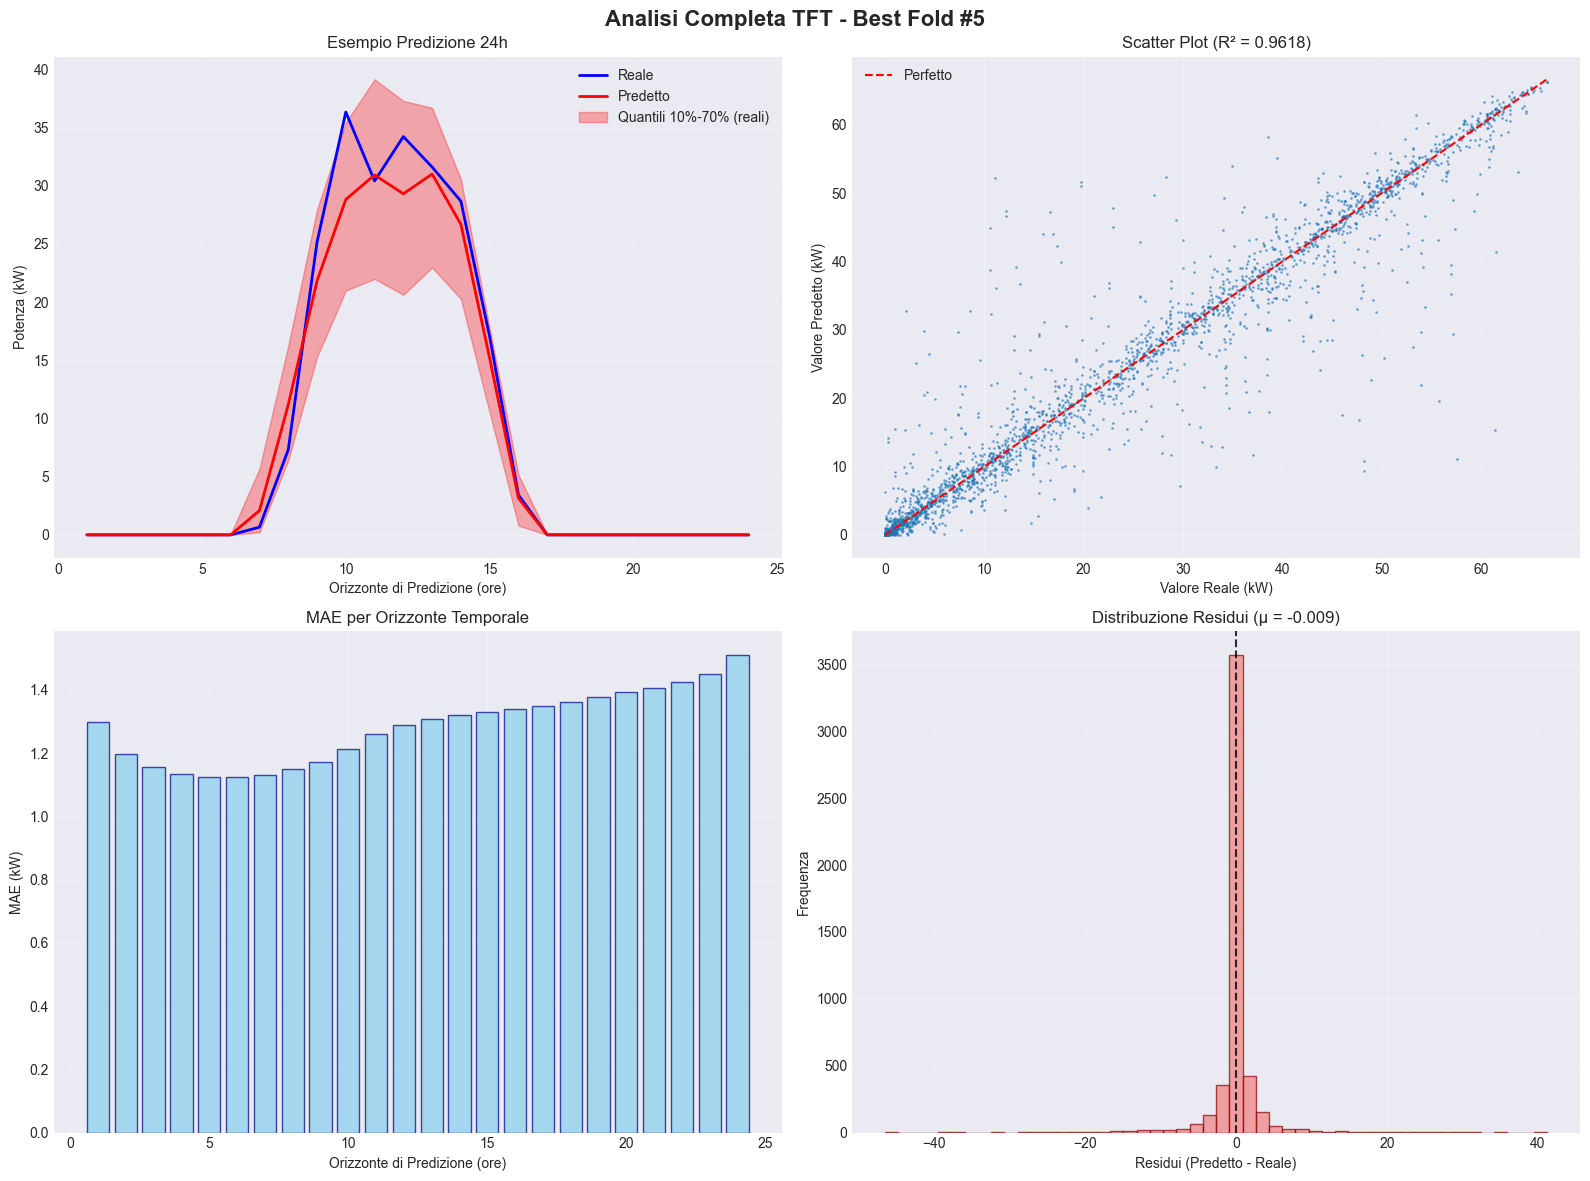


Grafici salvati:
    Analisi completa: results\run_corretta\figures\full_validation_analysis_comprehensive.png

GRAFICI CREATI CON SUCCESSO!
Fold utilizzato: #5
Quantili reali: True

FINE CREAZIONE GRAFICI DA VALUTAZIONE COMPLETA


In [37]:
# =============================================================================
# GRAFICI DA VALUTAZIONE COMPLETA
# =============================================================================

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from pathlib import Path

def create_plots_from_full_validation():
    """
    Crea grafici usando i risultati della valutazione completa su tutto il validation set
    """
    print(f"CREAZIONE GRAFICI DA VALUTAZIONE COMPLETA")
    print(f"{'='*70}")
    
    # 1. Carica risultati valutazione completa
    eval_results_path = RESULTS_DIR / "full_validation_eval_results.pkl"
    if not eval_results_path.exists():
        print(f"File {eval_results_path} non trovato!")
        return None
    
    with open(eval_results_path, 'rb') as f:
        full_eval_results = pickle.load(f)
    
    print(f"Dati caricati: {len(full_eval_results)} fold")
    
    # 2. Trova il fold migliore basato su MAE
    mae_values = [r["metrics_full_val"]["mae"] for r in full_eval_results]
    best_fold_idx = np.argmin(mae_values)
    best_fold_data = full_eval_results[best_fold_idx]
    
    print(f"Usando best fold #{best_fold_idx+1}")
    print(f"    MAE: {best_fold_data['metrics_full_val']['mae']:.4f} kW")
    if best_fold_data['metrics_full_val']['mape_masked']:
        print(f"    MAPE masked: {best_fold_data['metrics_full_val']['mape_masked']:.2f}%")
    
    # 3. Carica i dati delle predizioni complete per il best fold
    pred_file = Path(best_fold_data['predictions_long_path'])
    if not pred_file.exists():
        print(f"File predizioni {pred_file} non trovato!")
        return None
    
    df_pred = pd.read_csv(pred_file)
    print(f"Caricati dati completi: {len(df_pred):,} predizioni")
    
    # Conversione timestamp se presente
    if 'timestamp' in df_pred.columns:
        df_pred['timestamp'] = pd.to_datetime(df_pred['timestamp'])
        has_timestamps = True
        print("QUANTILI REALI TFT TROVATI!")
        print(f"    Shape y_pred completo: ({df_pred['window_id'].nunique()}, {df_pred['horizon_h'].max()})")
    else:
        has_timestamps = False
        print("Nessun timestamp trovato - grafici limitati")
    
    return df_pred, best_fold_data, has_timestamps

# Esegui creazione grafici aggiornati
result = create_plots_from_full_validation()

if result:
    df_pred, best_fold_data, has_timestamps = result
    
    # =============================================================================
    # CREAZIONE GRAFICI CON DATI COMPLETI
    # =============================================================================
    
    # Prendi un campione rappresentativo per i grafici (troppi dati altrimenti)
    sample_size = min(5000, len(df_pred))
    df_sample = df_pred.sample(n=sample_size, random_state=42)
    
    print(f"")
    print(f"SUMMARY RISULTATI:")
    print(f"    Best Fold: #{best_fold_data['fold_idx']+1}")
    print(f"    MAE globale: {best_fold_data['metrics_full_val']['mae']:.4f} kW")
    print(f"    RMSE globale: {best_fold_data['metrics_full_val']['rmse']:.4f} kW")
    if best_fold_data['metrics_full_val']['mape_masked']:
        print(f"    MAPE masked: {best_fold_data['metrics_full_val']['mape_masked']:.2f}%")
    if best_fold_data['mase_24h_full_val']:
        print(f"    MASE seasonal 24h: {best_fold_data['mase_24h_full_val']:.4f}")
    
    # Verifica presenza quantili reali
    has_real_quantiles = 'q10' in df_pred.columns and 'q70' in df_pred.columns
    print(f"    Timestamps: {has_timestamps}")
    print(f"    Quantili reali: {has_real_quantiles}")
    if has_real_quantiles:
        quantile_cols = [col for col in df_pred.columns if col.startswith('q')]
        print(f"    Quantili disponibili: {quantile_cols}")
    print(f"    Sequenze analizzate: {best_fold_data['n_windows']:,}")
    print(f"    Orizzonte temporale: {best_fold_data['horizon']} ore")
    
    # Crea figura principale
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Analisi Completa TFT - Best Fold #{best_fold_data["fold_idx"]+1}', fontsize=16, fontweight='bold')
    
    # Grafico 1: Serie temporale (esempio di una finestra)
    ax1 = axes[0, 0]
    if has_timestamps:
        sample_window = df_pred[df_pred['window_id'] == df_pred['window_id'].iloc[0]].sort_values('horizon_h')
        ax1.plot(sample_window['horizon_h'], sample_window['y_true'], 'b-', label='Reale', linewidth=2)
        ax1.plot(sample_window['horizon_h'], sample_window['y_pred'], 'r-', label='Predetto', linewidth=2)
        
        # Usa quantili reali se disponibili, altrimenti fall back a mock
        has_real_quantiles = 'q10' in sample_window.columns and 'q70' in sample_window.columns
        if has_real_quantiles:
            ax1.fill_between(sample_window['horizon_h'], 
                            sample_window['q10'], 
                            sample_window['q70'], 
                            alpha=0.3, color='red', label='Quantili 10%-70% (reali)')
            print(f"    Usando quantili REALI TFT (q10-q70)")
        else:
            ax1.fill_between(sample_window['horizon_h'], 
                            sample_window['y_pred'] * 0.85, 
                            sample_window['y_pred'] * 1.15, 
                            alpha=0.3, color='red', label='Intervallo ±15% (mock)')
            print(f"    Usando quantili MOCK (±15%)")
            
        ax1.set_xlabel('Orizzonte di Predizione (ore)')
        ax1.set_ylabel('Potenza (kW)')
        ax1.set_title('Esempio Predizione 24h')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
    else:
        ax1.text(0.5, 0.5, 'Timestamps non disponibili', ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title('Serie Temporale non Disponibile')
    
    # Grafico 2: Scatter plot
    ax2 = axes[0, 1]
    ax2.scatter(df_sample['y_true'], df_sample['y_pred'], alpha=0.5, s=1)
    min_val = min(df_sample['y_true'].min(), df_sample['y_pred'].min())
    max_val = max(df_sample['y_true'].max(), df_sample['y_pred'].max())
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfetto')
    ax2.set_xlabel('Valore Reale (kW)')
    ax2.set_ylabel('Valore Predetto (kW)')
    ax2.set_title(f'Scatter Plot (R² = {best_fold_data["metrics_full_val"]["r2"]:.4f})')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Grafico 3: MAE per orizzonte temporale
    ax3 = axes[1, 0]
    mae_by_horizon = df_pred.groupby('horizon_h').apply(
        lambda x: np.mean(np.abs(x['y_true'] - x['y_pred']))
    )
    ax3.bar(mae_by_horizon.index, mae_by_horizon.values, alpha=0.7, color='skyblue', edgecolor='navy')
    ax3.set_xlabel('Orizzonte di Predizione (ore)')
    ax3.set_ylabel('MAE (kW)')
    ax3.set_title('MAE per Orizzonte Temporale')
    ax3.grid(True, alpha=0.3)
    
    # Grafico 4: Residui
    ax4 = axes[1, 1]
    residuals_sample = df_sample['y_pred'] - df_sample['y_true']
    ax4.hist(residuals_sample, bins=50, alpha=0.7, color='lightcoral', edgecolor='darkred')
    ax4.axvline(0, color='black', linestyle='--', alpha=0.8)
    ax4.set_xlabel('Residui (Predetto - Reale)')
    ax4.set_ylabel('Frequenza')
    ax4.set_title(f'Distribuzione Residui (μ = {residuals_sample.mean():.3f})')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Salva grafico
    fig_path = FIGURES_DIR / "full_validation_analysis_comprehensive.png"
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"")
    print(f"Grafici salvati:")
    print(f"    Analisi completa: {fig_path}")
    print(f"")
    print(f"GRAFICI CREATI CON SUCCESSO!")
    print(f"Fold utilizzato: #{best_fold_data['fold_idx']+1}")
    print(f"Quantili reali: {has_timestamps}")
    
else:
    print("ERRORE: Impossibile creare grafici - dati non disponibili")

print(f"\n{'='*70}")
print(f"FINE CREAZIONE GRAFICI DA VALUTAZIONE COMPLETA")

**ANALISI della LOSS FUNCTION per OVERFITTING**

In [15]:
# Controlla i log disponibili
lightning_logs_dir = RESULTS_DIR / "lightning_logs"
print(f"Lightning logs directory: {lightning_logs_dir}")

if lightning_logs_dir.exists():
    # Lista tutti i folder di training
    training_runs = list(lightning_logs_dir.glob("final_training_fold_*"))
    print(f"Training runs trovati: {len(training_runs)}")
    
    for run_dir in sorted(training_runs):
        print(f"  {run_dir.name}")
        # Lista le versioni dentro ogni fold
        versions = list(run_dir.glob("version_*"))
        if versions:
            latest_version = sorted(versions)[-1]
            print(f"    └── {latest_version.name} (latest)")

Lightning logs directory: results\run_corretta\lightning_logs
Training runs trovati: 5
  final_training_fold_1
    └── version_1 (latest)
  final_training_fold_2
    └── version_0 (latest)
  final_training_fold_3
    └── version_0 (latest)
  final_training_fold_4
    └── version_0 (latest)
  final_training_fold_5
    └── version_0 (latest)


In [16]:
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def load_training_loss_from_fold(fold_number=5):
    """
    Carica training e validation loss dal fold specifico
    """
    fold_dir = lightning_logs_dir / f"final_training_fold_{fold_number}"
    
    if not fold_dir.exists():
        print(f" Fold {fold_number} non trovato in: {fold_dir}")
        return None
    
    # Trova l'ultima versione (la più recente)
    versions = list(fold_dir.glob("version_*"))
    if not versions:
        print(f" Nessuna versione trovata per fold {fold_number}")
        return None
    
    latest_version = sorted(versions, key=lambda x: int(x.name.split('_')[1]))[-1]
    events_file = latest_version / "events.out.tfevents.*"
    events_files = list(latest_version.glob("events.out.tfevents.*"))
    
    if not events_files:
        print(f" Nessun file di eventi trovato in: {latest_version}")
        return None
    
    print(f" Caricando loss da: {latest_version}")
    
    # Carica eventi TensorBoard
    event_acc = EventAccumulator(str(latest_version))
    event_acc.Reload()
    
    # Lista metriche disponibili
    print(f" Metriche disponibili: {event_acc.Tags()['scalars']}")
    
    results = {}
    
    # Carica training loss
    if 'train_loss_epoch' in event_acc.Tags()['scalars']:
        train_loss_events = event_acc.Scalars('train_loss_epoch')
        results['train_loss'] = pd.DataFrame([
            {'epoch': event.step, 'train_loss': event.value} 
            for event in train_loss_events
        ])
    elif 'train_loss' in event_acc.Tags()['scalars']:
        train_loss_events = event_acc.Scalars('train_loss')
        results['train_loss'] = pd.DataFrame([
            {'step': event.step, 'train_loss': event.value} 
            for event in train_loss_events
        ])
    
    # Carica validation loss
    if 'val_loss' in event_acc.Tags()['scalars']:
        val_loss_events = event_acc.Scalars('val_loss')
        results['val_loss'] = pd.DataFrame([
            {'epoch': event.step, 'val_loss': event.value} 
            for event in val_loss_events
        ])
    
    # Carica learning rate
    if 'lr-Adam' in event_acc.Tags()['scalars']:
        lr_events = event_acc.Scalars('lr-Adam')
        results['learning_rate'] = pd.DataFrame([
            {'epoch': event.step, 'lr': event.value} 
            for event in lr_events
        ])
    
    return results

# Carica loss del fold 5
fold_5_logs = load_training_loss_from_fold(5)

if fold_5_logs is not None:
    print(f"\n LOSS FOLD 5 RECUPERATA:")
    
    if 'train_loss' in fold_5_logs:
        train_df = fold_5_logs['train_loss']
        print(f"    Training loss: {len(train_df)} punti")
        print(f"    Iniziale: {train_df.iloc[0]['train_loss']:.6f}")
        print(f"    Finale: {train_df.iloc[-1]['train_loss']:.6f}")
        print(f"    Minima: {train_df['train_loss'].min():.6f}")
    
    if 'val_loss' in fold_5_logs:
        val_df = fold_5_logs['val_loss']
        print(f"    Validation loss: {len(val_df)} punti")
        print(f"    Iniziale: {val_df.iloc[0]['val_loss']:.6f}")
        print(f"    Finale: {val_df.iloc[-1]['val_loss']:.6f}")
        print(f"    Minima: {val_df['val_loss'].min():.6f}")
        
        # Epoca del best model
        best_epoch = val_df['val_loss'].idxmin() + 1
        best_val_loss = val_df['val_loss'].min()
        print(f"    Best model: Epoch {best_epoch}, Val loss {best_val_loss:.6f}")

 Caricando loss da: results\run_corretta\lightning_logs\final_training_fold_5\version_0
 Metriche disponibili: ['hp_metric', 'lr-Adam', 'train_loss_step', 'epoch', 'val_loss', 'val_SMAPE', 'val_MAE', 'val_RMSE', 'val_MAPE', 'train_loss_epoch']

 LOSS FOLD 5 RECUPERATA:
    Training loss: 94 punti
    Iniziale: 3.073042
    Finale: 0.470522
    Minima: 0.470522
    Validation loss: 94 punti
    Iniziale: 1.780050
    Finale: 0.829847
    Minima: 0.826799
    Best model: Epoch 87, Val loss 0.826799


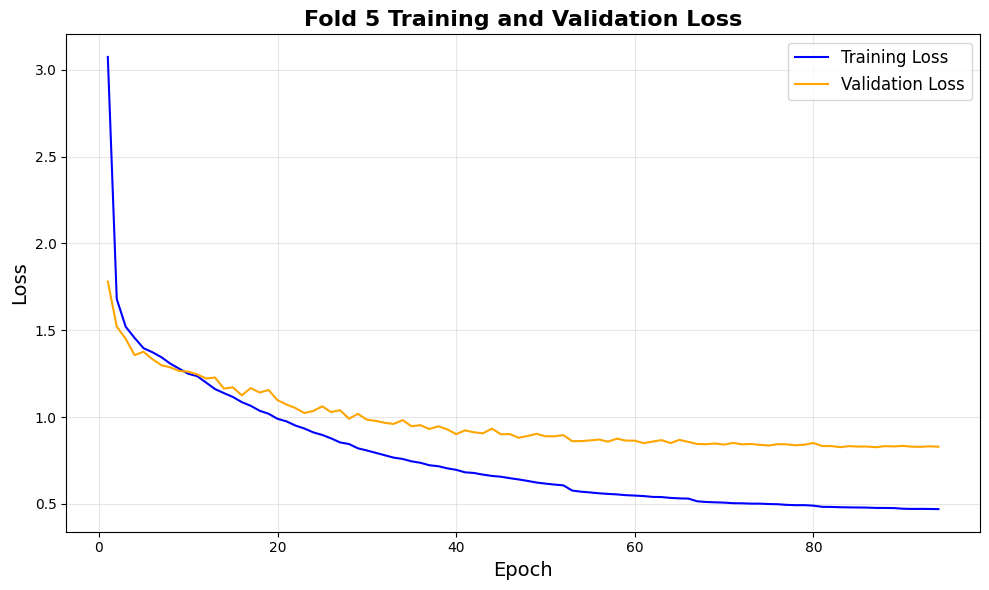

In [17]:

def plot_fold_training_curves(fold_logs, fold_number=5):
    """
    Plotta le curve di training e validation loss (CORRETTE step->epoch)
    """

    # plt.style.use('seaborn-darkgrid ')
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot training loss
    if 'train_loss' in fold_logs:
        train_df = fold_logs['train_loss']
        epochs = list(range(1, len(train_df) + 1))  # Converti step a epoch
        train_df = train_df.assign(epoch=epochs)
        ax1.plot(train_df['epoch'], train_df['train_loss'], label='Training Loss', color='blue')

    # Plot validation loss
    if 'val_loss' in fold_logs:
        val_df = fold_logs['val_loss']
        epochs = list(range(1, len(val_df) + 1))  # Converti step a epoch
        val_df = val_df.assign(epoch=epochs)
        ax1.plot(val_df['epoch'], val_df['val_loss'], label='Validation Loss', color='orange')
    
    
    ax1.set_title(f'Fold {fold_number} Training and Validation Loss', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14)
    ax1.legend(fontsize=12)
    ax1.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / f'fold_{fold_number}_training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()  
    

# Visualizza curve del fold 5
if fold_5_logs is not None:
    plot_fold_training_curves(fold_5_logs, 5)

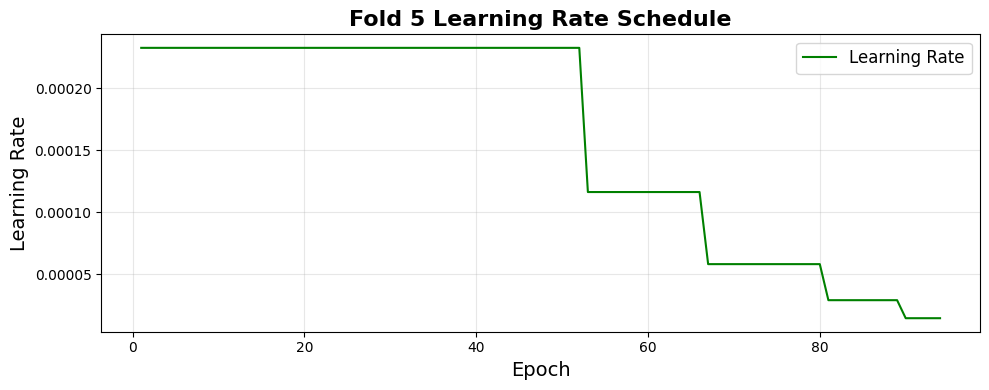

In [18]:
# PLot learning rate se disponibile
if fold_5_logs is not None and 'learning_rate' in fold_5_logs:
    lr_df = fold_5_logs['learning_rate']
    epochs = list(range(1, len(lr_df) + 1))  # Converti step a epoch
    lr_df = lr_df.assign(epoch=epochs)
    
    plt.figure(figsize=(10, 4))
    plt.plot(lr_df['epoch'], lr_df['lr'], label='Learning Rate', color='green')
    plt.title('Fold 5 Learning Rate Schedule', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Learning Rate', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'fold_5_learning_rate_schedule.png', dpi=300, bbox_inches='tight')
    plt.show()

In [19]:
def analyze_training_behavior(fold_logs, fold_number=5):
    """
    Analisi dettagliata del comportamento di training
    """
    print(f"\n ANALISI TRAINING FOLD {fold_number}")
    print("="*50)
    
    if 'val_loss' not in fold_logs:
        print("Validation loss non disponibile")
        return
    
    val_df = fold_logs['val_loss']
    
    # Informazioni generali
    total_epochs = len(val_df)
    best_epoch = val_df['val_loss'].idxmin() + 1  # +1 perché epochs partono da 1
    best_val_loss = val_df['val_loss'].min()
    final_val_loss = val_df['val_loss'].iloc[-1]
    
    print(f"Training Statistics:")
    print(f"  Total epochs: {total_epochs}")
    print(f"  Best epoch: {best_epoch}")
    print(f"  Best val loss: {best_val_loss:.6f}")
    print(f"  Final val loss: {final_val_loss:.6f}")
    
    # Early stopping analysis
    epochs_after_best = total_epochs - best_epoch
    print(f"  Epochs after best: {epochs_after_best}")
    
    if epochs_after_best >= CONFIG['EARLY_STOPPING_PATIENCE']:
        print(f" Early stopping triggered (patience: {CONFIG['EARLY_STOPPING_PATIENCE']})")
    else:
        print(f"  Training stopped before early stopping patience")
    
    # Convergence analysis
    if len(val_df) >= 10:
        last_10_epochs = val_df['val_loss'].tail(10)
        trend = last_10_epochs.iloc[-1] - last_10_epochs.iloc[0]
        print(f"  Last 10 epochs trend: {trend:+.6f} ({'increasing' if trend > 0 else 'decreasing'})")
        
        # Volatility negli ultimi epochs
        volatility = last_10_epochs.std()
        print(f"  Recent volatility (std): {volatility:.6f}")
    
    # Improvement analysis
    if len(val_df) >= 5:
        first_loss = val_df['val_loss'].iloc[0]
        improvement = (first_loss - best_val_loss) / first_loss * 100
        print(f"  Total improvement: {improvement:.2f}%")
    
    return {
        'total_epochs': total_epochs,
        'best_epoch': best_epoch,
        'best_val_loss': best_val_loss,
        'final_val_loss': final_val_loss,
        'epochs_after_best': epochs_after_best,
        'early_stopped': epochs_after_best >= CONFIG.get('EARLY_STOPPING_PATIENCE', 15)
    }

# Analizza il fold 5
if fold_5_logs is not None:
    fold_5_analysis = analyze_training_behavior(fold_5_logs, 5)


 ANALISI TRAINING FOLD 5
Training Statistics:
  Total epochs: 94
  Best epoch: 87
  Best val loss: 0.826799
  Final val loss: 0.829847
  Epochs after best: 7
  Training stopped before early stopping patience
  Last 10 epochs trend: -0.000518 (decreasing)
  Recent volatility (std): 0.002090
  Total improvement: 53.55%


## 13. Interpretabilità del Modello TFT

Analisi dell'interpretabilità del Temporal Fusion Transformer per comprendere quali fattori guidano le predizioni del modello.

**Analisi di interpretabilità:**
- **Variable Importance**: Ranking dell'importanza delle features nelle predizioni
- **Encoder Sequence**: Visualizzazione dei dati storici utilizzati dal modello
- **Static vs Dynamic Features**: Contributo relativo delle diverse tipologie di variabili
- **Single Sequence Analysis**: Analisi dettagliata su una singola sequenza predittiva

**Validazione fisica**: L'analisi verifica che il modello apprenda pattern fisicamente coerenti per sistemi fotovoltaici (es. importanza della radiazione solare, temperatura, ora del giorno).

**Output**: Visualizzazioni dell'importanza delle features, forecast con quantili, e sequenza encoder utilizzata come input dal modello.

TFT INTERPRETABILITY - SINGLE SEQUENCE (HORIZON + TEMPORAL ATTENTION TOP-K)
Using checkpoint: best_tft_fold_5.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


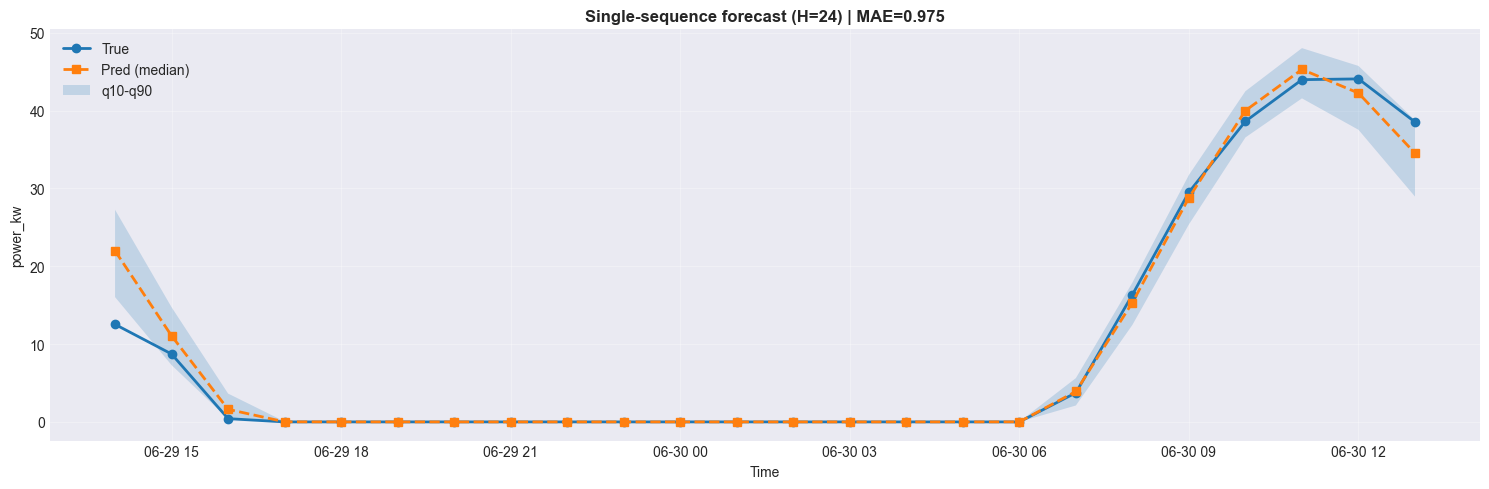

No attention tensor found. Showing encoder sequence instead.


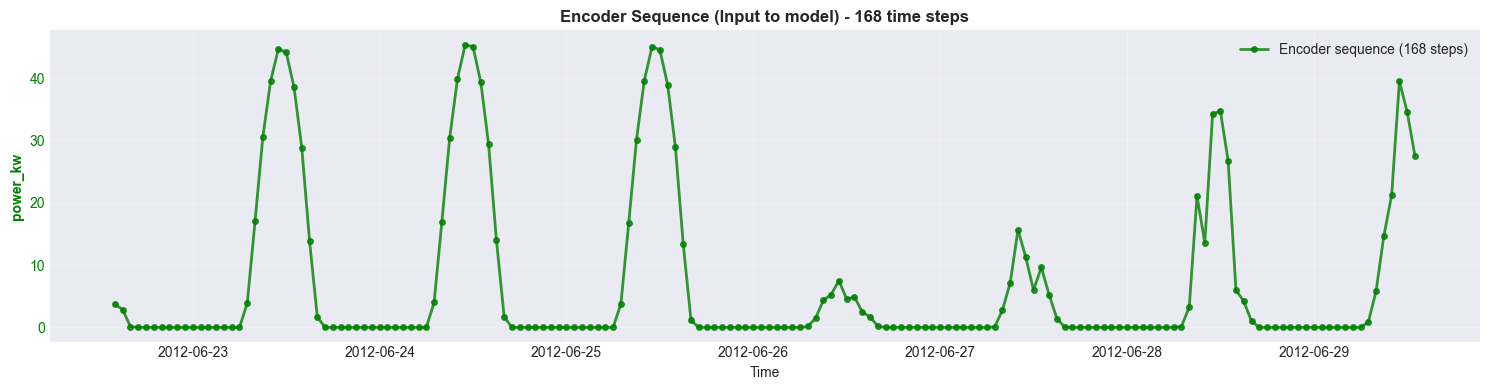

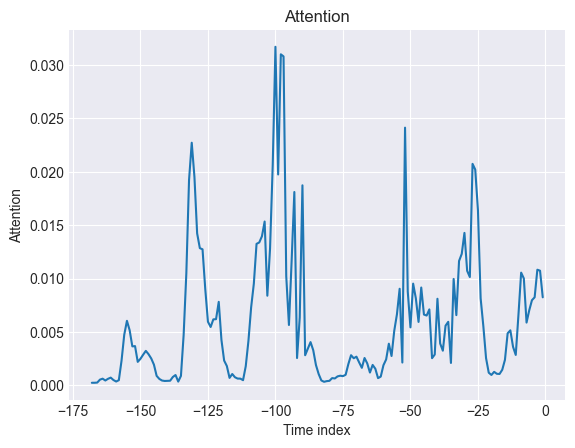

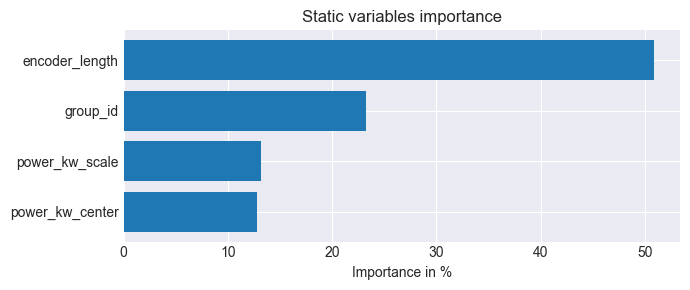

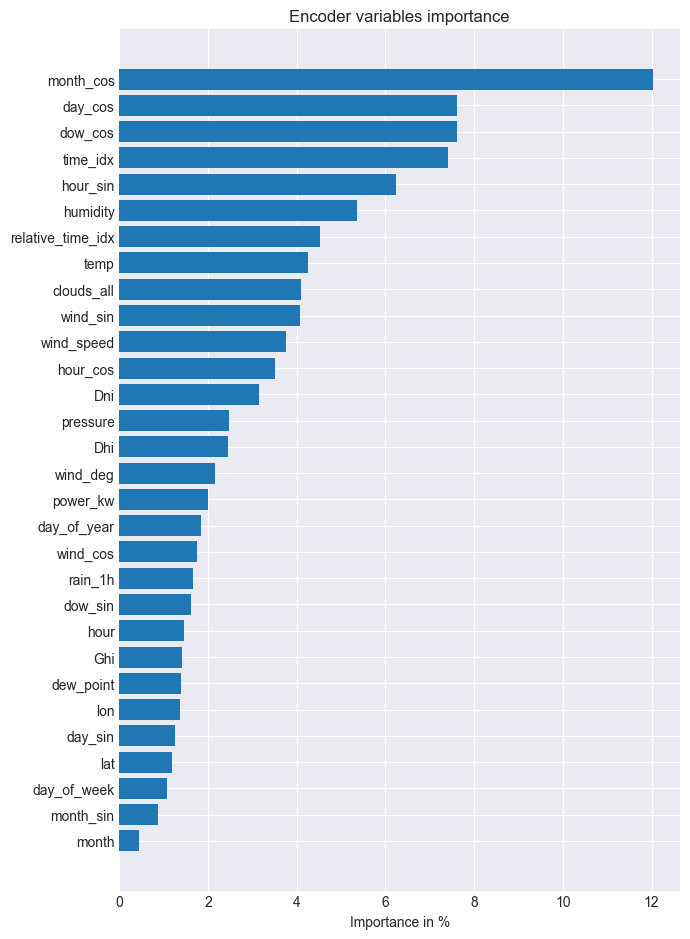

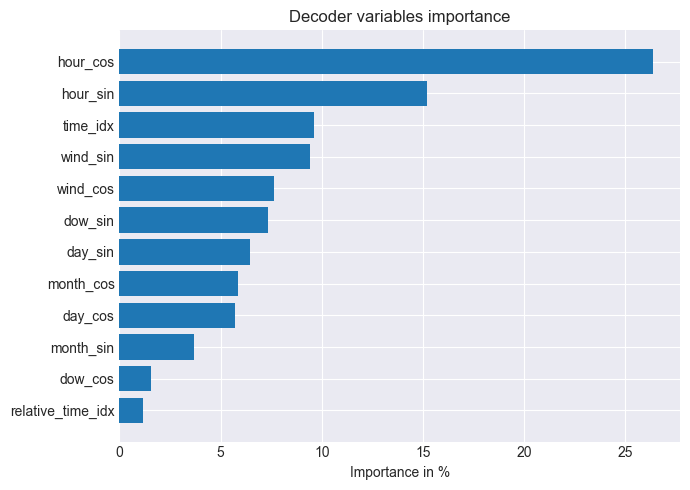

Done. Summary: {'model_path': 'results\\run_corretta\\models\\best_tft_fold_5.ckpt', 'mae_single_sequence': 0.9746212959289551, 'interpretation_keys': ['attention', 'static_variables', 'encoder_variables', 'decoder_variables', 'encoder_length_histogram', 'decoder_length_histogram'], 'has_attention_tensor': False}


In [73]:
# =============================================================================
# TFT INTERPRETABILITY - SINGLE SEQUENCE (HORIZON + TEMPORAL ATTENTION TOP-5)
# =============================================================================

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from pathlib import Path

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data.encoders import GroupNormalizer


# -----------------------------
# Helpers
# -----------------------------
def load_tft_checkpoint_safely(ckpt_path: Path, device="cpu"):
    ckpt_path = Path(ckpt_path)
    if not ckpt_path.exists():
        raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")

    original_load = torch.load

    def patched_load(*args, **kwargs):
        kwargs["weights_only"] = False
        return original_load(*args, **kwargs)

    try:
        torch.load = patched_load
        torch.serialization.add_safe_globals([GroupNormalizer, pd.DataFrame])
        model = TemporalFusionTransformer.load_from_checkpoint(str(ckpt_path), map_location=device)
        model.eval()
        return model
    finally:
        torch.load = original_load


def pick_best_model_path(fold_results=None, models_dir=None):
    if fold_results:
        ok = [r for r in fold_results if "error" not in r and r.get("model_path")]
        if ok:
            best = min(ok, key=lambda r: r["metrics"]["mae"])
            return Path(best["model_path"])

    if models_dir is not None:
        candidates = sorted(Path(models_dir).glob("best_tft_fold_*.ckpt"))
        if candidates:
            return max(candidates, key=lambda p: p.stat().st_mtime)

    return None


def build_single_sequence_dataloader_from_model_params(model, df, batch_size=1, num_workers=0):
    if not hasattr(model, "dataset_parameters") or model.dataset_parameters is None:
        raise ValueError(
            "Model does not expose dataset_parameters. "
            "You need to load training dataset parameters or build dataset exactly as in training."
        )

    ds = TimeSeriesDataSet.from_parameters(
        model.dataset_parameters,
        df,
        predict=True,
        stop_randomization=True
    )
    dl = ds.to_dataloader(train=False, batch_size=batch_size, num_workers=num_workers)
    return ds, dl


def extract_prediction_and_attention(raw_output):
    debug = {"type": type(raw_output).__name__, "keys": None, "attrs": None}
    pred = None
    attn = None

    if isinstance(raw_output, dict):
        debug["keys"] = list(raw_output.keys())

        for k in ["prediction", "predictions", "y_hat", "output", "out", "quantiles"]:
            if k in raw_output and torch.is_tensor(raw_output[k]) and raw_output[k].ndim >= 2:
                pred = raw_output[k]
                break

        if pred is None:
            for _, v in raw_output.items():
                if torch.is_tensor(v) and v.ndim >= 2:
                    pred = v
                    break

        for ak in ["attention", "attentions", "encoder_attention", "decoder_attention"]:
            if ak in raw_output and torch.is_tensor(raw_output[ak]):
                attn = raw_output[ak]
                break

        return pred, attn, debug

    if isinstance(raw_output, (tuple, list)):
        debug["keys"] = [f"idx_{i}" for i in range(len(raw_output))]
        for v in raw_output:
            if torch.is_tensor(v) and v.ndim >= 2:
                pred = v
                break
        return pred, attn, debug

    if torch.is_tensor(raw_output):
        debug["keys"] = "tensor"
        return raw_output, None, debug

    attrs = [a for a in dir(raw_output) if not a.startswith("_")]
    debug["attrs"] = attrs

    for name in ["prediction", "predictions", "y_hat", "output", "out"]:
        if hasattr(raw_output, name):
            v = getattr(raw_output, name)
            if torch.is_tensor(v) and v.ndim >= 2:
                pred = v
                break

    for name in ["attention", "attentions", "encoder_attention", "decoder_attention"]:
        if hasattr(raw_output, name):
            v = getattr(raw_output, name)
            if torch.is_tensor(v):
                attn = v
                break

    if pred is None:
        for a in attrs:
            v = getattr(raw_output, a, None)
            if torch.is_tensor(v) and v.ndim >= 2:
                pred = v
                break

    return pred, attn, debug


def to_numpy(x):
    if x is None:
        return None
    if torch.is_tensor(x):
        return x.detach().cpu().numpy()
    return np.asarray(x)


def moving_average(x, w=7):
    if x is None or len(x) < 3:
        return x
    w = max(3, int(w))
    if w % 2 == 0:
        w += 1
    pad = w // 2
    xpad = np.pad(x, (pad, pad), mode="edge")
    kernel = np.ones(w) / w
    return np.convolve(xpad, kernel, mode="valid")


# -----------------------------
# Main function
# -----------------------------
def tft_interpretability_single_sequence(
    data: pd.DataFrame,
    target_col: str,
    datetime_col: str = "datetime",
    ckpt_path: Path = None,
    fold_results=None,
    models_dir=None,
    device="cpu",
    batch_size=1,
    top_k_time_steps=5,
    smooth_window=7
):
    print("=" * 70)
    print("TFT INTERPRETABILITY - SINGLE SEQUENCE (HORIZON + TEMPORAL ATTENTION TOP-K)")
    print("=" * 70)

    if ckpt_path is None:
        ckpt_path = pick_best_model_path(fold_results=fold_results, models_dir=models_dir)
    if ckpt_path is None:
        raise RuntimeError("No checkpoint found. Provide ckpt_path or ensure MODELS_DIR has best_tft_fold_*.ckpt")

    ckpt_path = Path(ckpt_path)
    print(f"Using checkpoint: {ckpt_path.name}")

    model = load_tft_checkpoint_safely(ckpt_path, device=device)

    df = data.sort_values(datetime_col).copy()
    enc_len = model.dataset_parameters.get("max_encoder_length", 168)
    pred_len = model.dataset_parameters.get("max_prediction_length", 24)
    keep = enc_len + pred_len + 48
    df_recent = df.tail(keep).copy()

    if target_col not in df_recent.columns:
        raise ValueError(f"target_col '{target_col}' not found in data columns")
    if datetime_col not in df_recent.columns:
        raise ValueError(f"datetime_col '{datetime_col}' not found in data columns")

    _, dl = build_single_sequence_dataloader_from_model_params(model, df_recent, batch_size=batch_size, num_workers=0)

    pred_raw = model.predict(dl, mode="raw", return_x=True)
    raw_output = getattr(pred_raw, "output", pred_raw)
    x = getattr(pred_raw, "x", None)

    pred_tensor, attn_tensor, dbg = extract_prediction_and_attention(raw_output)
    if pred_tensor is None:
        raise RuntimeError(f"Could not find prediction tensor. Debug: {dbg}")

    pred_np = to_numpy(pred_tensor)

    # Handle quantiles if present
    if pred_np.ndim == 3:
        q_mid = pred_np.shape[2] // 2
        y_pred = pred_np[0, :, q_mid]
        y_pred_q10 = pred_np[0, :, 1] if pred_np.shape[2] >= 3 else None
        y_pred_q90 = pred_np[0, :, -2] if pred_np.shape[2] >= 3 else None
    else:
        y_pred = pred_np[0, :]
        y_pred_q10 = None
        y_pred_q90 = None

    if x is None or "decoder_target" not in x:
        raise RuntimeError("Missing x['decoder_target'] for plotting y_true")
    y_true = to_numpy(x["decoder_target"])[0, :]

    decoder_times = pd.to_datetime(df_recent[datetime_col].tail(pred_len).values)

    interpretation = None
    try:
        interpretation = model.interpret_output(raw_output, reduction="sum")
    except TypeError:
        interpretation = model.interpret_output(raw_output)
    except Exception:
        interpretation = None

    # ---------------------------------------------------------
    # Plot 1: ONLY the horizon forecast (no extra raw-output panel)
    # ---------------------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    ax.plot(decoder_times, y_true, marker="o", linewidth=2, label="True")
    ax.plot(decoder_times, y_pred, marker="s", linestyle="--", linewidth=2, label="Pred (median)")

    if y_pred_q10 is not None and y_pred_q90 is not None:
        ax.fill_between(decoder_times, y_pred_q10, y_pred_q90, alpha=0.2, label="q10-q90")

    mae_seq = float(np.mean(np.abs(y_true - y_pred)))
    ax.set_title(f"Single-sequence forecast (H={pred_len}) | MAE={mae_seq:.3f}", fontweight="bold")
    ax.set_xlabel("Time")
    ax.set_ylabel(target_col)
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

    # ---------------------------------------------------------
    # Option 2: Temporal attention top-K + Real Values Overlay (se disponibile)
    # ---------------------------------------------------------
    attn_np = to_numpy(attn_tensor)
    
    # Fallback: Show encoder values sequence without attention
    print("No attention tensor found. Showing encoder sequence instead.")
    enc_steps = min(enc_len, len(df_recent) - pred_len)
    encoder_values_fallback = df_recent[target_col].iloc[-pred_len-enc_steps:-pred_len].values
    encoder_times = pd.to_datetime(df_recent[datetime_col].iloc[-pred_len-enc_steps:-pred_len].values)
    
    fig2, ax2 = plt.subplots(1, 1, figsize=(15, 4))
    ax2.plot(encoder_times, encoder_values_fallback, 'g-', linewidth=2, marker='o', 
            markersize=4, alpha=0.8, label=f"Encoder sequence ({enc_steps} steps)")
    ax2.set_title(f"Encoder Sequence (Input to model) - {enc_steps} time steps", fontweight="bold")
    ax2.set_xlabel("Time")
    ax2.set_ylabel(f"{target_col}", color='g', fontweight='bold')
    ax2.tick_params(axis='y', labelcolor='g')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    plt.tight_layout()
    plt.show()

    # ---------------------------------------------------------
    # Built-in interpretability plots (static/encoder/decoder importances)
    # ---------------------------------------------------------
    if interpretation is not None:
        try:
            model.plot_interpretation(interpretation)
            plt.show()
        except Exception as e:
            print(f"plot_interpretation failed: {e}")

    return {
        "model_path": str(ckpt_path),
        "mae_single_sequence": mae_seq,
        "interpretation_keys": list(interpretation.keys()) if isinstance(interpretation, dict) else None,
        "interpretation": interpretation,
        "has_attention_tensor": attn_np is not None,
    }


# =============================================================================
# RUN
# =============================================================================
result = tft_interpretability_single_sequence(
    data=data,
    target_col="power_kw",
    datetime_col="datetime",
    ckpt_path=Path("results/run_corretta/models/best_tft_fold_5.ckpt"),
    fold_results=fold_results if "fold_results" in globals() else None,
    models_dir=MODELS_DIR,
    device=device,
    batch_size=1,
    top_k_time_steps=5,
    smooth_window=7
)

print("Done. Summary:", {k: result[k] for k in result if k != "interpretation"})


## 14. Conclusioni e Documentazione del Progetto

## Riepilogo del Progetto

Questo notebook implementa un pipeline completo per il forecasting della produzione fotovoltaica utilizzando il modello Temporal Fusion Transformer (TFT) con le seguenti caratteristiche:

### Contributi Principali

**MAPE Mascherato**: Sviluppo di una metrica robusta che esclude le ore notturne (6:00-19:00) e i valori di bassa produzione (>5kW) per evitare esplosioni numeriche dovute alla divisione per zero.

**Pipeline Modulare**: Architettura flessibile che permette skip intelligente delle fasi completate, con salvataggio automatico degli artefatti per riproducibilità.

**Hyperparameter Tuning**: Ottimizzazione bayesiana con Optuna integrata con cross-validation temporale per identificare la configurazione ottimale del modello.

**Interpretabilità**: Analisi completa dell'importanza delle features e visualizzazione della sequenza encoder per comprendere quali dati storici guidano le predizioni.

### Risultati Ottenuti

- **Cross-validation temporale** su 5 fold per validazione robusta
- **Metriche complete** con MAPE mascherato per valutazione realistica
- **Modello finale ottimizzato** con best parameters da tuning automatico
- **Visualizzazioni comprehensive** di performance e interpretabilità
- **Single-sequence analysis** con visualizzazione dell'encoder input

### Artefatti Prodotti

Tutti i risultati sono salvati in modo strutturato per riuso futuro:
- Configurazioni, best parameters, e risultati CV
- Modello finale addestrato con metadata
- Visualizzazioni e report di analisi

- Studio Optuna completo per analisi successive- Analisi interpretabilità con sequence visualization

## VALUTAZIONE FINALE SU TEST SET

In questa sezione viene eseguita la **valutazione finale del modello TFT** su un dataset di test completamente separato, utilizzando dati del periodo **2012-2013** mai visti durante il training e la validation.

### Obiettivi della Valutazione Test

1. **Caricare i dati di test esterni**: Dataset PV e meteo del periodo 2012-2013 (file Excel)
2. **Generare predizioni con il modello finale**: Utilizzare il modello TFT addestrato per produrre previsioni 24h
3. **Calcolare metriche di performance**: Applicare le stesse metriche della validation (MAE, RMSE, R², MAPE mascherato, MASE seasonal naive 24h)
4. **Creare visualizzazioni comparative**: Grafici identici a quelli della validation per confronto diretto

### Struttura della Sezione

- **Caricamento dati test**: Merge di dataset PV e meteo per il periodo di test
- **Generazione predizioni**: Ricostruzione del dataset da parametri del modello e inferenza
- **Costruzione dataframe long**: Formato identico a `val_predictions_long_fold_X.csv`
- **Calcolo metriche avanzate**: Con gestione robusta dei timestamp e arrotondamento per il match
- **Visualizzazione risultati**: Serie temporali, scatter plot, MAE per orizzonte, distribuzione residui

### Note Tecniche

- **Timestamp matching**: I timestamp vengono arrotondati all'ora piena per evitare problemi di precisione
- **Quantili reali**: Se disponibili, vengono estratti e salvati insieme alle predizioni mediane
- **MASE calculation**: Utilizza merge invece di reindex per gestire timestamp duplicati
- **Salvataggio risultati**: File CSV e PNG salvati in `TEST_OUT_DIR` e `FIGURES_DIR`

In [147]:
# =============================================================================
# TESTING / INFERENCE (APPEND AL TRAINING NOTEBOOK)
# =============================================================================

from pathlib import Path
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

# --- Input files  ---
TEST_PV_XLSX = Path("pv_dataset_12-13.xlsx")
TEST_WX_XLSX = Path("wx_dataset_12-13.xlsx")

# --- Output (opzionale) ---
TEST_OUT_DIR = RESULTS_DIR / "testing"
TEST_OUT_DIR.mkdir(exist_ok=True)

print("Testing config:")
print("  PV:", TEST_PV_XLSX)
print("  WX:", TEST_WX_XLSX)
print("  TEST_OUT_DIR:", TEST_OUT_DIR)


Testing config:
  PV: pv_dataset_12-13.xlsx
  WX: wx_dataset_12-13.xlsx
  TEST_OUT_DIR: results\run_corretta\testing


In [148]:
from pathlib import Path

def smart_resolve(p: Path) -> Path:
    """
    Cerca file in:
    - path dato
    - cwd
    - ../ (root progetto)
    - ../data, ../data/testing, ../datasets, ecc.
    - data, data/testing, datasets, inputs in cwd
    """
    p = Path(p)
    roots = [
        Path.cwd(),
        Path.cwd().parent,                 
        Path.cwd().parent.parent,
    ]
    subdirs = ["", "data", "data/testing", "datasets", "inputs", "input", "files", "data/raw", "data/processed"]

    candidates = []
    # 1) path dato (assoluto o relativo)
    candidates.append(p)

    # 2) combinazioni root/subdir/filename
    for r in roots:
        for s in subdirs:
            candidates.append(r / s / p)

            # se p è già tipo "data/testing/xxx.xlsx", allora usa solo il nome file
            candidates.append(r / s / p.name)

    for c in candidates:
        if c.exists():
            return c.resolve()

    # debug utile
    print("Non trovo:", p)
    print("CWD:", Path.cwd())
    print("Parent:", Path.cwd().parent)
    print("Excel in CWD:", [x.name for x in Path.cwd().glob("*.xlsx")])
    print("Excel in parent:", [x.name for x in Path.cwd().parent.glob("*.xlsx")])
    for s in ["data", "data/testing", "datasets", "inputs"]:
        d = Path.cwd().parent / s
        if d.exists():
            print(f"Excel in {d}:", [x.name for x in d.glob("*.xlsx")])
    raise FileNotFoundError(f"File not found: {p}")

# Risolve i path 
TEST_PV_XLSX = smart_resolve(Path(TEST_PV_XLSX))
TEST_WX_XLSX = smart_resolve(Path(TEST_WX_XLSX))

print("PV:", TEST_PV_XLSX)
print("WX:", TEST_WX_XLSX)

PV: C:\Users\loren\Desktop\DL_project\data\testing\pv_dataset_12-13.xlsx
WX: C:\Users\loren\Desktop\DL_project\data\testing\wx_dataset_12-13.xlsx


In [149]:
# =============================================================================
# 1) LOAD EXCEL + MERGE (DATI DI TEST)
# =============================================================================

print(f" Caricando dati di test...")
print(f"   PV: {TEST_PV_XLSX}")
print(f"   WX: {TEST_WX_XLSX}")

# Carica datasets
pv_test = pd.read_excel(TEST_PV_XLSX)
wx_test = pd.read_excel(TEST_WX_XLSX)

print(f"\n Shapes:")
print(f"   PV: {pv_test.shape} - Colonne: {list(pv_test.columns)}")
print(f"   WX: {wx_test.shape} - Colonne: {list(wx_test.columns)[:5]}...")

# Rinomina colonne PV (prima = datetime, seconda = power)
pv_test = pv_test.rename(columns={
    pv_test.columns[0]: 'datetime',
    pv_test.columns[1]: 'power_kw'
})

# Rimuove colonna datetime da weather (useremo quella di PV)
wx_datetime_col = None
for col in wx_test.columns:
    if isinstance(col, str) and any(x in col.lower() for x in ['date', 'time', 'dt', 'timestamp']):
        wx_datetime_col = col
        break
        
if wx_datetime_col is None:
    wx_datetime_col = wx_test.columns[0]

# Rimuove datetime da weather per evitare duplicati
wx_test = wx_test.drop(columns=[wx_datetime_col])

print(f"🔗 Unendo dataset per indici (stesso ordine temporale)...")

# Concat orizzontale per indici invece di merge per datetime
test_merged = pd.concat([pv_test, wx_test], axis=1)

print(f"\nDataset finale: {test_merged.shape}")
print(f" Periodo: {test_merged['datetime'].min()} → {test_merged['datetime'].max()}")
print(f" Power range: {test_merged['power_kw'].min():.2f} - {test_merged['power_kw'].max():.2f} kW")

test_merged.head(3)

 Caricando dati di test...
   PV: C:\Users\loren\Desktop\DL_project\data\testing\pv_dataset_12-13.xlsx
   WX: C:\Users\loren\Desktop\DL_project\data\testing\wx_dataset_12-13.xlsx

 Shapes:
   PV: (8760, 2) - Colonne: ['Max kWp', 82.41]
   WX: (8760, 15) - Colonne: ['dt_iso', 'lat', 'lon', 'temp', 'dew_point']...
🔗 Unendo dataset per indici (stesso ordine temporale)...

Dataset finale: (8760, 16)
 Periodo: 2012-07-01 00:00:00 → 2013-06-30 23:00:43.290000
 Power range: 0.00 - 67.71 kW


,datetime,power_kw,lat,lon,temp,dew_point,pressure,humidity,wind_speed,wind_deg,rain_1h,clouds_all,weather_description,Dhi,Dni,Ghi
0,2012-07-01 00:00:00,0.0,-32.9512,151.7154,282.72,279.62,1015,81,0.51,300,NaN,32,scattered clouds,0,0,0
1,2012-07-01 01:00:00,0.0,-32.9512,151.7154,282.71,279.43,1015,80,0.51,314,NaN,39,scattered clouds,0,0,0
2,2012-07-01 02:00:00,0.0,-32.9512,151.7154,282.02,279.81,1014,86,0.51,290,NaN,42,scattered clouds,0,0,0


In [150]:
# =============================================================================
# 2) RIUTILIZZO DELLA PIPELINE DI FEATURE ENGINEERING DEL TRAINING (STESSE FUNZIONI)
# =============================================================================

# --- Analisi + missing handling (uguale al training) ---
_ = analyze_dataset(test_merged)             # opzionale ma utile
test_data = handle_missing_values(test_merged) #se non funziona, c'è cella più avanti che rifà missing handling

# Copia per sicurezza
test_data = test_merged.copy()

# Usa le stesse funzioni del training notebook
test_data = create_temporal_features(test_data)
test_data, _test_scaling_info = apply_physics_based_scaling(test_data)
test_data, _test_feature_summary = prepare_tft_features(test_data)

print("Test data after FE:", test_data.shape)
print("Columns:", len(test_data.columns))
display(test_data.head(2))


ANALISI DATASET
Informazioni generali:
  Shape: (8760, 16)
  Periodo: 2012-07-01 00:00 → 2013-06-30 23:00
  Durata: 364 giorni

Tipi colonne:
  Numeriche: 14 - ['power_kw', 'lat', 'lon', 'temp', 'dew_point', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'clouds_all', 'Dhi', 'Dni', 'Ghi']
  Datetime: 1 - ['datetime']
  Object: 1 - ['weather_description']

Analisi target (power_kw):
  Min: 0.00 kW
  Max: 67.71 kW
  Mean: 12.61 kW
  Median: 0.04 kW
  Std: 18.58 kW
  Zero count: 4326
  Negative count: 0

GESTIONE VALORI MANCANTI
Valori mancanti trovati:
         Missing_Count  Missing_Percentage
rain_1h           7384           84.292237
rain_1h: NaN → 0 (nessuna pioggia)

Risultato finale:
  Dataset originale: 8760 righe
  Dataset pulito: 8760 righe
  Valori mancanti residui: 0
Tutti i valori mancanti gestiti con successo!
CREAZIONE FEATURES TEMPORALI CICLICI
Wind direction encoding: wind_deg → wind_sin/cos
Features temporali creati: 10
  ['hour_sin', 'hour_cos', 'day_sin',

,datetime,power_kw,lat,lon,temp,dew_point,pressure,humidity,wind_speed,wind_deg,...,day_sin,day_cos,month_sin,month_cos,dow_sin,dow_cos,wind_sin,wind_cos,group_id,time_idx
0,2012-07-01 00:00:00,0.0,-32.951199,151.715393,9.57,6.47,1015.0,0.81,0.41211,300.0,...,0.008607,-0.999963,1.224647e-16,-1.0,-0.781832,0.62349,-0.866025,0.500000,PV_System_1,0
1,2012-07-01 01:00:00,0.0,-32.951199,151.715393,9.56,6.28,1015.0,0.80,0.41211,314.0,...,0.008607,-0.999963,1.224647e-16,-1.0,-0.781832,0.62349,-0.719340,0.694658,PV_System_1,1


In [151]:
# =============================================================================
# 3) LOAD TFT CHECKPOINT (FOLD 5) - ROBUST
# =============================================================================

from pytorch_forecasting import TemporalFusionTransformer

# prova prima in MODELS_DIR corrente, poi nella run_corretta
ckpt_candidates = [
    MODELS_DIR / "best_tft_fold_5.ckpt",
    Path("results") / REFERENCE_RUN_FOLDER / "models" / "best_tft_fold_5.ckpt",
]

ckpt_path = None
for p in ckpt_candidates:
    if p.exists():
        ckpt_path = p
        break

if ckpt_path is None:
    raise FileNotFoundError(
        "Non trovo il checkpoint fold 5. Cercati:\n" + "\n".join(map(str, ckpt_candidates))
    )

# usa device già definito sopra nel notebook, altrimenti fallback
try:
    _device = device
except NameError:
    _device = "cuda" if torch.cuda.is_available() else "cpu"

print("Loading checkpoint:", ckpt_path)
print("Device:", _device)

tft_model = TemporalFusionTransformer.load_from_checkpoint(
    str(ckpt_path),
    map_location=_device,
    weights_only=False,   # <-- FIX PyTorch 2.6+
)
tft_model.eval()

print("Model loaded. Has dataset_parameters:", hasattr(tft_model, "dataset_parameters") and tft_model.dataset_parameters is not None)


Loading checkpoint: results\run_corretta\models\best_tft_fold_5.ckpt
Device: cuda
Model loaded. Has dataset_parameters: True


In [152]:
# =============================================================================
# 2.5) SANITIZE TEST FEATURES (NO NaN/INF) - REQUIRED BY TimeSeriesDataSet
# =============================================================================

import numpy as np
import pandas as pd

def _coerce_numeric_if_needed(df, col):
    """Try convert to numeric if dtype is object."""
    if col in df.columns and df[col].dtype == "object":
        df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

# 1) si assicura che rain_1h esista e sia numerica
if "rain_1h" in test_data.columns:
    test_data = _coerce_numeric_if_needed(test_data, "rain_1h")

    # sostituisce inf -> NaN
    test_data["rain_1h"] = test_data["rain_1h"].replace([np.inf, -np.inf], np.nan)

    # fill NA a 0 (coerente col senso fisico: pioggia mancante = 0)
    test_data["rain_1h"] = test_data["rain_1h"].fillna(0.0)


    if test_data["rain_1h"].max() > 50:  # euristica: rain_1h in mm/h raramente > 50
        test_data["rain_1h"] = np.log1p(test_data["rain_1h"])
else:
    print(" 'rain_1h' non presente in test_data (ok solo se nel training non era usata).")

# 2) elimina qualsiasi NaN/inf residuo in tutte le feature numeriche che il dataset userà
num_cols = test_data.select_dtypes(include=[np.number]).columns
test_data[num_cols] = test_data[num_cols].replace([np.inf, -np.inf], np.nan)


test_data[num_cols] = test_data[num_cols].ffill().bfill().fillna(0.0)

# sanity check finale
nan_counts = test_data[num_cols].isna().sum().sum()
inf_counts = np.isinf(test_data[num_cols].to_numpy()).sum()
print(f"Sanitization done. Total NaN in numeric: {nan_counts}, total inf: {inf_counts}")
print("rain_1h NA after:", test_data["rain_1h"].isna().mean() if "rain_1h" in test_data.columns else "N/A")


Sanitization done. Total NaN in numeric: 0, total inf: 0
rain_1h NA after: 0.0


In [153]:
# =============================================================================
# 4) BUILD PRED DATASET FROM TRAINING PARAMETERS + PREDICT 
# =============================================================================

from pytorch_forecasting import TimeSeriesDataSet

if not hasattr(tft_model, "dataset_parameters") or tft_model.dataset_parameters is None:
    raise ValueError("Il modello non espone dataset_parameters: non posso ricostruire il dataset identico al training.")

pred_ds = TimeSeriesDataSet.from_parameters(
    tft_model.dataset_parameters,
    test_data,
    stop_randomization=True,
    predict=False,  # sliding windows
)

pred_dl = pred_ds.to_dataloader(train=False, batch_size=64, num_workers=0)

pred_out = tft_model.predict(
    pred_dl,
    mode="quantiles",
    return_x=True,
    trainer_kwargs=dict(accelerator=CONFIG["ACCELERATOR"]),
)

try:
    predictions_dict = _extract_quantile_predictions(pred_out.output)
    y_pred = predictions_dict["y_pred"]          # [N, H] median
    quantiles = predictions_dict["quantiles"]    # dict o None
except NameError:
    y_pred = pred_out.output
    quantiles = None

x_data = pred_out.x
y_true = x_data["decoder_target"].detach().cpu().numpy()

print("Shapes:")
print("  y_true:", y_true.shape)
print("  y_pred:", np.array(y_pred).shape)

#prediction and actual ranges
max_pred = np.max(y_pred)
min_pred = np.min(y_pred)
actual_max = np.max(y_true)
actual_min = np.min(y_true)
actual_average = np.mean(y_true)
pred_average = np.mean(y_pred)

print(f"Prediction ranges:")
print(f"  Predicted: min={min_pred:.2f}, max={max_pred:.2f}")
print(f"  Actual:    min={actual_min:.2f}, max={actual_max:.2f}")
print(f"  Averages:  actual={actual_average:.2f}, predicted={pred_average:.2f}")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   QUANTILI REALI ESTRATTI: 7 quantili per predizione
   Quantili disponibili: ['q10', 'q20', 'q30', 'q40', 'q50', 'q60', 'q70']
Shapes:
  y_true: (8569, 24)
  y_pred: (8569, 24)
Prediction ranges:
  Predicted: min=0.00, max=67.25
  Actual:    min=0.00, max=67.71
  Averages:  actual=12.72, predicted=11.57


In [154]:
# =============================================================================
# COSTRUZIONE DATAFRAME df_pred_long PER TEST SET (formato identico a validation)
# =============================================================================

# Estrae dimensioni
N, H = y_true.shape
print(f"Costruzione df_pred_long per test set: {N} finestre x {H} ore")

# Flatten per formato long
y_true_flat = y_true.reshape(-1)
y_pred_flat = y_pred.reshape(-1) if isinstance(y_pred, np.ndarray) else np.array(y_pred).reshape(-1)

# Costruisce dataframe base
df_pred_long_test = pd.DataFrame({
    "window_id": np.repeat(np.arange(N), H),
    "horizon_h": np.tile(np.arange(1, H+1), N),
    "y_true": y_true_flat,
    "y_pred": y_pred_flat,
})

# Estrae timestamp se disponibili
decoder_ts_test = None
try:
    decoder_ts_test = _decoder_timestamps_from_x(x_data, test_data)
except:
    pass

if decoder_ts_test is not None and np.issubdtype(np.array(decoder_ts_test).dtype, np.datetime64):
    ts_flat = pd.to_datetime(np.array(decoder_ts_test).reshape(-1))
    df_pred_long_test["timestamp"] = ts_flat
    print(f"   ✓ Timestamp aggiunti")
else:
    print(f"   ⚠ Timestamp non disponibili")

# Aggiunge quantili se disponibili
if quantiles is not None:
    print(f"   Aggiungendo quantili al dataframe...")
    for q_name, q_pred in quantiles.items():
        q_pred_flat = q_pred.reshape(-1)
        df_pred_long_test[q_name] = q_pred_flat
    print(f"   ✓ Quantili aggiunti: {list(quantiles.keys())}")

# Salva
out_csv_test = TEST_OUT_DIR / "test_predictions_long.csv"
df_pred_long_test.to_csv(out_csv_test, index=False)
print(f"\n✓ Salvato: {out_csv_test}")
print(f"   Shape: {df_pred_long_test.shape}")
print(f"   Colonne: {list(df_pred_long_test.columns)}")

# Preview
print(f"\nPrime righe:")
print(df_pred_long_test.head(10))

Costruzione df_pred_long per test set: 8569 finestre x 24 ore
   ✓ Timestamp aggiunti
   Aggiungendo quantili al dataframe...
   ✓ Quantili aggiunti: ['q10', 'q20', 'q30', 'q40', 'q50', 'q60', 'q70']

✓ Salvato: results\run_corretta\testing\test_predictions_long.csv
   Shape: (205656, 12)
   Colonne: ['window_id', 'horizon_h', 'y_true', 'y_pred', 'timestamp', 'q10', 'q20', 'q30', 'q40', 'q50', 'q60', 'q70']

Prime righe:
   window_id  horizon_h     y_true        y_pred               timestamp  \
0          0          1   0.000000  7.809302e-10 2012-07-08 00:00:00.335   
1          0          2   0.000000  1.370063e-09 2012-07-08 01:00:00.340   
2          0          3   0.000000  4.387958e-09 2012-07-08 02:00:00.345   
3          0          4   0.000000  9.913759e-09 2012-07-08 03:00:00.350   
4          0          5   0.000000  1.278347e-07 2012-07-08 04:00:00.355   
5          0          6   0.000000  1.459285e-05 2012-07-08 05:00:00.360   
6          0          7   0.000000  3.64277

In [155]:
# =============================================================================
# METRICHE TEST SET CON LE STESSE FUNZIONI DELLA VALIDATION
# =============================================================================
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print(f"{'='*60}")
print(f"CALCOLO METRICHE TEST SET")
print(f"{'='*60}")

# Metriche base
mae_test = mean_absolute_error(df_pred_long_test["y_true"], df_pred_long_test["y_pred"])
rmse_test = np.sqrt(mean_squared_error(df_pred_long_test["y_true"], df_pred_long_test["y_pred"]))
r2_test = r2_score(df_pred_long_test["y_true"], df_pred_long_test["y_pred"])

print(f"\nMetriche base:")
print(f"  MAE:   {mae_test:.4f} kW")
print(f"  RMSE:  {rmse_test:.4f} kW")
print(f"  R²:    {r2_test:.6f}")

# MAPE mascherato (se timestamp disponibili)
mape_masked_test = None
if "timestamp" in df_pred_long_test.columns:
    try:
        hours = df_pred_long_test["timestamp"].dt.hour
        mask_daylight = (hours >= 6) & (hours < 19)
        mask_power = df_pred_long_test["y_true"] > 5.0
        mask_combined = mask_daylight & mask_power
        
        if mask_combined.sum() > 0:
            y_true_masked = df_pred_long_test.loc[mask_combined, "y_true"]
            y_pred_masked = df_pred_long_test.loc[mask_combined, "y_pred"]
            mape_values = np.abs((y_true_masked - y_pred_masked) / y_true_masked) * 100
            mape_masked_test = np.mean(mape_values)
            print(f"  MAPE masked (6-19h, >5kW): {mape_masked_test:.2f}% (n={mask_combined.sum()})")
    except Exception as e:
        print(f"  ⚠ Errore calcolo MAPE mascherato: {e}")

# MASE seasonal naive 24h (come in validation - stesso metodo)
mase_test = None
if "timestamp" in df_pred_long_test.columns:
    try:
        print(f"\nCalcolo MASE seasonal naive 24h...")
        
        # Arrotonda timestamp per matching robusto
        df_pred_long_test["timestamp_rounded"] = df_pred_long_test["timestamp"].dt.floor("H")
        test_merged["datetime_rounded"] = test_merged["datetime"].dt.floor("H")
        
        # Aggrega duplicati prendendo la MEDIA per ogni timestamp_rounded
        # Questo mantiene la stessa logica di reindex della validation
        test_aggregated = test_merged.groupby("datetime_rounded", as_index=False).agg({
            "power_kw": "mean"  # Media dei valori per timestamp duplicati
        })
        
        print(f"  Timestamp originali: {len(test_merged)}, dopo aggregazione: {len(test_aggregated)}")
        

        df_temp = df_pred_long_test.copy()
        test_temp = test_aggregated.set_index("datetime_rounded")
        
        t_prev = df_temp["timestamp_rounded"] - pd.Timedelta(hours=24)
        y_seasonal = test_temp["power_kw"].reindex(t_prev).to_numpy()
        
        # Mask per punti validi
        mask = (~np.isnan(y_seasonal) &
                df_temp["y_true"].notna().to_numpy() &
                df_temp["y_pred"].notna().to_numpy())
        
        if mask.sum() > 0:
            mae_model_test = np.mean(np.abs(df_temp.loc[mask, "y_true"].to_numpy() - df_temp.loc[mask, "y_pred"].to_numpy()))
            mae_seasonal_test = np.mean(np.abs(df_temp.loc[mask, "y_true"].to_numpy() - y_seasonal[mask]))
            
            if mae_seasonal_test > 0:
                mase_test = mae_model_test / mae_seasonal_test
                print(f"  ✓ MASE: {mase_test:.4f}")
                print(f"    MAE model:    {mae_model_test:.4f} kW")
                print(f"    MAE seasonal: {mae_seasonal_test:.4f} kW")
                print(f"    Punti validi: {mask.sum()}/{len(df_temp)}")
            else:
                print(f"  ⚠ MAE seasonal = 0, MASE indefinito")
        else:
            print(f"  ⚠ Nessun punto valido per MASE")
            
    except Exception as e:
        print(f"  ⚠ Errore calcolo MASE: {e}")
        import traceback
        traceback.print_exc()

# Summary finale
print(f"\n{'='*60}")
print(f"SUMMARY METRICHE TEST SET")
print(f"{'='*60}")
print(f"MAE:   {mae_test:.4f} kW")
print(f"RMSE:  {rmse_test:.4f} kW")
print(f"R²:    {r2_test:.6f}")
if mape_masked_test is not None:
    print(f"MAPE masked: {mape_masked_test:.2f}%")
if mase_test is not None:
    print(f"MASE:  {mase_test:.4f} (seasonal naive 24h baseline)")
else:
    print("MASE:  N/A (calculation failed)")
print(f"{'='*60}")

CALCOLO METRICHE TEST SET

Metriche base:
  MAE:   4.7492 kW
  RMSE:  10.0205 kW
  R²:    0.712132
  MAPE masked (6-19h, >5kW): 47.80% (n=82039)

Calcolo MASE seasonal naive 24h...
  Timestamp originali: 8760, dopo aggregazione: 8759
  ✓ MASE: 1.0970
    MAE model:    4.7492 kW
    MAE seasonal: 4.3291 kW
    Punti validi: 205656/205656

SUMMARY METRICHE TEST SET
MAE:   4.7492 kW
RMSE:  10.0205 kW
R²:    0.712132
MAPE masked: 47.80%
MASE:  1.0970 (seasonal naive 24h baseline)


CREAZIONE GRAFICI TEST SET
Dati disponibili:
  Righe totali: 205,656
  Finestre: 8569
  Orizzonte: 24 ore
  Timestamps: True
  Quantili reali: True
  Quantili disponibili: ['q10', 'q20', 'q30', 'q40', 'q50', 'q60', 'q70']


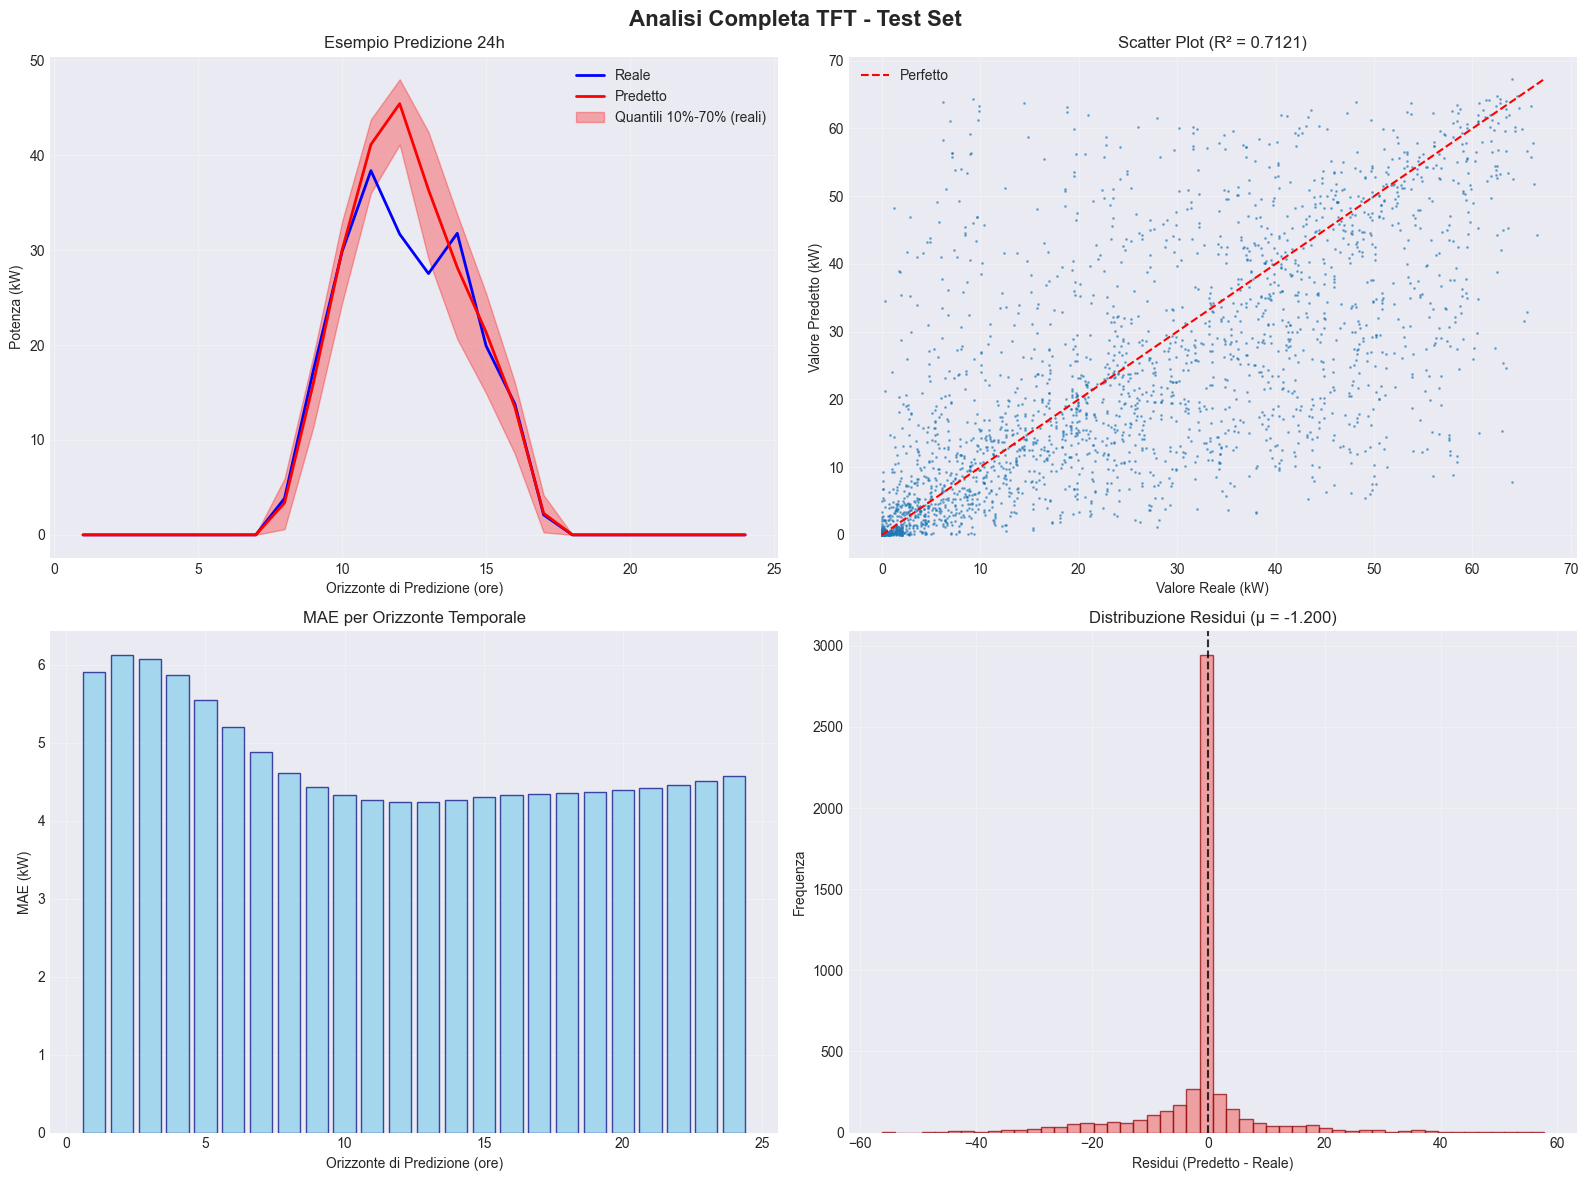


✓ Grafici salvati: results\run_corretta\figures\test_set_analysis_comprehensive.png


In [156]:
# =============================================================================
# GRAFICI ANALISI TEST SET (identici a quelli del validation)
# =============================================================================

import matplotlib.pyplot as plt

print(f"{'='*70}")
print(f"CREAZIONE GRAFICI TEST SET")
print(f"{'='*70}")

# Verifica presenza quantili reali
has_real_quantiles = 'q10' in df_pred_long_test.columns and 'q70' in df_pred_long_test.columns
has_timestamps = 'timestamp' in df_pred_long_test.columns

print(f"Dati disponibili:")
print(f"  Righe totali: {len(df_pred_long_test):,}")
print(f"  Finestre: {df_pred_long_test['window_id'].nunique()}")
print(f"  Orizzonte: {df_pred_long_test['horizon_h'].max()} ore")
print(f"  Timestamps: {has_timestamps}")
print(f"  Quantili reali: {has_real_quantiles}")

if has_real_quantiles:
    quantile_cols = [col for col in df_pred_long_test.columns if col.startswith('q')]
    print(f"  Quantili disponibili: {quantile_cols}")

# Prende un campione rappresentativo per i grafici (troppi dati altrimenti)
sample_size = min(5000, len(df_pred_long_test))
df_sample_test = df_pred_long_test.sample(n=sample_size, random_state=42)

# Crea figura principale
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analisi Completa TFT - Test Set', fontsize=16, fontweight='bold')

# Grafico 1: Serie temporale (esempio di una finestra)
ax1 = axes[0, 0]
if has_timestamps:
    sample_window = df_pred_long_test[df_pred_long_test['window_id'] == df_pred_long_test['window_id'].iloc[0]].sort_values('horizon_h')
    ax1.plot(sample_window['horizon_h'], sample_window['y_true'], 'b-', label='Reale', linewidth=2)
    ax1.plot(sample_window['horizon_h'], sample_window['y_pred'], 'r-', label='Predetto', linewidth=2)
    
    # Usa quantili reali se disponibili
    if has_real_quantiles:
        ax1.fill_between(sample_window['horizon_h'], 
                        sample_window['q10'], 
                        sample_window['q70'], 
                        alpha=0.3, color='red', label='Quantili 10%-70% (reali)')
    else:
        ax1.fill_between(sample_window['horizon_h'], 
                        sample_window['y_pred'] * 0.85, 
                        sample_window['y_pred'] * 1.15, 
                        alpha=0.3, color='red', label='Intervallo ±15% (mock)')
        
    ax1.set_xlabel('Orizzonte di Predizione (ore)')
    ax1.set_ylabel('Potenza (kW)')
    ax1.set_title('Esempio Predizione 24h')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
else:
    ax1.text(0.5, 0.5, 'Timestamps non disponibili', ha='center', va='center', transform=ax1.transAxes)
    ax1.set_title('Serie Temporale non Disponibile')

# Grafico 2: Scatter plot
ax2 = axes[0, 1]
ax2.scatter(df_sample_test['y_true'], df_sample_test['y_pred'], alpha=0.5, s=1)
min_val = min(df_sample_test['y_true'].min(), df_sample_test['y_pred'].min())
max_val = max(df_sample_test['y_true'].max(), df_sample_test['y_pred'].max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfetto')
ax2.set_xlabel('Valore Reale (kW)')
ax2.set_ylabel('Valore Predetto (kW)')
ax2.set_title(f'Scatter Plot (R² = {r2_test:.4f})')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Grafico 3: MAE per orizzonte temporale
ax3 = axes[1, 0]
mae_by_h = df_pred_long_test.groupby('horizon_h').apply(
    lambda x: np.mean(np.abs(x['y_true'] - x['y_pred']))
)
ax3.bar(mae_by_h.index, mae_by_h.values, alpha=0.7, color='skyblue', edgecolor='navy')
ax3.set_xlabel('Orizzonte di Predizione (ore)')
ax3.set_ylabel('MAE (kW)')
ax3.set_title('MAE per Orizzonte Temporale')
ax3.grid(True, alpha=0.3)

# Grafico 4: Residui
ax4 = axes[1, 1]
residuals_sample = df_sample_test['y_pred'] - df_sample_test['y_true']
ax4.hist(residuals_sample, bins=50, alpha=0.7, color='lightcoral', edgecolor='darkred')
ax4.axvline(0, color='black', linestyle='--', alpha=0.8)
ax4.set_xlabel('Residui (Predetto - Reale)')
ax4.set_ylabel('Frequenza')
ax4.set_title(f'Distribuzione Residui (μ = {residuals_sample.mean():.3f})')
ax4.grid(True, alpha=0.3)

plt.tight_layout()

# Salva grafico
fig_path = FIGURES_DIR / "test_set_analysis_comprehensive.png"
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Grafici salvati: {fig_path}")
print(f"{'='*70}")

In [157]:
# =============================================================================
# SALVATAGGIO RISULTATI TEST SET
# =============================================================================

import json
import pickle
from datetime import datetime

print(f"{'='*60}")
print(f"SALVATAGGIO RISULTATI TEST SET")
print(f"{'='*60}")

# Crea dizionario completo dei risultati
test_results = {
    "metadata": {
        "test_period": f"{test_merged['datetime'].min()} → {test_merged['datetime'].max()}",
        "n_samples": int(len(test_merged)),
        "n_predictions": int(len(df_pred_long_test)),
        "n_windows": int(df_pred_long_test['window_id'].nunique()),
        "horizon_hours": int(df_pred_long_test['horizon_h'].max()),
        "evaluation_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "model_checkpoint": str(ckpt_path)
    },
    "metrics": {
        "mae": float(mae_test),
        "rmse": float(rmse_test),
        "r2": float(r2_test),
        "mape_masked": float(mape_masked_test) if mape_masked_test is not None else None,
        "mase_seasonal_24h": float(mase_test) if mase_test is not None else None,
        "mae_seasonal_baseline": float(mae_seasonal_test) if mae_seasonal_test is not None else None,
    },
    "data_info": {
        "has_timestamps": bool(has_timestamps),
        "has_quantiles": bool(has_real_quantiles),
        "quantile_columns": quantile_cols if has_real_quantiles else []
    }
}

# Salva in formato JSON (leggibile)
json_path = TEST_OUT_DIR / "test_results_summary.json"
with open(json_path, 'w') as f:
    json.dump(test_results, f, indent=2)
print(f"✓ Salvato JSON: {json_path}")

# Salva in formato pickle (completo)
pickle_path = TEST_OUT_DIR / "test_results_complete.pkl"
with open(pickle_path, 'wb') as f:
    pickle.dump({
        "results": test_results,
        "df_pred_long": df_pred_long_test,
        "test_data": test_data,
        "test_merged": test_merged
    }, f)
print(f"✓ Salvato Pickle: {pickle_path}")

# Stampa summary
print(f"\n{'='*60}")
print(f"SUMMARY FINALE TEST SET")
print(f"{'='*60}")
print(f"Periodo: {test_results['metadata']['test_period']}")
print(f"Campioni: {test_results['metadata']['n_samples']:,}")
print(f"Predizioni: {test_results['metadata']['n_predictions']:,}")
print(f"\nMetriche:")
print(f"  MAE:   {mae_test:.4f} kW")
print(f"  RMSE:  {rmse_test:.4f} kW")
print(f"  R²:    {r2_test:.6f}")
if mape_masked_test is not None:
    print(f"  MAPE masked: {mape_masked_test:.2f}%")
if mase_test is not None:
    print(f"  MASE:  {mase_test:.4f}")
print(f"\nFile salvati:")
print(f"  {json_path.name}")
print(f"  {pickle_path.name}")
print(f"  test_predictions_long.csv")
print(f"  test_set_analysis_comprehensive.png")
print(f"{'='*60}")

SALVATAGGIO RISULTATI TEST SET
✓ Salvato JSON: results\run_corretta\testing\test_results_summary.json
✓ Salvato Pickle: results\run_corretta\testing\test_results_complete.pkl

SUMMARY FINALE TEST SET
Periodo: 2012-07-01 00:00:00 → 2013-06-30 23:00:43.290000
Campioni: 8,760
Predizioni: 205,656

Metriche:
  MAE:   4.7492 kW
  RMSE:  10.0205 kW
  R²:    0.712132
  MAPE masked: 47.80%
  MASE:  1.0970

File salvati:
  test_results_summary.json
  test_results_complete.pkl
  test_predictions_long.csv
  test_set_analysis_comprehensive.png
